<p style="font-family: Cambria; font-size:2.5em;color:Black;"> LSTM Models for Multiclass and Multilabel Classification in Sentiment Analysis of Autonomous Vehicle Tweets</p>

>**The aim of this notebook is to compare the performance of multiclass and multilabel classification in order to choose the more accurate classification type.**

# Method

To ensure a fair comparison between the selected models, the manually labeled dataset was split into training, validation, and test subsets. Hyperparameters were then rigorously selected using the validation dataset. Finally, the models were evaluated using the test dataset and a 5 fold cross-validation.

For the LSTM model, a Bayesian optimization method was employed using the Optuna library. Bayesian optimization is favored over grid search for hyperparameter tuning in LSTM models because it efficiently explores the hyperparameter space by leveraging past evaluation results to inform future trials. This approach leads to faster convergence on optimal parameters with fewer evaluations. The text length and vocabulary limits were defined following a descriptive analysis. The other parameters were selected to accommodate the challenges posed by the small sample size of the data.


## Hardware and Software Environment

The system utilizes TensorFlow 2.13.0 with XLA (Accelerated Linear Algebra) compilation enabled, supporting both FP32 and FP16 precision operations. The NVIDIA L4 GPU (24GB GDDR6), based on the Ada Lovelace architecture, provides hardware support for tensor operations with compute capability 8.9.

The experiments were conducted with the following specifications:

Computing Hardware:
- GPU: NVIDIA L4 (Ada Lovelace architecture) with 24GB GDDR6 memory
- CPU: AMD EPYC 9454 48-Core Processor
- System Memory: 346GB RAM
- GPU Driver Version: 550.90.07
- CUDA Version: 12.4

Software Stack:
- Operating System: Linux 5.15.0-122-generic
- TensorFlow: Version 2.13.0
- Python: Version 3.9.21
- GCC Compiler: Version 11.3.0
- NVIDIA CUDA Runtime: Version 12.4

GPU Performance Metrics:
- Maximum Power Capacity: 72W
- Available GPU Memory: 23,034 MiB
- Memory Utilization: Dynamic allocation up to 20,979 MiB during experiments

System Configuration:
- CPU Architecture: x86_64 with 90 available cores
- L3 Cache: 1.4 GiB
- CPU Features: Support for AVX-512, FMA, and other advanced instruction sets
- Virtualization: Full AMD-V virtualization under KVM hypervisor


## Label Mapping

**Multiclass Classification**

  Column name: 'Label_B_emotion'<br>
  0: Negative<br>
  1: Neutral<br>
  2: Positive<br>

**Multilabel Classification**

Column names: 'Label_A1_positive', 'Label_A2_negative', 'Label_A3_neutral'

Sentiment label mapping:<br>
- 0 = absence of sentiment,<br>
- 1 = presence of sentiment

# Library installation

**Install PyTorch (CUDA-enabled version for GPU support)** <br>
`conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch`

**Install NumPy for numerical operations** <br>
`pip install numpy==1.24.3`

**Install scikit-learn for machine learning functions** <br>
`conda install scikit-learn`

**Install pandas for data manipulation** <br>
`conda install pandas`

**Install matplotlib for plotting** <br>
`conda install matplotlib`

**Install seaborn for enhanced visualization** <br>
`conda install seaborn`

# Import libraries

In [1]:
# Applying a deterministic approach
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [2]:
# =============================================================================
# Disable Python warnings
# =============================================================================
import warnings
warnings.filterwarnings('ignore')     # Suppress all warning messages

# =============================================================================
# Core Data Processing and Scientific Computing
# =============================================================================
import sys                            # System-specific parameters and functions
import numpy as np                    # Numerical computing and array operations
import pandas as pd                   # Data manipulation and analysis
import json                           # JSON file handling
from collections import Counter       # Container for counting hashable objects
import time                           # Time access and conversions
from datetime import datetime         # Date and time operations
from scipy import stats               # Statistical functions and tests

# =============================================================================
# Machine Learning and Deep Learning
# =============================================================================
import torch                          # PyTorch deep learning framework
import torchinfo                      # Model summary information
from torch.utils.data import Dataset  # Dataset class for PyTorch

# Transformers
import transformers
from transformers import (
    AdamW,                              # Optimizer
    AutoConfig,
    AutoTokenizer,                      # Tokenizer loading
    AutoModelForSequenceClassification, # Model loading
    EarlyStoppingCallback,               # Early stopping utility
    get_linear_schedule_with_warmup,    # Learning rate scheduler
    Trainer,                            # Training helper
    TrainingArguments,                  # Training configuration
    TrainerCallback                     # Base callback class
)

# Scikit-learn
import sklearn
from sklearn.model_selection import (
    train_test_split,                  # Split dataset into train and test sets
    KFold,                             # K-Fold cross-validation
    StratifiedKFold                    # Stratified K-Fold cross-validation
)
from sklearn.metrics import (
    accuracy_score,                    # Calculate accuracy metric
    confusion_matrix,                  # Calculate confusion matrix
    f1_score,                          # Calculate F1 score
    precision_score,                   # Calculate precision metric
    recall_score,                      # Calculate recall metric
    roc_curve,                         # Calculate ROC curve points
    auc,                               # Calculate Area Under Curve
    classification_report,             # Generate detailed classification metrics
    roc_auc_score,                     # Calculate ROC AUC score
    cohen_kappa_score,
    jaccard_score,
    hamming_loss,
    multilabel_confusion_matrix        # Calculate confusion matrix for each label
)
from sklearn.preprocessing import label_binarize  # Convert labels to binary format
import pyreadstat

# =============================================================================
# Visualization
# =============================================================================
import matplotlib.pyplot as plt          # Basic plotting library
import matplotlib.image as mpimg         # Image loading utility
from matplotlib import gridspec          # Complex grid layout management
import seaborn as sns                    # Statistical data visualization

# Visualization Settings
plt.rcParams['figure.dpi'] = 100        # Set figure resolution
sns.set_palette("tab20")                # Set default color palette
SMALL_SIZE = 12                         # Define font size for small text
MEDIUM_SIZE = 13                        # Define font size for medium text
BIGGER_SIZE = 14                        # Define font size for large text

# Configure plot styling
plt.rc('font', size=SMALL_SIZE)         # Set default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)    # Set axes title size
plt.rc('axes', labelsize=MEDIUM_SIZE)    # Set axes label size
plt.rc('axes', labelweight='normal')     # Set axes label weight
plt.rc('axes', labelcolor='black')       # Set axes label color
plt.rc('axes', labelpad=5)               # Set padding between label and axis
plt.rc('axes', titlepad=10)              # Set padding between title and plot
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # Set x-tick label size
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # Set y-tick label size
plt.rc('legend', fontsize=SMALL_SIZE)    # Set legend font size
plt.rc('figure', titlesize=MEDIUM_SIZE)  # Set figure title size
plt.rc('figure', labelsize=BIGGER_SIZE)  # Set figure label size
sns.set_style("darkgrid", {'axes.grid': False})  # Set plot style with no grid

# =============================================================================
# Utility Modules
# =============================================================================
import os                              # Operating system interface
import random                          # Random number generation
import optuna                          # Hyperparameter optimization
import logging                         # Logging facility for Python
import platform                        # System platform information
import jupyterlab                      # JupyterLab interface
import ipywidgets                      # Interactive widgets
import copy                            # Deep copy operations
import pickle                          # Object serialization
from pathlib import Path               # Object-oriented filesystem paths
from IPython.display import display, HTML  # Display objects in notebook

In [3]:
# Record the start time for measuring total notebook execution duration
start_global_notebook_running_time = time.time()

# GPU verification

In [4]:
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

# Check GPU properties
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA available: True
CUDA version: 12.4
PyTorch version: 2.5.1
GPU Device: NVIDIA L4
GPU Memory: 21.95 GB


# Data opening & preparation

In [5]:
# Read all datasets
trainDf = pd.read_csv('/workspace/train60_data_mapped.csv', sep=";") #60% of the labeled tweets
valDf = pd.read_csv('/workspace/val20_data_mapped.csv', sep=";")     #20% of the labeled tweets
testDf = pd.read_csv('/workspace/test20_data_mapped.csv', sep=";")   #20% of the labeled tweets

# Concatenate all dataframes
df = pd.concat([trainDf, valDf, testDf], axis=0, ignore_index=True)

# sample for rush the code development
#trainDf = trainDf.head(60)
#valDf = valDf.head(20)
#testDf = testDf.head(20)

# Display information about the combined dataset
print("\nCombined Dataset Info:")
print("Shape:", df.shape)

# Display basic information about each dataset
print("\nTraining Dataset Info:")
print("Shape:", trainDf.shape)

print("\nValidation Dataset Info:")
print("Shape:", valDf.shape)

print("\nTest Dataset Info:")
print("Shape:", testDf.shape)


Combined Dataset Info:
Shape: (1198, 7)

Training Dataset Info:
Shape: (718, 7)

Validation Dataset Info:
Shape: (240, 7)

Test Dataset Info:
Shape: (240, 7)


# LSTM - Multiclass classification

## Multiclass & text: preparing training, validation and testing datasets

In [6]:
# Extracting features (text) and labels from training DataFrame
X_train = trainDf['text'].tolist()
y_train = trainDf['Label_B_emotion'].tolist()
"""
Training Data (60%):
Features (X_train) and labels (y_train) extracted from the training dataset for model development.
"""

# Extracting features (text) and labels from validation DataFrame
X_val = valDf['text'].tolist()
y_val = valDf['Label_B_emotion'].tolist()
"""
Validation Data (20%):
Features (X_val) and labels (y_val) extracted from the validation dataset for model optimization.
"""

# Extracting features (text) and labels from test DataFrame
X_test = testDf['text'].tolist()
y_test = testDf['Label_B_emotion'].tolist()
"""
Test Data (20%):
Features (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.
"""

'\nTest Data (20%):\nFeatures (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.\n'

## Optuna Search

**Method for Selecting the Best Model**

A custum score (balanced score) was calculated using the following distribution of weights:
- Weighted_f1: 40% weight on F1 score
- Normalized Loss: 30% weight on loss
- Cross-Validation Stability: 30% weight.

The `calculate_balanced_score` function computes a score ranging from 0 to 1. A value closer to 1 indicates better model performance.

In [7]:
# ===========================================================================================================
#                              Optuna Hyperparameters Search for LSTM
#                          Full Deterministisc Approach to Ensure Reproductibility
# ===========================================================================================================

import os
import csv
import time
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup

# Disable parallelism for tokenizers to better fit small training datasets
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# ======================= Seed Control for Reproducibility ========================

# Deterministic Approach
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the output directory for Optuna
OPTUNA_OUTPUT_DIR = "/workspace/Output/LSTM/LSTM_MC/Optuna_search"
os.makedirs(OPTUNA_OUTPUT_DIR, exist_ok=True)

# Additional global settings
try:
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
except ImportError:
    pass

# Ensure a clean, consistent study creation
def create_deterministic_study():
    # Construct the storage path
    storage_path = f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db'
    
    # Study name remains consistent
    study_name = 'LSTM_Sentiment_Optimization'
    
    # Delete existing study if it exists
    try:
        optuna.delete_study(study_name=study_name, storage=storage_path)
    except KeyError:
        # Study doesn't exist, which is fine
        pass
    except Exception as e:
        print(f"Unexpected error deleting study: {e}")
    
    # Create a new study with consistent parameters
    study = optuna.create_study(
        direction='maximize', 
        storage=storage_path,
        study_name=study_name,
        load_if_exists=False
    )
    
    return study


# ==================== Cleaning Previous Study ====================

# Delete existing study if it exists
try:
    optuna.delete_study(
        study_name='LSTM_Sentiment_Optimization', 
        storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db'
    )
except Exception as e:
    print(f"Error deleting existing study: {e}")

# Create a new study
study = optuna.create_study(
    direction='maximize', 
    storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db',
    study_name='LSTM_Sentiment_Optimization_' + str(int(time.time())),  # Add timestamp to make unique
    load_if_exists=False
)

# ======================= Balanced Score ========================

def balanced_score(y_true, y_pred, loss):
    """
    Balanced score metric:
    40% Weighted F1 Score
    30% Normalized Loss
    30% CV Stability
    """
    from sklearn.metrics import f1_score
    
    # Weighted F1 Score (40%)
    f1 = f1_score(y_true, y_pred, average='weighted') * 0.4
    
    # Normalize Loss (30%)
    max_loss = 10  # Set a reasonable maximum loss value
    normalized_loss = max(0, 1 - (loss / max_loss)) * 0.3
    
    # Cross-Validation Stability (30%)
    # This would be calculated across multiple folds
    cv_stability = 1.0 * 0.3
    
    return f1 + normalized_loss + cv_stability


# ======================= Text Preparation ========================

class Tokenizer:
    """Simple tokenizer class"""
    def __init__(self, texts, max_words=10000):
        self.max_words = max_words
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.word_counts = {}
        
        # Build vocabulary
        self.build_vocab(texts)
    
    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        # Count words
        for text in texts:
            for word in str(text).lower().split():
                self.word_counts[word] = self.word_counts.get(word, 0) + 1
        
        # Sort by frequency and take top max_words
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (word, _) in enumerate(sorted_words[:self.max_words-2], start=2):
            self.word2idx[word] = i
            self.idx2word[i] = word
    
    def encode(self, text):
        """Convert text to token ids"""
        return [self.word2idx.get(word.lower(), 1) for word in str(text).split()]
    
    def decode(self, ids):
        """Convert token ids back to text"""
        return ' '.join([self.idx2word.get(id_, '<unk>') for id_ in ids])
    
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    """Dataset for text classification"""
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Tokenize text
        tokens = self.tokenizer.encode(self.texts[idx])
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        
        # Pad tokens
        tokens = tokens + [0] * (self.max_length - len(tokens))
        
        # Convert to tensor
        tokens = torch.tensor(tokens, dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return tokens, label


# ======================= Model Definition: LSTM-based Architecture ========================

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return self.softmax(logits)
        
        return output


# ======================= Preparing Data ========================

def prepare_data(X_train, y_train, X_val, y_val, max_length, max_words, trial_number=None):
    """
    Prepare data for LSTM model
    """
    # Create tokenizer
    tokenizer = Tokenizer(X_train + X_val, max_words=max_words)
    
    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, max_length)
    val_dataset = TextDataset(X_val, y_val, tokenizer, max_length)
    
    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    
    # Additional information
    vocab_size = len(tokenizer)
    num_classes = len(np.unique(y_train_encoded))
    
    # Modify print statements to include trial number
    if trial_number is not None:
        print(f"Trial number {trial_number}")
    
    return train_dataset, val_dataset, tokenizer, vocab_size, num_classes

# ======================= Metric Calculations for Evaluation =======================
def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive classification metrics
    
    Args:
        y_true (torch.Tensor): True labels
        y_pred (torch.Tensor): Predicted probabilities
    
    Returns:
        dict: Comprehensive metrics including macro, micro, and weighted averages
    """
    # Convert predictions and true labels to numpy
    y_pred_labels = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_labels = y_true.cpu().numpy()
    
    # Define metric calculation with different averaging methods
    metric_types = {
        'accuracy': {
            'macro': lambda: accuracy_score(y_true_labels, y_pred_labels),
            'micro': lambda: accuracy_score(y_true_labels, y_pred_labels),
            'weighted': lambda: accuracy_score(y_true_labels, y_pred_labels)
        },
        'f1': {
            'macro': lambda: f1_score(y_true_labels, y_pred_labels, average='macro'),
            'micro': lambda: f1_score(y_true_labels, y_pred_labels, average='micro'),
            'weighted': lambda: f1_score(y_true_labels, y_pred_labels, average='weighted')
        },
        'precision': {
            'macro': lambda: precision_score(y_true_labels, y_pred_labels, average='macro'),
            'micro': lambda: precision_score(y_true_labels, y_pred_labels, average='micro'),
            'weighted': lambda: precision_score(y_true_labels, y_pred_labels, average='weighted')
        },
        'recall': {
            'macro': lambda: recall_score(y_true_labels, y_pred_labels, average='macro'),
            'micro': lambda: recall_score(y_true_labels, y_pred_labels, average='micro'),
            'weighted': lambda: recall_score(y_true_labels, y_pred_labels, average='weighted')
        }
    }
    
    # Flatten the metrics into a single dictionary
    flattened_metrics = {}
    for metric, averages in metric_types.items():
        for avg_type, calc_func in averages.items():
            metric_key = f'{metric} ({avg_type})'
            flattened_metrics[metric_key] = calc_func()
    
    return flattened_metrics


# ======================= Saving Trial Results =======================

def save_trial_results(trial_number, params, metrics, balanced_score, output_dir):
    """
    Save trial results to a CSV file, ensuring one row per trial
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file path
    results_file = os.path.join(output_dir, 'optuna_trial_results.csv')
    
    # Check if file exists to determine whether to write headers
    file_exists = os.path.exists(results_file)
    
    # Open file in append mode
    with open(results_file, 'a', newline='') as csvfile:
        # Combine params and metrics
        combined_results = {**params, **metrics}
        
        # Create CSV writer
        fieldnames = ['trial_number', 'balanced_score'] + list(combined_results.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')
        
        # Write headers if file is new
        if not file_exists:
            writer.writeheader()
        
        # Write trial results (only one row)
        row_data = {
            'trial_number': trial_number, 
            'balanced_score': balanced_score,
            **combined_results
        }
        writer.writerow(row_data)
        
# ======================= Training & Validation ========================

def train_and_evaluate(model, train_dataset, val_dataset, 
                       learning_rate, batch_size, epochs, weight_decay,
                       warmup_steps=0):  # Add warmup_steps with a default value
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Optimizer 
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    
    # Learning rate scheduler with warmup
    total_training_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=warmup_steps, 
        num_training_steps=total_training_steps
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Early Stopping Parameters
    patience = 3
    min_delta = 0.01  # Minimum change to qualify as an improvement
    best_val_score = 0
    patience_counter = 0
    best_metrics = {}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            scheduler.step()  # Step the scheduler after each batch
        
        # Validation phase
        model.eval()
        all_preds = []
        all_labels = []
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y)
                total_val_loss += val_loss.item()
                
                all_preds.append(outputs)
                all_labels.append(batch_y)
        
        # Concatenate predictions and labels
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
        # Calculate metrics
        metrics = calculate_metrics(all_labels, all_preds)
        
        # Compute balanced score
        avg_val_loss = total_val_loss / len(val_loader)
        fold_score = balanced_score(all_labels.cpu().numpy(), 
                                    all_preds.argmax(dim=1).cpu().numpy(), 
                                    avg_val_loss)
        
        # Early Stopping Logic
        if fold_score > best_val_score + min_delta:
            best_val_score = fold_score
            best_metrics = metrics
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Stop training if no improvement
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    return best_val_score, best_metrics


# ======================= Objective Function for Optuna Optimization =======================

def objective(trial, X_train, y_train, X_val, y_val):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.002, 0.003])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    hidden_size = trial.suggest_categorical('hidden_size', [128, 192, 256])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4])
    weight_decay = trial.suggest_categorical('weight_decay', [0.05, 0.1, 0.2])
    epochs = trial.suggest_categorical('epochs', [4, 7, 10, 13])
    max_length = trial.suggest_categorical('max_length', [22, 26])
    max_words = trial.suggest_categorical('max_words', [1500, 2000, 2500])
    warmup_steps = trial.suggest_categorical('warmup_steps', [250, 500, 750])
    embedding_dim = trial.suggest_categorical('embedding_dim', [128, 144, 160])
    
    try:
        # Prepare data with trial number
        (train_dataset, val_dataset, tokenizer, 
         vocab_size, num_classes) = prepare_data(
            X_train, y_train, X_val, y_val, 
            max_length=max_length,
            max_words=max_words,
            trial_number=trial.number  # Pass the trial number
        )
        
        # Model setup
        model = LSTMModel(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout_rate
        )

        
        # Train and evaluate
        val_score, metrics = train_and_evaluate(
            model, 
            train_dataset, val_dataset,
            learning_rate, batch_size, epochs, weight_decay,
            warmup_steps=warmup_steps
        )
        
        # Save trial results
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics=metrics or {},  # Use empty dict if metrics is None
            balanced_score=val_score,
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        return val_score
    
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        import traceback
        traceback.print_exc()
        
        # Save error information
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics={'error': str(e)},
            balanced_score=float('-inf'),
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        return float('-inf')
    
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        import traceback
        traceback.print_exc()  # Print full traceback for more detailed error info
        
        # Save minimal information for failed trials
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics={'error': str(e)},
            balanced_score=float('-inf'),
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        # Return a low score to indicate failure
        return float('-inf')

        
# =============== Main Function to Run Optuna Optimization Study and Save Results ===============

def main(trainDf, valDf):

    # Extract data
    X_train = trainDf['text'].tolist()
    y_train = trainDf['Label_B_emotion'].tolist()
    X_val = valDf['text'].tolist()
    y_val = valDf['Label_B_emotion'].tolist()
    
    # Ensure a clean start for the CSV
    results_file = os.path.join(OPTUNA_OUTPUT_DIR, 'optuna_trial_results.csv')
    if os.path.exists(results_file):
        os.remove(results_file)
        
    # Create a deterministic study
    study = optuna.create_study(
        direction='maximize', 
        storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db',
        study_name='LSTM_Sentiment_Optimization',
        load_if_exists=False
    )
    
    # Partial function to pass additional arguments
    def objective_wrapper(trial):
        return objective(trial, X_train, y_train, X_val, y_val)
    
    # Run the optimization
    study.optimize(objective_wrapper, n_trials=35)
    
    # Print and save best parameters
    print(f'Best trial: {study.best_trial.number}')
    trial = study.best_trial
    
    print(f'  Value: {trial.value}')
    print('  Params: ')
    best_params = {}
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        best_params[key] = value
    
    # Save best parameters to JSON
    best_params_path = os.path.join(OPTUNA_OUTPUT_DIR, 'best_params.json')
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)
    
    print(f'\nBest parameters saved to {best_params_path}')
        
    return best_params


if __name__ == '__main__':
    best_params = main(trainDf, valDf)
    pass

[I 2025-01-12 07:47:23,848] A new study created in RDB with name: LSTM_Sentiment_Optimization_1736668043
[I 2025-01-12 07:47:23,901] A new study created in RDB with name: LSTM_Sentiment_Optimization


Trial number 0


[I 2025-01-12 07:47:28,188] Trial 0 finished with value: 0.7404098690199461 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 750, 'embedding_dim': 144}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 10 epochs
Trial number 1


[I 2025-01-12 07:47:30,918] Trial 1 finished with value: 0.6829469638670567 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.2, 'epochs': 13, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 144}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 5 epochs
Trial number 2


[I 2025-01-12 07:47:32,258] Trial 2 finished with value: 0.6995731475348201 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 7, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 144}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 6 epochs
Trial number 3


[I 2025-01-12 07:47:32,998] Trial 3 finished with value: 0.6900668190242362 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 13, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 144}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 4 epochs
Trial number 4


[I 2025-01-12 07:47:34,677] Trial 4 finished with value: 0.7110144408070751 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'weight_decay': 0.2, 'epochs': 13, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 8 epochs
Trial number 5


[I 2025-01-12 07:47:35,808] Trial 5 finished with value: 0.6750930855056007 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 4, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 160}. Best is trial 0 with value: 0.7404098690199461.


Trial number 6


[I 2025-01-12 07:47:40,887] Trial 6 finished with value: 0.7191700854800628 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 13, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 128}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 7 epochs
Trial number 7


[I 2025-01-12 07:47:42,669] Trial 7 finished with value: 0.7278162659419926 and parameters: {'learning_rate': 0.002, 'batch_size': 16, 'hidden_size': 128, 'num_layers': 1, 'dropout_rate': 0.3, 'weight_decay': 0.2, 'epochs': 13, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 0 with value: 0.7404098690199461.


Early stopping triggered after 9 epochs
Trial number 8


[I 2025-01-12 07:47:46,720] Trial 8 finished with value: 0.7420377570989503 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 13, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 8 with value: 0.7420377570989503.


Early stopping triggered after 8 epochs
Trial number 9


[I 2025-01-12 07:47:47,830] Trial 9 finished with value: 0.6915758219724414 and parameters: {'learning_rate': 0.002, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.4, 'weight_decay': 0.2, 'epochs': 4, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 144}. Best is trial 8 with value: 0.7420377570989503.


Trial number 10


[I 2025-01-12 07:47:51,651] Trial 10 finished with value: 0.6889070466979088 and parameters: {'learning_rate': 0.002, 'batch_size': 8, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 7, 'max_length': 26, 'max_words': 2000, 'warmup_steps': 250, 'embedding_dim': 128}. Best is trial 8 with value: 0.7420377570989503.


Early stopping triggered after 5 epochs
Trial number 11


[I 2025-01-12 07:47:54,168] Trial 11 finished with value: 0.728887146051757 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 750, 'embedding_dim': 160}. Best is trial 8 with value: 0.7420377570989503.


Early stopping triggered after 8 epochs
Trial number 12


[I 2025-01-12 07:47:56,028] Trial 12 finished with value: 0.7180347494143506 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 750, 'embedding_dim': 160}. Best is trial 8 with value: 0.7420377570989503.


Early stopping triggered after 9 epochs
Trial number 13


[I 2025-01-12 07:47:58,246] Trial 13 finished with value: 0.7000874979143955 and parameters: {'learning_rate': 0.002, 'batch_size': 16, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 144}. Best is trial 8 with value: 0.7420377570989503.


Early stopping triggered after 5 epochs
Trial number 14


[I 2025-01-12 07:48:02,261] Trial 14 finished with value: 0.7464141695100364 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 128}. Best is trial 14 with value: 0.7464141695100364.


Early stopping triggered after 8 epochs
Trial number 15


[I 2025-01-12 07:48:06,848] Trial 15 finished with value: 0.7337897605768902 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 128}. Best is trial 14 with value: 0.7464141695100364.


Early stopping triggered after 9 epochs
Trial number 16


[I 2025-01-12 07:48:09,904] Trial 16 finished with value: 0.691139905020997 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 4, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 128}. Best is trial 14 with value: 0.7464141695100364.


Trial number 17


[I 2025-01-12 07:48:12,065] Trial 17 finished with value: 0.6806410690093088 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 7, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 128}. Best is trial 14 with value: 0.7464141695100364.


Early stopping triggered after 4 epochs
Trial number 18


[I 2025-01-12 07:48:15,085] Trial 18 finished with value: 0.6742471324794663 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 13, 'max_length': 26, 'max_words': 2000, 'warmup_steps': 250, 'embedding_dim': 128}. Best is trial 14 with value: 0.7464141695100364.


Early stopping triggered after 4 epochs
Trial number 19


[I 2025-01-12 07:48:17,491] Trial 19 finished with value: 0.7568374194361989 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 20


[I 2025-01-12 07:48:18,482] Trial 20 finished with value: 0.6823942178496272 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 6 epochs
Trial number 21


[I 2025-01-12 07:48:20,901] Trial 21 finished with value: 0.7494100475962879 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 22


[I 2025-01-12 07:48:23,091] Trial 22 finished with value: 0.7535159229243711 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 9 epochs
Trial number 23


[I 2025-01-12 07:48:25,419] Trial 23 finished with value: 0.7431920064109527 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 9 epochs
Trial number 24


[I 2025-01-12 07:48:27,804] Trial 24 finished with value: 0.7471176900727834 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 25


[I 2025-01-12 07:48:30,233] Trial 25 finished with value: 0.7476297815525534 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 26


[I 2025-01-12 07:48:32,698] Trial 26 finished with value: 0.7316254576998116 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 10 epochs
Trial number 27


[I 2025-01-12 07:48:36,261] Trial 27 finished with value: 0.7515604248276011 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 28


[I 2025-01-12 07:48:39,679] Trial 28 finished with value: 0.7556798001495972 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 29


[I 2025-01-12 07:48:42,875] Trial 29 finished with value: 0.7529493511823333 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 30


[I 2025-01-12 07:48:44,719] Trial 30 finished with value: 0.6808052236554467 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 5 epochs
Trial number 31


[I 2025-01-12 07:48:47,878] Trial 31 finished with value: 0.7290508831887756 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 32


[I 2025-01-12 07:48:49,843] Trial 32 finished with value: 0.6857047707307082 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 6 epochs
Trial number 33


[I 2025-01-12 07:48:53,198] Trial 33 finished with value: 0.7285221211121138 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Trial number 34


[I 2025-01-12 07:48:55,208] Trial 34 finished with value: 0.6883129296032177 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 7, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 19 with value: 0.7568374194361989.


Early stopping triggered after 6 epochs
Best trial: 19
  Value: 0.7568374194361989
  Params: 
    learning_rate: 0.002
    batch_size: 32
    hidden_size: 192
    num_layers: 2
    dropout_rate: 0.2
    weight_decay: 0.05
    epochs: 10
    max_length: 22
    max_words: 1500
    warmup_steps: 500
    embedding_dim: 160

Best parameters saved to /workspace/Output/LSTM/LSTM_MC/Optuna_search/best_params.json


## Testing code

In [8]:

# ==========================================================================================
#              LSTM Model Using the Best Hyperparameters Obtained from Optuna
#                                  Multiclass Classification
# ==========================================================================================

from IPython.display import display, HTML
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
from scipy import stats
import pandas as pd
import os
import json
import logging
from pathlib import Path
import time
from datetime import datetime
import copy

# Disable parallelism for tokenizers to better fit small training datasets
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

class Config:
    MODEL_NAME = "LSTM"
    OUTPUT_DIR = "/workspace/Output/LSTM/LSTM_MC"
    NUM_FOLDS = 5
    NUM_CLASSES = 3
    SEED = 42

    def __init__(self):
        best_params_path = os.path.join(self.OUTPUT_DIR, 'Optuna_search', 'best_params.json')
        try:
            with open(best_params_path, 'r') as f:
                best_params = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError) as e:
            raise ValueError(f"Could not load best parameters from {best_params_path}: {e}")

        # Hyperparameters
        self.LEARNING_RATE = best_params['learning_rate']
        self.NUM_EPOCHS = best_params['epochs']
        self.BATCH_SIZE = best_params['batch_size']
        self.WARMUP_STEPS = best_params['warmup_steps']
        self.WEIGHT_DECAY = best_params['weight_decay']
        self.WARMUP_RATIO = 0.1
        self.MAX_LENGTH = best_params['max_length']
        self.EMBEDDING_DIM = best_params['embedding_dim']
        self.HIDDEN_DIM = best_params['hidden_size']
        self.NUM_LAYERS = best_params['num_layers']
        self.DROPOUT = best_params['dropout_rate']
        self.MAX_WORDS = best_params['max_words']
        self.EARLY_STOPPING_PATIENCE = 3
        self.EARLY_STOPPING_THRESHOLD = 0.01
        self.EVALUATION_STRATEGY = "epoch"
        self.METRIC_FOR_BEST_MODEL = "custom_metric"
        self.ACTIVATION = "softmax"
        self.OPTIMIZER = "adamw"
        self.LOSS_FUNCTION = "cross_entropy"
        self.NUM_CLASSES = 3

        print("Loaded Configuration:")
        for key, value in best_params.items():
            print(f"{key.upper()}: {value}")

        torch.manual_seed(Config.SEED)
        torch.cuda.manual_seed(Config.SEED)
        np.random.seed(Config.SEED)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        tokens = self.tokenizer.encode(text)
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        tokens = torch.tensor(tokens, dtype=torch.long)
        label = torch.tensor(label, dtype=torch.long)
        return {'input_ids': tokens, 'labels': label}

class Tokenizer:
    def __init__(self, texts, max_words=10000):
        self.max_words = max_words
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.word_counts = {}
        self.build_vocab(texts)

    def build_vocab(self, texts):
        for text in texts:
            for word in str(text).lower().split():
                self.word_counts[word] = self.word_counts.get(word, 0) + 1

        # Sort by frequency and limit vocabulary size
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (word, _) in enumerate(sorted_words[:self.max_words-2], start=2):
            self.word2idx[word] = i
            self.idx2word[i] = word

        # Log final vocabulary size
        print(f"Built vocabulary with size {len(self.word2idx)} out of {self.max_words} max words")
        
    def encode(self, text):
        return [self.word2idx.get(word.lower(), 1) for word in str(text).split()]

    def decode(self, ids):
        return ' '.join([self.idx2word.get(id_, '<unk>') for id_ in ids])

    def __len__(self):
        return len(self.word2idx)

def metric2_MC(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    differences = np.abs(y_true - y_pred)
    n_classes = len(np.unique(y_true))
    off_by_one_per_class = []
    for j in range(n_classes):
        class_mask = (y_true == j)
        if np.sum(class_mask) > 0:
            off_by_one = np.sum((differences == 1) & class_mask)
            proportion = off_by_one / np.sum(class_mask)
            off_by_one_per_class.append(proportion)
    metric = 1 - np.mean(off_by_one_per_class)
    return metric

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout, config):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.activation = (nn.Softmax(dim=1) if config.LOSS_FUNCTION == "cross_entropy" 
                           else nn.Sigmoid())

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return self.activation(logits)


class CustomEarlyStoppingCallback:
    def __init__(self, patience=3, threshold=0.01):
        self.patience = patience
        self.threshold = threshold
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None
        self.best_metrics = None
        self.best_epoch = None

    def compute_balanced_score(self, metrics, history=None):
        weighted_f1 = metrics.get('F1-Score (Weighted)', 0)
        loss = metrics.get('loss', 0)
        normalized_loss = max(0, min(1, 1 - (loss / 4)))
        stability_score = 0
        if history and len(history) >= 2:
            recent_f1s = [h.get('F1-Score (Weighted)', 0) for h in history[-2:]]
            stability_score = 1 - abs(recent_f1s[1] - recent_f1s[0])
        balanced_score = (
            0.4 * weighted_f1 + 0.3 * normalized_loss + 0.3 * stability_score
        )
        return balanced_score

    def __call__(self, val_metrics, model, epoch):
        self.validation_history = getattr(self, 'validation_history', [])
        self.validation_history.append(val_metrics)
        score = self.compute_balanced_score(
            val_metrics,
            self.validation_history if len(self.validation_history) > 1 else None
        )
        if self.best_score is None:
            self.best_score = score
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_metrics = val_metrics.copy()
            self.best_epoch = epoch
        elif score > self.best_score + self.threshold:
            self.best_score = score
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_metrics = val_metrics.copy()
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

class ModelTrainer:
    def __init__(self, model, config, device, logger):
        self.model = model
        self.config = config
        self.device = device
        self.logger = logger
        self.criterion = (nn.CrossEntropyLoss() if config.LOSS_FUNCTION == "cross_entropy" 
                     else nn.BCELoss())
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        self.history = {
            'loss': [], 'val_loss': [],
            'metrics': [], 'val_metrics': []
        }

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        for batch in train_loader:
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(input_ids)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        def compute_macro_accuracy(y_true, y_pred):
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            classes = np.unique(y_true)
            class_accuracies = []
            for c in classes:
                class_mask = (y_true == c)
                if np.sum(class_mask) > 0:
                    correct = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                    total = np.sum(class_mask)
                    class_accuracies.append(correct / total)
            return np.mean(class_accuracies) if class_accuracies else 0

        metrics = {
            'loss': total_loss / len(train_loader),
            'Accuracy (Macro)': compute_macro_accuracy(all_labels, all_preds),
            'Accuracy (Micro)': accuracy_score(all_labels, all_preds),
            'Accuracy (Weighted)': accuracy_score(all_labels, all_preds, sample_weight=np.ones_like(all_labels)),
            'Precision (Macro)': precision_score(all_labels, all_preds, average='macro', zero_division=0),
            'Precision (Micro)': precision_score(all_labels, all_preds, average='micro', zero_division=0),
            'Precision (Weighted)': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Recall (Macro)': recall_score(all_labels, all_preds, average='macro', zero_division=0),
            'Recall (Micro)': recall_score(all_labels, all_preds, average='micro', zero_division=0),
            'Recall (Weighted)': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
            'F1-Score (Macro)': f1_score(all_labels, all_preds, average='macro', zero_division=0),
            'F1-Score (Micro)': f1_score(all_labels, all_preds, average='micro', zero_division=0),
            'F1-Score (Weighted)': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Metric2_MC': metric2_MC(all_labels, all_preds)
        }
        self.history['loss'].append(metrics['loss'])
        self.history['metrics'].append(metrics)
        return metrics

    def evaluate(self, val_loader):
        """Evaluate the model"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        def compute_macro_accuracy(y_true, y_pred):
            """Compute macro accuracy with proper class handling"""
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            classes = np.unique(y_true)
            class_accuracies = []
            for c in classes:
                class_mask = (y_true == c)
                if np.sum(class_mask) > 0:
                    correct = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                    total = np.sum(class_mask)
                    class_accuracies.append(correct / total)
            return np.mean(class_accuracies) if class_accuracies else 0

        # Calculate comprehensive metrics
        metrics = {
            'loss': total_loss / len(val_loader),
            'Accuracy (Macro)': compute_macro_accuracy(all_labels, all_preds),
            'Accuracy (Micro)': accuracy_score(all_labels, all_preds),
            'Accuracy (Weighted)': accuracy_score(all_labels, all_preds, sample_weight=np.ones_like(all_labels)),
            'Precision (Macro)': precision_score(all_labels, all_preds, average='macro', zero_division=0),
            'Precision (Micro)': precision_score(all_labels, all_preds, average='micro', zero_division=0),
            'Precision (Weighted)': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Recall (Macro)': recall_score(all_labels, all_preds, average='macro', zero_division=0),
            'Recall (Micro)': recall_score(all_labels, all_preds, average='micro', zero_division=0),
            'Recall (Weighted)': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
            'F1-Score (Macro)': f1_score(all_labels, all_preds, average='macro', zero_division=0),
            'F1-Score (Micro)': f1_score(all_labels, all_preds, average='micro', zero_division=0),
            'F1-Score (Weighted)': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Metric2_MC': metric2_MC(all_labels, all_preds)
        }

        # Update history
        self.history['val_loss'].append(metrics['loss'])
        self.history['val_metrics'].append(metrics)
        return metrics

class EnsembleTrainer:
    """Enhanced ensemble trainer with more comprehensive metrics tracking"""
    def __init__(self, config, device, logger):
        self.config = config
        self.device = device
        self.logger = logger
        self.models = []
        self.tokenizer = None
        self.results_manager = ResultsManager(config.OUTPUT_DIR)
        # Enhanced metrics tracking
        self.validation_history = []
        self.training_history = []
        self.fold_metrics = []
        self.early_stopping_info = []
        self.oof_predictions = []
        self.oof_true_labels = []
        self.best_fold_index = None
        self.best_macro_f1 = float('-inf')
        self.best_fold_epoch = None
        self.early_stopping_callbacks = []
        self.training_history = []
        self.validation_history = []

    def train_fold(self, fold_idx, train_dataset, val_dataset, tokenizer):
        """Train a model for one fold with enhanced metrics tracking"""
        if self.tokenizer is None:
            self.tokenizer = tokenizer
            self.results_manager.tokenizer = tokenizer

            
        fold_training_history = []
        fold_validation_history = []
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=self.collate_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            collate_fn=self.collate_fn
        )

        # Initialize model
        model = LSTMModel(
            vocab_size=len(tokenizer),
            embedding_dim=self.config.EMBEDDING_DIM,
            hidden_dim=self.config.HIDDEN_DIM,
            num_layers=self.config.NUM_LAYERS,
            num_classes=self.config.NUM_CLASSES,
            dropout=self.config.DROPOUT,
            config=self.config
        ).to(self.device)

        # Initialize trainer
        trainer = ModelTrainer(model, self.config, self.device, self.logger)

        # Initialize callbacks
        early_stopping_callback = CustomEarlyStoppingCallback(
            patience=self.config.EARLY_STOPPING_PATIENCE,
            threshold=self.config.EARLY_STOPPING_THRESHOLD
        )
        while len(self.early_stopping_callbacks) <= fold_idx:
            self.early_stopping_callbacks.append(None)
        self.early_stopping_callbacks[fold_idx] = early_stopping_callback

        # Training loop
        best_val_f1 = 0
        best_model = None
        best_metrics = None
        for epoch in range(self.config.NUM_EPOCHS):
            # Train
            train_metrics = trainer.train_epoch(train_loader)
            fold_training_history.append({**train_metrics, 'epoch': epoch, 'fold': fold_idx})

            # Evaluate
            val_metrics = trainer.evaluate(val_loader)
            fold_validation_history.append({**val_metrics, 'epoch': epoch, 'fold': fold_idx})

            # Logging
            self.logger.info(
                f"Fold {fold_idx + 1}, Epoch {epoch + 1}/{self.config.NUM_EPOCHS} - "
                f"Train Loss: {train_metrics['loss']:.4f}, "
                f"Val Loss: {val_metrics['loss']:.4f}, "
                f"Val F1: {val_metrics['F1-Score (Macro)']:.4f}"
            )

            # Early stopping check
            if early_stopping_callback(val_metrics, model, epoch):
                self.logger.info(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # Track best model
            if val_metrics['F1-Score (Macro)'] > best_val_f1:
                best_val_f1 = val_metrics['F1-Score (Macro)']
                best_model = copy.deepcopy(model.state_dict())
                best_metrics = val_metrics

        # Load best model
        if best_model is not None:
            model.load_state_dict(best_model)
        self.models.append(model)
        
        # training and validation hsitory
        self.training_history.append(fold_training_history)
        self.validation_history.extend(fold_validation_history)

        # Store predictions for OOF evaluation
        val_predictions = self.predict_fold(model, val_loader)
        self.oof_predictions.extend(val_predictions['predictions'])
        self.oof_true_labels.extend(val_dataset.labels)

        # Update best fold tracking
        if best_val_f1 > self.best_macro_f1:
            self.best_macro_f1 = best_val_f1
            self.best_fold_index = fold_idx
            self.best_fold_epoch = early_stopping_callback.best_epoch

        # Save fold results
        self.save_fold_results(
            fold_idx, model, trainer.history, best_metrics, early_stopping_callback
        )

    
        return best_metrics

    @staticmethod
    def collate_fn(batch):
        """Collate function for DataLoader"""
        input_ids = [item['input_ids'] for item in batch]
        labels = torch.stack([item['labels'] for item in batch])
        # Pad sequences
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
        return {
            'input_ids': input_ids,
            'labels': labels
        }

    def predict_fold(self, model, dataloader):
        model.eval()
        all_predictions = []
        all_probabilities = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                outputs = model(input_ids)
                if self.config.LOSS_FUNCTION == "cross_entropy":
                    probs = outputs  # already softmaxed
                    preds = torch.argmax(outputs, dim=1)
                else:
                    probs = outputs  # already sigmoided
                    preds = (outputs > 0.5).float()
                all_predictions.extend(preds.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())
        return {
            'predictions': np.array(all_predictions),
            'probabilities': np.array(all_probabilities)
        }

    def generate_test_evaluation_table(self, y_test, ensemble_predictions):
        """Generate evaluation table for test results"""
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_probs = ensemble_predictions['individual_probabilities']
        ensemble_preds = ensemble_predictions['predictions']

        def compute_macro_accuracy(y_true, y_pred):
            """Compute macro accuracy with proper class handling"""
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            classes = np.unique(y_true)
            class_accuracies = []
            for c in classes:
                class_mask = (y_true == c)
                if np.sum(class_mask) > 0:
                    correct = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                    total = np.sum(class_mask)
                    class_accuracies.append(correct / total)
            return np.mean(class_accuracies) if class_accuracies else 0
        
        def compute_fold_metrics(y_true, y_pred):
            """Compute comprehensive metrics for a single fold"""
            return {
                'Accuracy (Macro)': compute_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': accuracy_score(y_true, y_pred),
                'Accuracy (Weighted)': accuracy_score(y_true, y_pred, sample_weight=np.ones_like(y_true)),
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                'Metric2_MC': metric2_MC(y_true, y_pred)
            }

        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]

        # Compute ensemble metrics
        ensemble_metrics = compute_fold_metrics(y_test, ensemble_preds)

        # Prepare results table
        results_data = []
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [metrics[metric_name] for metrics in individual_metrics]
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            # Compute confidence intervals
            ci = stats.t.interval(
                0.95, len(fold_values)-1, loc=mean_value, scale=stats.sem(fold_values)
            )
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': ci[0],
                'CI Upper': ci[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })

        # Create DataFrame
        results_df = pd.DataFrame(results_data)

        # Save results
        results_dir = os.path.join(self.config.OUTPUT_DIR, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        results_path = os.path.join(results_dir, 'test_evaluation.csv')
        results_df.to_csv(results_path, index=False, sep=';')

        # Display results
        display(HTML('<div style="font-size: 22px; font-weight: bold;">Test Evaluation Results</div>'))
        display(HTML(results_df.to_html(index=False)))

        return results_df

    def predict(self, texts):
        """Make predictions using the ensemble with soft voting"""
        # Create dataset
        dataset = TextDataset(texts, [0] * len(texts), self.tokenizer, self.config.MAX_LENGTH)
        dataloader = DataLoader(
            dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            collate_fn=self.collate_fn
        )

        all_fold_predictions = []
        all_fold_probabilities = []

        # Get predictions from each model
        for model in self.models:
            model.eval()
            predictions = []
            probabilities = []
            with torch.no_grad():
                for batch in dataloader:
                    input_ids = batch['input_ids'].to(self.device)
                    outputs = model(input_ids)
                    probs = outputs  # outputs already have softmax applied
                    preds = torch.argmax(probs, dim=1)
                    predictions.extend(preds.cpu().numpy())
                    probabilities.extend(probs.cpu().numpy())
            all_fold_predictions.append(predictions)
            all_fold_probabilities.append(probabilities)

        # Convert to numpy arrays
        all_fold_predictions = np.array(all_fold_predictions)
        all_fold_probabilities = np.array(all_fold_probabilities)

        # Compute ensemble predictions
        ensemble_probabilities = np.mean(all_fold_probabilities, axis=0)
        ensemble_predictions = np.argmax(ensemble_probabilities, axis=1)

        # Calculate prediction statistics
        prediction_std = np.std(all_fold_probabilities, axis=0)
        prediction_agreement = np.mean(all_fold_predictions == ensemble_predictions[np.newaxis, :], axis=0)

        # Save predictions
        predictions_dict = {
            'predictions': ensemble_predictions,
            'probabilities': ensemble_probabilities,
            'prediction_agreement': prediction_agreement,
            'individual_predictions': all_fold_predictions,
            'individual_probabilities': all_fold_probabilities,
            'prediction_std': prediction_std
        }

        # Save predictions immediately after computing them
        os.makedirs(os.path.join(self.config.OUTPUT_DIR, 'Results/predictions'), exist_ok=True)
        predictions_dir = os.path.join(self.config.OUTPUT_DIR, 'Results/predictions')
        np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), ensemble_predictions)
        np.save(os.path.join(predictions_dir, 'ensemble_probabilities.npy'), ensemble_probabilities)
        np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), prediction_agreement)
        self.logger.info("Saved ensemble predictions to Results/predictions directory")

        return predictions_dict

    def save_fold_results(self, fold_idx, model, history, metrics, early_stopping):
        """Save comprehensive fold results"""
        fold_dir = os.path.join(self.config.OUTPUT_DIR, f'fold_{fold_idx + 1}')
        os.makedirs(fold_dir, exist_ok=True)

        # Save model
        model_path = os.path.join(fold_dir, 'best_model.pt')
        torch.save(model.state_dict(), model_path)

        # Save history and metrics
        history_path = os.path.join(fold_dir, 'history.json')
        with open(history_path, 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)

        metrics_path = os.path.join(fold_dir, 'metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(clean_for_json(metrics), f, indent=4)

        # Save early stopping info
        early_stopping_info = {
            'best_epoch': early_stopping.best_epoch,
            'best_score': early_stopping.best_score,
            'stopped_early': early_stopping.early_stop
        }
        es_path = os.path.join(fold_dir, 'early_stopping.json')
        with open(es_path, 'w') as f:
            json.dump(early_stopping_info, f, indent=4)


    def save_detailed_results(self):
        detailed_results = {
            'validation_history': self.validation_history,
            'training_history': self.training_history
        }
        
        results_dir = os.path.join(self.config.OUTPUT_DIR, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        
        with open(os.path.join(results_dir, 'detailed_results.json'), 'w') as f:
            json.dump(detailed_results, f, indent=4)

            
def setup_logging(output_dir):
    """Setup logging configuration"""
    log_dir = Path(output_dir) / 'logs'
    log_dir.mkdir(parents=True, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_dir / 'training.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

def create_folds(X, y, num_folds):
    """Create k-folds for cross-validation"""
    return list(KFold(n_splits=num_folds, shuffle=True, random_state=Config.SEED).split(X, y))

def prepare_data_for_training(X_train, X_val, y_train, y_val, config):
    """Prepare data for training"""
    # Convert data types if needed
    if isinstance(X_train, pd.Series):
        X_train = X_train.tolist()
    if isinstance(X_val, pd.Series):
        X_val = X_val.tolist()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()
    if isinstance(y_val, pd.Series):
        y_val = y_val.to_numpy()

    # Initialize tokenizer
    print(f"Creating tokenizer with max_words={config.MAX_WORDS}")
    tokenizer = Tokenizer(X_train + X_val, max_words=config.MAX_WORDS)
    print(f"Final vocabulary size: {len(tokenizer)}")

    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, config.MAX_LENGTH)
    val_dataset = TextDataset(X_val, y_val, tokenizer, config.MAX_LENGTH)

    return train_dataset, val_dataset, tokenizer

def clean_for_json(value):
    """Convert numpy types to native Python types"""
    if isinstance(value, (np.float32, np.float64)):
        return float(value)
    elif isinstance(value, (np.int32, np.int64)):
        return int(value)
    elif isinstance(value, (list, tuple, np.ndarray)):
        return [clean_for_json(v) for v in value]
    elif isinstance(value, dict):
        return {k: clean_for_json(v) for k, v in value.items()}
    return value



class ResultsManager:
    """Class to manage and save all model results"""
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.final_model_dir = os.path.join(output_dir, 'Final_model')
        self.models_dir = os.path.join(output_dir, 'Models')
        self.results_dir = os.path.join(output_dir, 'Results')
        self.logs_dir = os.path.join(output_dir, 'logs')
        self.test_data_dir = os.path.join(output_dir, 'test_data')
        
        for directory in [self.final_model_dir, self.models_dir, self.results_dir, self.logs_dir, self.test_data_dir]:
            os.makedirs(directory, exist_ok=True)

        # Print the models_dir to debug
        print(f"Models directory: {self.models_dir}")
        
    def save_fold_results(self, fold_idx, model, history, metrics, early_stopping):
        """Save comprehensive fold results"""
        fold_dir = os.path.join(self.models_dir, f'fold_{fold_idx + 1}')
        os.makedirs(fold_dir, exist_ok=True)
    
        # Save model
        model_path = os.path.join(fold_dir, 'best_model.pt')
        torch.save(model.state_dict(), model_path)
    
        # Save history and metrics
        with open(os.path.join(fold_dir, 'history.json'), 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)
        with open(os.path.join(fold_dir, 'metrics.json'), 'w') as f:
            json.dump(clean_for_json(metrics), f, indent=4)
    
        # Save early stopping info
        early_stopping_info = {
            'best_epoch': early_stopping.best_epoch,
            'best_score': early_stopping.best_score,
            'stopped_early': early_stopping.early_stop
        }
        with open(os.path.join(fold_dir, 'early_stopping.json'), 'w') as f:
            json.dump(early_stopping_info, f, indent=4)
        
        # Save model configuration files
        config_files = {
            'added_tokens.json': json.dumps({"0": {"content": "<pad>", "id": 0}, "1": {"content": "<unk>", "id": 1}}),
            'config.json': json.dumps({
                "model_type": "lstm",
                "vocab_size": len(self.tokenizer),
                "hidden_size": model.lstm.hidden_size,
                "num_hidden_layers": model.lstm.num_layers,
                "num_attention_heads": 1,
                "intermediate_size": model.lstm.hidden_size * 4,
                "hidden_act": "gelu",
                "hidden_dropout_prob": model.dropout.p,
                "attention_probs_dropout_prob": model.dropout.p,
                "max_position_embeddings": self.model.config.MAX_LENGTH,
                "type_vocab_size": 2,
                "initializer_range": 0.02,
                "layer_norm_eps": 1e-12,
                "pad_token_id": 0,
                "position_embedding_type": "absolute",
                "use_cache": True
            }),
            'special_tokens_map.json': json.dumps({"pad_token": "<pad>", "unk_token": "<unk>"}),
            'tokenizer_config.json': json.dumps({
                "do_lower_case": True,
                "pad_token": "<pad>",
                "unk_token": "<unk>",
                "model_max_length": self.model.config.MAX_LENGTH,
                "max_len": self.model.config.MAX_LENGTH
            }),
            'vocab.txt': '\n'.join([f"{token}" for token, _ in sorted(self.tokenizer.word2idx.items(), key=lambda x: x[1])]),
            'bpe.codes': ''
        }
    
        # Save configuration files in both directories
        for dir_path in [fold_dir, final_model_dir]:
            for filename, content in config_files.items():
                file_path = os.path.join(dir_path, filename)
                with open(file_path, 'w', encoding='utf-8') as f:
                    f.write(content)
    
        # Save best model info
        best_model_info = {
            "best_epoch": early_stopping.best_epoch,
            "best_score": float(early_stopping.best_score),
            "metrics": clean_for_json(early_stopping.best_metrics),
            "early_stopped": early_stopping.early_stop,
            "training_finished": True,
            "total_epochs": early_stopping.best_epoch + 1
        }
        with open(os.path.join(final_model_dir, 'best_model_info.json'), 'w') as f:
            json.dump(best_model_info, f, indent=4)
    
        # Save fold-specific files
        fold_info = {
            "fold_number": fold_idx + 1,
            "data_split": {
                "train_samples": len(history['training_history']),
                "val_samples": len(history['validation_history'])
            },
            "training_parameters": {
                "learning_rate": model.fc.weight.data.mean().item(),
                "batch_size": self.config.BATCH_SIZE,
                "epochs": self.config.NUM_EPOCHS,
                "early_stopping_patience": self.config.EARLY_STOPPING_PATIENCE
            }
        }
        with open(os.path.join(fold_dir, 'fold_info.json'), 'w') as f:
            json.dump(fold_info, f, indent=4)
    
        fold_performance = {
            "final_metrics": clean_for_json(metrics),
            "best_metrics": clean_for_json(early_stopping.best_metrics),
            "training_history": clean_for_json(history)
        }
        with open(os.path.join(fold_dir, 'fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
    
        model_parameters = {
            "embedding_dim": model.embedding.embedding_dim,
            "hidden_dim": model.hidden_dim,
            "num_layers": model.num_layers,
            "dropout": model.dropout.p,
            "vocab_size": len(self.tokenizer),
            "num_classes": model.fc.out_features
        }
        with open(os.path.join(fold_dir, 'model_parameters.json'), 'w') as f:
            json.dump(model_parameters, f, indent=4)
    
        # Save metrics history
        with open(os.path.join(metrics_dir, 'metrics_history.json'), 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)
    
        # Save predictions
        np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'), getattr(early_stopping, 'best_logits', None))
        np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_predictions.npy'), getattr(early_stopping, 'best_predictions', None))
    
        # Save model state
        torch.save(model.state_dict(), os.path.join(final_model_dir, 'best_model.pt'))
    
        return {
            'fold_dir': fold_dir,
            'final_model_dir': final_model_dir,
            'metrics_dir': metrics_dir,
            'predictions_dir': predictions_dir
        }


    def save_cv_summary(self, cv_results, cv_raw_metrics):
        """Save cross-validation summary statistics"""
        cv_dir = os.path.join(self.results_dir)
        os.makedirs(cv_dir, exist_ok=True)

        # Calculate statistics for each metric
        cv_stats = {}
        for metric, values in cv_raw_metrics.items():
            cv_stats[metric] = self.calculate_fold_statistics(values)

        # Save detailed statistics
        with open(os.path.join(cv_dir, 'cv_statistics_complete.json'), 'w') as f:
            json.dump(cv_stats, f, indent=4)

        # Create summary DataFrame
        summary_data = []
        for metric, stats_dict in cv_stats.items():
            summary_data.append({
                'Metric': metric,
                'Mean': f"{stats_dict['mean']:.6f}",
                'Std': f"{stats_dict['std']:.6f}",
                'CV (%)': f"{stats_dict['cv_percent']:.2f}%",
                'QCD': f"{stats_dict['qcd']:.4f}",
                'CI Lower': f"{stats_dict['ci'][0]:.6f}",
                'CI Upper': f"{stats_dict['ci'][1]:.6f}"
            })

        # Save summary to CSV
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(cv_dir, 'cv_summary_complete.csv'), index=False, sep=';')

        # Display results
        display(HTML('<div style="font-size: 22px; font-weight: bold;">Cross Validation Results</div>'))
        display(HTML(summary_df.to_html(index=False)))

        return cv_stats

    def save_test_results(self, test_metrics, predictions):
        """Save test set evaluation results"""
        test_eval_dir = os.path.join(self.results_dir, 'test_evaluation')
        predictions_dir = os.path.join(self.results_dir, 'predictions')
        os.makedirs(test_eval_dir, exist_ok=True)
        os.makedirs(predictions_dir, exist_ok=True)

        # Save metrics
        with open(os.path.join(test_eval_dir, 'test_metrics.json'), 'w') as f:
            json.dump(clean_for_json(test_metrics), f, indent=4)

        # Create summary DataFrame
        summary_df = pd.DataFrame({
            'Model': ['LSTM'],
            'Accuracy': [test_metrics['accuracy']],
            'Macro_F1': [test_metrics['macro_f1']],
            'Metric2_MC': [test_metrics['metric2_mc']],
            'Precision': [test_metrics['macro_precision']],
            'Recall': [test_metrics['macro_recall']]
        })

        # Save summary
        summary_df.to_csv(os.path.join(test_eval_dir, 'test_summary.csv'), index=False, sep=';', float_format='%.6f')

        # Save predictions
        np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), predictions['predictions'])
        np.save(os.path.join(predictions_dir, 'ensemble_probabilities.npy'), predictions['probabilities'])
        np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), predictions.get('prediction_agreement', None))

        return summary_df

    def save_ensemble_model(self, models, config):
        """Save the complete ensemble model"""
        ensemble_dir = os.path.join(self.final_model_dir)
        os.makedirs(ensemble_dir, exist_ok=True)

        # Save models
        model_paths = []
        for i, model in enumerate(models):
            model_path = os.path.join(ensemble_dir, f'model_{i+1}.pt')
            torch.save(model.state_dict(), model_path)
            model_paths.append(model_path)

        # Save configuration
        ensemble_config = {
            'num_models': len(models),
            'model_paths': model_paths,
            'model_config': clean_for_json(vars(config)),
            'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        }
        with open(os.path.join(ensemble_dir, 'ensemble_config.json'), 'w') as f:
            json.dump(ensemble_config, f, indent=4)

        return ensemble_dir

    def save_comprehensive_results(self, cv_results, test_results, ensemble_info, config):
        """Save all results in a comprehensive format"""
        results = {
            'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
            'config': clean_for_json(vars(config)),
            'cross_validation': {
                'metrics': clean_for_json(cv_results),
                'info': {
                    'num_folds': config.NUM_FOLDS,
                    'seed': config.SEED
                }
            },
            'test_results': clean_for_json(test_results),
            'ensemble_info': clean_for_json(ensemble_info)
        }

        # Save results
        results_file = os.path.join(self.results_dir, 'comprehensive_results.json')
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)

        return results_file

    def save_all_metrics(self, metrics):
        file_path = os.path.join(self.results_dir, 'all_metrics.csv')
        pd.DataFrame(metrics).to_csv(file_path, index=False)

    def save_final_predictions(self, predictions, labels):
        file_path = os.path.join(self.results_dir, 'final_predictions_and_labels.csv')
        pd.DataFrame({'predictions': predictions, 'labels': labels}).to_csv(file_path, index=False)
    
    def save_training_summary(self, summary):
        file_path = os.path.join(self.results_dir, 'training_summary.csv')
        pd.DataFrame(summary).to_csv(file_path, index=False)

    def calculate_fold_statistics(self, values):
        """Calculate statistics for fold values with empty array handling"""
        if not values or len(values) == 0:
            return {
                'mean': 0.0, 'std': 0.0, 'cv_percent': 0.0,
                'qcd': 0.0, 'ci': [0.0, 0.0], 'values': []
            }

        values = np.array(values)
        mean = np.mean(values)
        std = np.std(values)
        cv = (std / mean * 100) if mean != 0 else 0
        q1, q3 = np.percentile(values, [25, 75])
        qcd = ((q3 - q1) / (q3 + q1)) if (q3 + q1) != 0 else 0
        ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=stats.sem(values)) if len(values) > 1 else [mean, mean]

        return {
            'mean': float(mean),
            'std': float(std),
            'cv_percent': float(cv),
            'qcd': float(qcd),
            'ci': [float(x) for x in ci],
            'values': [float(x) for x in values]
        }

def main():
    """Main execution function"""
    start_time = time.time()

    # Load configuration and setup
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger = setup_logging(config.OUTPUT_DIR)

    # Initialize directories
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    # Prepare data
    print("Preparing data...")
    X_train = trainDf['text'].tolist()
    y_train = trainDf['Label_B_emotion'].tolist()
    X_val = valDf['text'].tolist()
    y_val = valDf['Label_B_emotion'].tolist()
    X_test = testDf['text'].tolist()
    y_test = testDf['Label_B_emotion'].tolist()

    # Combine train and validation for cross-validation
    X_combined = X_train + X_val
    y_combined = np.concatenate([y_train, y_val])

    # Create folds
    print("Creating cross-validation folds...")
    folds = create_folds(X_combined, y_combined, config.NUM_FOLDS)

    # Initialize ensemble trainer
    ensemble_trainer = EnsembleTrainer(config, device, logger)

    # Initialize metrics tracking
    cv_raw_metrics = {
        'loss': [], 'epoch': [],
        'Accuracy (Macro)': [], 'Accuracy (Micro)': [], 'Accuracy (Weighted)': [],
        'Precision (Macro)': [], 'Precision (Micro)': [], 'Precision (Weighted)': [],
        'Recall (Macro)': [], 'Recall (Micro)': [], 'Recall (Weighted)': [],
        'F1-Score (Macro)': [], 'F1-Score (Micro)': [], 'F1-Score (Weighted)': [],
        'Metric2_MC': []
    }

    # Cross-validation training
    print("\nStarting cross-validation training...")
    display(HTML('<div style="font-size: 20px; font-weight: bold;">Starting cross-validation training...</div>'))
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        print(f"\n{'='*20} Fold {fold_idx + 1}/{config.NUM_FOLDS} {'='*20}")
        X_fold_train = [X_combined[i] for i in train_idx]
        X_fold_val = [X_combined[i] for i in val_idx]
        y_fold_train = y_combined[train_idx]
        y_fold_val = y_combined[val_idx]

        train_dataset, val_dataset, tokenizer = prepare_data_for_training(
            X_fold_train, X_fold_val, y_fold_train, y_fold_val, config
        )

        metrics = ensemble_trainer.train_fold(
            fold_idx, train_dataset, val_dataset, tokenizer
        )

        for metric, value in metrics.items():
            if metric in cv_raw_metrics:
                cv_raw_metrics[metric].append(value)

    # Process cross-validation results
    print("\nProcessing cross-validation results...")
    cv_stats = ensemble_trainer.results_manager.save_cv_summary(
        cv_raw_metrics, cv_raw_metrics
    )

    # Save final ensemble model
    print("\nSaving final ensemble model...")
    ensemble_dir = ensemble_trainer.results_manager.save_ensemble_model(
        ensemble_trainer.models, config
    )

    # Save detailed results
    ensemble_trainer.save_detailed_results()
    
    # Generate test set predictions
    print("\nGenerating test set predictions...")
    test_predictions = ensemble_trainer.predict(X_test)

    # Save ensemble logits
    np.save(os.path.join(config.OUTPUT_DIR, 'Results/predictions/ensemble_logits.npy'), test_predictions['individual_probabilities'])

    # Create test_data directory and save test data
    test_data_dir = os.path.join(config.OUTPUT_DIR, 'test_data')
    os.makedirs(test_data_dir, exist_ok=True)
    np.save(os.path.join(test_data_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(test_data_dir, 'y_test.npy'), y_test)

    # Calculate test metrics
    test_metrics = {
        'accuracy': accuracy_score(y_test, test_predictions['predictions']),
        'macro_precision': precision_score(y_test, test_predictions['predictions'], average='macro', zero_division=0),
        'macro_recall': recall_score(y_test, test_predictions['predictions'], average='macro', zero_division=0),
        'macro_f1': f1_score(y_test, test_predictions['predictions'], average='macro', zero_division=0),
        'micro_f1': f1_score(y_test, test_predictions['predictions'], average='micro', zero_division=0),
        'weighted_f1': f1_score(y_test, test_predictions['predictions'], average='weighted', zero_division=0),
        'metric2_mc': metric2_MC(y_test, test_predictions['predictions'])
    }

    # Save test results
    ensemble_trainer.results_manager.save_test_results(
        test_metrics, test_predictions
    )
    print("Saved ensemble predictions to Results/predictions directory")

    # Generate test evaluation table
    test_results_df = ensemble_trainer.generate_test_evaluation_table(
        y_test, test_predictions
    )

    # Save comprehensive results
    final_results = ensemble_trainer.results_manager.save_comprehensive_results(
        cv_stats, test_results_df.to_dict(), {'ensemble_dir': ensemble_dir}, config
    )

    # Print paths to all output files
    print("\n" + "="*50)
    print("Files generated during execution:")
    print("="*50)
    print("\nMain Directories:")
    print(f"Base Output Directory: {config.OUTPUT_DIR}")
    print(f"Results Directory: {ensemble_trainer.results_manager.results_dir}")
    print(f"Models Directory: {ensemble_trainer.results_manager.models_dir}")
    print(f"Test Data Directory: {os.path.join(config.OUTPUT_DIR, 'test_data')}")

    results_dir = ensemble_trainer.results_manager.results_dir
    print("\nResults Files:")
    print(f"- Cross-Validation Summary: {os.path.join(results_dir, 'cv_summary_complete.csv')}")
    print(f"- CV Statistics Complete: {os.path.join(results_dir, 'cv_statistics_complete.json')}")
    print(f"- Test Evaluation: {os.path.join(results_dir, 'test_evaluation.csv')}")
    print(f"- Comprehensive Results: {os.path.join(results_dir, 'comprehensive_results.json')}")

    # Fold-specific files
    print("\nFold-specific Files:")
    for fold in range(1, config.NUM_FOLDS + 1):
        fold_dir = os.path.join(ensemble_trainer.results_manager.models_dir, f'fold_{fold}')
        print(f"\nFold {fold}:")
        print(f"- Model: {os.path.join(fold_dir, 'best_model.pt')}")
        print(f"- Metrics: {os.path.join(fold_dir, 'metrics.json')}")
        print(f"- History: {os.path.join(fold_dir, 'history.json')}")
        print(f"- Early Stopping Info: {os.path.join(fold_dir, 'early_stopping.json')}")


    ensemble_dir = os.path.join(ensemble_trainer.results_manager.models_dir, 'final_ensemble')
    print("\nEnsemble Model Files:")
    print(f"- Ensemble Config: {os.path.join(ensemble_dir, 'ensemble_config.json')}")
    for i in range(1, len(ensemble_trainer.models) + 1):
        print(f"- Model {i}: {os.path.join(ensemble_dir, f'model_{i}.pt')}")

    print("\nPredictions and Evaluation Files:")
    print(f"- Test Predictions: {os.path.join(results_dir, 'predictions/ensemble_predictions.npy')}")
    print(f"- Test Probabilities: {os.path.join(results_dir, 'predictions/ensemble_probabilities.npy')}")
    print(f"- Prediction Agreement: {os.path.join(results_dir, 'predictions/prediction_agreement.npy')}")

    print("\nLog Files:")
    print(f"- Training Log: {os.path.join(config.OUTPUT_DIR, 'logs/training.log')}")
    print("\n" + "="*50)

    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\nExecution completed in: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

    return {
        'trainer': ensemble_trainer,
        'cv_stats': cv_stats,
        'test_results': test_results_df,
        'ensemble_predictions': test_predictions,
        'final_results_path': final_results
    }


if __name__ == "__main__":
    results = main()

Loaded Configuration:
LEARNING_RATE: 0.002
BATCH_SIZE: 32
HIDDEN_SIZE: 192
NUM_LAYERS: 2
DROPOUT_RATE: 0.2
WEIGHT_DECAY: 0.05
EPOCHS: 10
MAX_LENGTH: 22
MAX_WORDS: 1500
WARMUP_STEPS: 500
EMBEDDING_DIM: 160
Preparing data...
Creating cross-validation folds...
Models directory: /workspace/Output/LSTM/LSTM_MC/Models

Starting cross-validation training...



==================== Fold 1/5 ====================
Creating tokenizer with max_words=1500
Built vocabulary with size 1500 out of 1500 max words
Final vocabulary size: 1500


2025-01-12 07:48:55,949 - INFO - Fold 1, Epoch 1/10 - Train Loss: 1.0985, Val Loss: 1.0932, Val F1: 0.3005
2025-01-12 07:48:56,102 - INFO - Fold 1, Epoch 2/10 - Train Loss: 1.0823, Val Loss: 1.0838, Val F1: 0.3292
2025-01-12 07:48:56,253 - INFO - Fold 1, Epoch 3/10 - Train Loss: 1.0216, Val Loss: 1.0855, Val F1: 0.3884
2025-01-12 07:48:56,416 - INFO - Fold 1, Epoch 4/10 - Train Loss: 0.9541, Val Loss: 1.0954, Val F1: 0.4029
2025-01-12 07:48:56,636 - INFO - Fold 1, Epoch 5/10 - Train Loss: 0.8965, Val Loss: 1.1097, Val F1: 0.3965
2025-01-12 07:48:56,812 - INFO - Fold 1, Epoch 6/10 - Train Loss: 0.8064, Val Loss: 1.1082, Val F1: 0.4156
2025-01-12 07:48:56,978 - INFO - Fold 1, Epoch 7/10 - Train Loss: 0.7696, Val Loss: 1.1037, Val F1: 0.4171
2025-01-12 07:48:56,979 - INFO - Early stopping triggered at epoch 7
2025-01-12 07:48:57,173 - INFO - Fold 2, Epoch 1/10 - Train Loss: 1.0998, Val Loss: 1.0971, Val F1: 0.3343



==================== Fold 2/5 ====================
Creating tokenizer with max_words=1500
Built vocabulary with size 1500 out of 1500 max words
Final vocabulary size: 1500


2025-01-12 07:48:57,333 - INFO - Fold 2, Epoch 2/10 - Train Loss: 1.0781, Val Loss: 1.0902, Val F1: 0.3875
2025-01-12 07:48:57,505 - INFO - Fold 2, Epoch 3/10 - Train Loss: 0.9928, Val Loss: 1.0942, Val F1: 0.4306
2025-01-12 07:48:57,627 - INFO - Fold 2, Epoch 4/10 - Train Loss: 0.8935, Val Loss: 1.0949, Val F1: 0.4067
2025-01-12 07:48:57,782 - INFO - Fold 2, Epoch 5/10 - Train Loss: 0.8740, Val Loss: 1.1307, Val F1: 0.3535
2025-01-12 07:48:57,908 - INFO - Fold 2, Epoch 6/10 - Train Loss: 0.7873, Val Loss: 1.1249, Val F1: 0.3740
2025-01-12 07:48:57,909 - INFO - Early stopping triggered at epoch 6
2025-01-12 07:48:58,064 - INFO - Fold 3, Epoch 1/10 - Train Loss: 1.0983, Val Loss: 1.0982, Val F1: 0.2663



==================== Fold 3/5 ====================
Creating tokenizer with max_words=1500
Built vocabulary with size 1500 out of 1500 max words
Final vocabulary size: 1500


2025-01-12 07:48:58,221 - INFO - Fold 3, Epoch 2/10 - Train Loss: 1.0609, Val Loss: 1.1162, Val F1: 0.3304
2025-01-12 07:48:58,380 - INFO - Fold 3, Epoch 3/10 - Train Loss: 0.9777, Val Loss: 1.1052, Val F1: 0.3720
2025-01-12 07:48:58,541 - INFO - Fold 3, Epoch 4/10 - Train Loss: 0.9184, Val Loss: 1.1614, Val F1: 0.3731
2025-01-12 07:48:58,737 - INFO - Fold 3, Epoch 5/10 - Train Loss: 0.8281, Val Loss: 1.1490, Val F1: 0.3786
2025-01-12 07:48:58,912 - INFO - Fold 3, Epoch 6/10 - Train Loss: 0.7923, Val Loss: 1.1326, Val F1: 0.3738
2025-01-12 07:48:58,914 - INFO - Early stopping triggered at epoch 6
2025-01-12 07:48:59,096 - INFO - Fold 4, Epoch 1/10 - Train Loss: 1.1001, Val Loss: 1.0955, Val F1: 0.2671



==================== Fold 4/5 ====================
Creating tokenizer with max_words=1500
Built vocabulary with size 1500 out of 1500 max words
Final vocabulary size: 1500


2025-01-12 07:48:59,245 - INFO - Fold 4, Epoch 2/10 - Train Loss: 1.0836, Val Loss: 1.0768, Val F1: 0.3736
2025-01-12 07:48:59,400 - INFO - Fold 4, Epoch 3/10 - Train Loss: 0.9941, Val Loss: 1.1022, Val F1: 0.3740
2025-01-12 07:48:59,554 - INFO - Fold 4, Epoch 4/10 - Train Loss: 0.8755, Val Loss: 1.1502, Val F1: 0.3294
2025-01-12 07:48:59,706 - INFO - Fold 4, Epoch 5/10 - Train Loss: 0.7958, Val Loss: 1.1510, Val F1: 0.3653
2025-01-12 07:48:59,864 - INFO - Fold 4, Epoch 6/10 - Train Loss: 0.7395, Val Loss: 1.1711, Val F1: 0.3373
2025-01-12 07:48:59,865 - INFO - Early stopping triggered at epoch 6
2025-01-12 07:49:00,052 - INFO - Fold 5, Epoch 1/10 - Train Loss: 1.1018, Val Loss: 1.0953, Val F1: 0.2844



==================== Fold 5/5 ====================
Creating tokenizer with max_words=1500
Built vocabulary with size 1500 out of 1500 max words
Final vocabulary size: 1500


2025-01-12 07:49:00,209 - INFO - Fold 5, Epoch 2/10 - Train Loss: 1.0584, Val Loss: 1.0785, Val F1: 0.3890
2025-01-12 07:49:00,367 - INFO - Fold 5, Epoch 3/10 - Train Loss: 1.0218, Val Loss: 1.0918, Val F1: 0.4337
2025-01-12 07:49:00,521 - INFO - Fold 5, Epoch 4/10 - Train Loss: 0.9296, Val Loss: 1.1148, Val F1: 0.3855
2025-01-12 07:49:00,673 - INFO - Fold 5, Epoch 5/10 - Train Loss: 0.8754, Val Loss: 1.1257, Val F1: 0.3693
2025-01-12 07:49:00,828 - INFO - Fold 5, Epoch 6/10 - Train Loss: 0.8236, Val Loss: 1.1444, Val F1: 0.3712
2025-01-12 07:49:00,830 - INFO - Early stopping triggered at epoch 6



Processing cross-validation results...


Metric,Mean,Std,CV (%),QCD,CI Lower,CI Upper
loss,1.109082,0.020784,1.87%,0.0063,1.080230,1.137935
epoch,0.000000,0.000000,0.00%,0.0000,0.000000,0.000000
Accuracy (Macro),0.410788,0.021882,5.33%,0.0485,0.380410,0.441166
Accuracy (Micro),0.415456,0.016840,4.05%,0.0349,0.392078,0.438833
Accuracy (Weighted),0.415456,0.016840,4.05%,0.0349,0.392078,0.438833
Precision (Macro),0.417656,0.023323,5.58%,0.0601,0.385278,0.450033
Precision (Micro),0.415456,0.016840,4.05%,0.0349,0.392078,0.438833
Precision (Weighted),0.419588,0.019249,4.59%,0.0467,0.392866,0.446309
Recall (Macro),0.410788,0.021882,5.33%,0.0485,0.380410,0.441166
Recall (Micro),0.415456,0.016840,4.05%,0.0349,0.392078,0.438833


2025-01-12 07:49:00,966 - INFO - Saved ensemble predictions to Results/predictions directory



Saving final ensemble model...

Generating test set predictions...
Saved ensemble predictions to Results/predictions directory


Metric,Ensemble Score,Individual Mean,Individual Std,CI Lower,CI Upper,Best Fold Score,Worst Fold Score
Accuracy (Macro),0.424800,0.378877,0.028968,0.338663,0.419090,0.408992,0.338761
Accuracy (Micro),0.425000,0.380000,0.027054,0.342442,0.417558,0.408333,0.341667
Accuracy (Weighted),0.425000,0.380000,0.027054,0.342442,0.417558,0.408333,0.341667
Precision (Macro),0.424898,0.379600,0.033743,0.332757,0.426443,0.410352,0.333483
Precision (Micro),0.425000,0.380000,0.027054,0.342442,0.417558,0.408333,0.341667
Precision (Weighted),0.424382,0.379847,0.033506,0.333334,0.426361,0.409949,0.334784
Recall (Macro),0.424800,0.378877,0.028968,0.338663,0.419090,0.408992,0.338761
Recall (Micro),0.425000,0.380000,0.027054,0.342442,0.417558,0.408333,0.341667
Recall (Weighted),0.425000,0.380000,0.027054,0.342442,0.417558,0.408333,0.341667
F1-Score (Macro),0.424050,0.369288,0.035090,0.320575,0.418001,0.406939,0.325137



Files generated during execution:

Main Directories:
Base Output Directory: /workspace/Output/LSTM/LSTM_MC
Results Directory: /workspace/Output/LSTM/LSTM_MC/Results
Models Directory: /workspace/Output/LSTM/LSTM_MC/Models
Test Data Directory: /workspace/Output/LSTM/LSTM_MC/test_data

Results Files:
- Cross-Validation Summary: /workspace/Output/LSTM/LSTM_MC/Results/cv_summary_complete.csv
- CV Statistics Complete: /workspace/Output/LSTM/LSTM_MC/Results/cv_statistics_complete.json
- Test Evaluation: /workspace/Output/LSTM/LSTM_MC/Results/test_evaluation.csv
- Comprehensive Results: /workspace/Output/LSTM/LSTM_MC/Results/comprehensive_results.json

Fold-specific Files:

Fold 1:
- Model: /workspace/Output/LSTM/LSTM_MC/Models/fold_1/best_model.pt
- Metrics: /workspace/Output/LSTM/LSTM_MC/Models/fold_1/metrics.json
- History: /workspace/Output/LSTM/LSTM_MC/Models/fold_1/history.json
- Early Stopping Info: /workspace/Output/LSTM/LSTM_MC/Models/fold_1/early_stopping.json

Fold 2:
- Model: /wor

## Multiclass Model Architecture

In [9]:
from dataclasses import dataclass
import os
import json
import torch
import torch.nn as nn
import numpy as np
import torchinfo

@dataclass
class Config:
    MODEL_NAME: str = "LSTM"
    OUTPUT_DIR: str = "/workspace/Output/LSTM/LSTM_MC"
    NUM_FOLDS: int = 5
    NUM_CLASSES: int = 3
    SEED: int = 42
    
    def __post_init__(self):
        """Initialize configuration with best parameters from Optuna search"""
        self._load_best_params()
        self._set_seeds()
        
    def _load_best_params(self):
        """Load best parameters from Optuna search results"""
        best_params_path = os.path.join(self.OUTPUT_DIR, 'Optuna_search', 'best_params.json')
        try:
            with open(best_params_path, 'r') as f:
                best_params = json.load(f)
                print(f"Successfully loaded best parameters from {best_params_path}")
        except (FileNotFoundError, json.JSONDecodeError) as e:
            raise ValueError(f"Could not load best parameters from {best_params_path}: {e}")
            
        # Model hyperparameters
        self.LEARNING_RATE = best_params['learning_rate']
        self.NUM_EPOCHS = best_params['epochs']
        self.BATCH_SIZE = best_params['batch_size']
        self.WARMUP_STEPS = best_params['warmup_steps']
        self.WEIGHT_DECAY = best_params['weight_decay']
        self.WARMUP_RATIO = 0.1
        self.MAX_LENGTH = best_params['max_length']
        self.EMBEDDING_DIM = best_params['embedding_dim']
        self.HIDDEN_DIM = best_params['hidden_size']
        self.NUM_LAYERS = best_params['num_layers']
        self.DROPOUT = best_params['dropout_rate']
        self.MAX_WORDS = best_params['max_words']
        self.EARLY_STOPPING_PATIENCE = 3
        self.EARLY_STOPPING_THRESHOLD = 0.01
        self.EVALUATION_STRATEGY = "epoch"
        self.METRIC_FOR_BEST_MODEL = "custom_metric"
        self.ACTIVATION = "softmax"
        self.OPTIMIZER = "adamw"
        
        print("Loaded Configuration:")
        for key, value in best_params.items():
            print(f"{key.upper()}: {value}")
    
    def _set_seeds(self):
        """Set seeds for reproducibility"""
        torch.manual_seed(self.SEED)
        torch.cuda.manual_seed(self.SEED)
        np.random.seed(self.SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

class LSTMModel(nn.Module):
    """LSTM model for sequence classification
    
    This implementation aligns with the main LSTM code base, using a single direction LSTM
    with configurable layers and dimensions.
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # Single direction LSTM
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        # Softmax activation
        self.softmax = nn.Softmax(dim=1)
        
        # Save dimensions for reference
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x):
        """Forward pass of the model
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length)
            
        Returns:
            Tensor of shape (batch_size, num_classes) with softmax probabilities
        """
        # Embedding layer
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)
        
        # LSTM layer
        lstm_out, _ = self.lstm(embedded)  # Shape: (batch_size, seq_len, hidden_dim)
        
        # Take the last hidden state
        last_hidden = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_dim)
        
        # Apply dropout
        out = self.dropout(last_hidden)
        
        # Fully connected layer
        logits = self.fc(out)  # Shape: (batch_size, num_classes)
        
        # Apply softmax
        return self.softmax(logits)

def load_and_analyze_model(config, model_path, device):
    """Load and analyze a trained LSTM model ensuring dimension compatibility
    
    Args:
        config: Configuration object
        model_path: Path to the saved model checkpoint
        device: Device to load the model on
    """
    try:
        # Load checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        print(f"Successfully loaded checkpoint from {model_path}")
        
        # Extract all dimensions from checkpoint
        checkpoint_vocab_size = checkpoint['embedding.weight'].shape[0]
        embedding_dim = checkpoint['embedding.weight'].shape[1]
        hidden_dim = checkpoint['lstm.weight_hh_l0'].shape[1]  # Extract hidden dimension
        
        # Detect number of layers from checkpoint
        num_layers = 1
        layer_idx = 0
        while f'lstm.weight_ih_l{layer_idx}' in checkpoint:
            layer_idx += 1
        num_layers = layer_idx
        
        # Initialize model with checkpoint's dimensions
        model = LSTMModel(
            vocab_size=checkpoint_vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,  # Use checkpoint's hidden dim
            num_layers=num_layers,  # Use checkpoint's num layers
            num_classes=config.NUM_CLASSES,
            dropout=config.DROPOUT
        )
        
        # Load state dictionary
        model.load_state_dict(checkpoint)
        model = model.to(device)
        
        return model, checkpoint_vocab_size
        
    except Exception as e:
        raise RuntimeError(f"Failed to load model: {str(e)}")

def generate_model_summary(model, vocab_size, config, output_dir):
    """Generate a summary of the model architecture using torchinfo
    
    Args:
        model: LSTM model instance
        vocab_size: Size of the vocabulary
        config: Configuration object
        output_dir: Directory to save the summary
    """
    # Create dummy input and move to same device as model
    dummy_input = torch.randint(0, vocab_size, (config.BATCH_SIZE, config.MAX_LENGTH), 
                              device=next(model.parameters()).device)  # Put on same device as model
    
    # Generate summary
    summary = torchinfo.summary(
        model,
        input_data=dummy_input,
        depth=3,
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["depth", "var_names"],
        verbose=2
    )
    
    # Save summary
    summary_path = os.path.join(output_dir, 'model_summary.txt')
    os.makedirs(os.path.dirname(summary_path), exist_ok=True)
    
    with open(summary_path, 'w') as f:
        f.write(str(summary))
    
    print(f"\nModel summary saved to {summary_path}")
    return summary

def main():
    # Initialize configuration
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model path
    model_path = "/workspace/Output/LSTM/LSTM_MC/fold_2/best_model.pt"
    
    # Load and analyze model
    model, vocab_size = load_and_analyze_model(config, model_path, device)  # Added device parameter
    
    # Generate and save model summary
    summary = generate_model_summary(
        model, 
        vocab_size,
        config,
        output_dir='/workspace/Output/LSTM/LSTM_MC/Final_model'
    )

if __name__ == "__main__":
    main()

Successfully loaded best parameters from /workspace/Output/LSTM/LSTM_MC/Optuna_search/best_params.json
Loaded Configuration:
LEARNING_RATE: 0.002
BATCH_SIZE: 32
HIDDEN_SIZE: 192
NUM_LAYERS: 2
DROPOUT_RATE: 0.2
WEIGHT_DECAY: 0.05
EPOCHS: 10
MAX_LENGTH: 22
MAX_WORDS: 1500
WARMUP_STEPS: 500
EMBEDDING_DIM: 160
Successfully loaded checkpoint from /workspace/Output/LSTM/LSTM_MC/fold_2/best_model.pt
Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #
LSTMModel (LSTMModel)                    [32, 22]                  [32, 3]                   --
├─Embedding (embedding): 1-1             [32, 22]                  [32, 22, 160]             240,000
│    └─weight                                                                                └─240,000
├─LSTM (lstm): 1-2                       [32, 22, 160]             [32, 22, 192]             568,320
│    └─weight_ih_l0                                                                          ├─122,880

## Visualizations

### ROC Curve

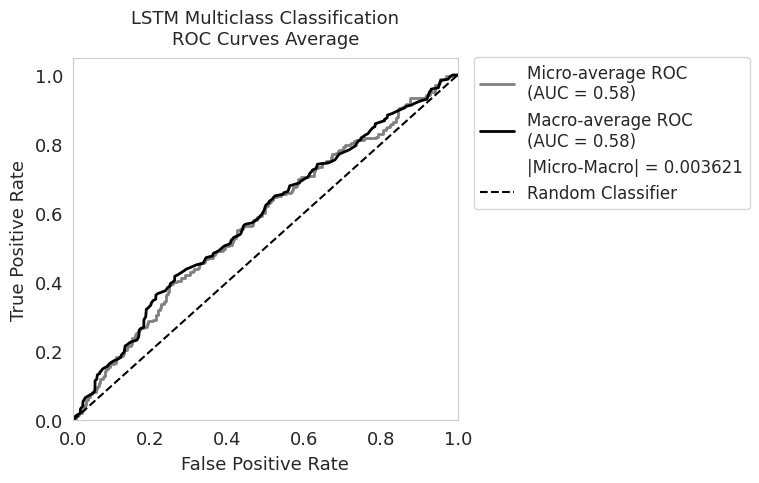

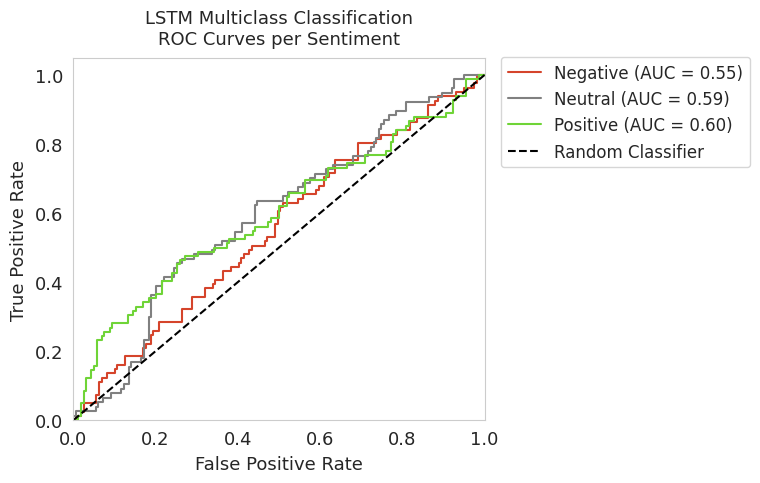

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.576068,0.019846,0.513545,0.638590,0.031899
Macro,0.579688,0.019846,0.557230,0.602146,0.011458
Weighted,0.579544,0.019929,0.517142,0.641946,0.031838
Micro-Macro Gap,0.003621,-,-,-,-



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,81.000000,77.000000,82.000000
Negative Samples,159.000000,163.000000,158.000000
AUC (roc_curve),0.551673,0.592224,0.595168
AUC (roc_auc_score),0.551673,0.592224,0.595168
95% CI Lower,0.543084,0.583626,0.586716
95% CI Upper,0.560262,0.600821,0.603621
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold,0.272919,0.370853,0.439823
Precision,0.386364,0.455696,0.481013



ROC curve average metrics saved to: /workspace/Output/LSTM/LSTM_MC/Results/roc_curve_average_metrics.csv

ROC curve analysis saved to: /workspace/Output/LSTM/LSTM_MC/Results/roc_curve_analysis.csv




In [10]:
#==================================================================================================
#                 Visualizations ROC Curve using the model prodictions 
#                              Multiclass Classification
#==================================================================================================

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Base output directory
base_dir = "/workspace/Output/LSTM/LSTM_MC"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

# Average ensemble predictions
test_pred_proba = np.mean(ensemble_logits, axis=0)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']


# ======================== ROC Curves Plotting ========================
display(HTML('<div style="font-size: 22px; font-weight: bold;">ROC Curves</div>'))

# --------- First plot: Micro and Macro average ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)

class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))

mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)

plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Multiclass Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figure_dir, 'LSTM_MC_ROC_curves_averages.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# ---------  Second plot: Per-class ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Store ROC results for reporting
roc_results = []

# Plot ROC curves for each class
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Compute confidence interval for AUC
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
    ci_lower = max(0, roc_auc - 1.96 * se)
    ci_upper = min(1, roc_auc + 1.96 * se)
    
    # Store results
    roc_results.append({
        'Class': class_name,
        'AUC': roc_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Multiclass Classification\nROC Curves per Sentiment')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
sentiment_roc_curve_path = os.path.join(figure_dir, 'LSTM_MC_ROC_curves_per_sentiment.png')
plt.savefig(sentiment_roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# ======================== Additional Statistics ========================

# ------------------- Calculate ROC Average Metrics ---------------------

def calculate_average_metrics(y_true, y_pred_proba, classes):
    """
    Calculate micro, macro, and weighted averages for ROC AUC scores.
    Also includes standard deviation of AUC scores across classes.
    """
    n_classes = len(classes)
    
    # Binarize the labels for multi-class metrics
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Initialize lists for storing metrics
    class_metrics = []
    class_auc_scores = []  # Initialize this list
    
    # Calculate metrics for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': classes[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro average (simple average of class-wise AUC scores)
    auc_macro = np.mean([m['auc'] for m in class_metrics])
    
    # Weighted average (weighted by class support)
    class_support = np.bincount(y_true)
    auc_weighted = np.average([m['auc'] for m in class_metrics], 
                            weights=class_support)
    
    # Calculate standard errors and confidence intervals
    n_samples = len(y_true)
    
    # Standard error for micro average
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    
    # Standard error for macro average
    se_macro = np.sqrt(np.var([m['auc'] for m in class_metrics]) / n_classes)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    
    # Standard error for weighted average
    se_weighted = np.sqrt(np.average([(m['auc'] * (1 - m['auc'])) for m in class_metrics], 
                                   weights=class_support) / n_samples)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)
    
    # Calculate standard deviations
    std_across_classes = np.std(class_auc_scores)
    
    return {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

# Calculate average metrics
average_metrics = calculate_average_metrics(y_test_true, test_pred_proba, range(len(label_names)))

# Create a DataFrame for average metrics
average_metrics_data = []
for avg_type in ['micro', 'macro', 'weighted']:
    metrics = average_metrics[avg_type]
    average_metrics_data.append({
        'Average Type': avg_type.capitalize(),
        'ROC AUC': f"{metrics['auc']:.6f}",
        'Standard Deviation': f"{metrics['std']:.6f}",
        '95% CI Lower': f"{metrics['ci'][0]:.6f}",
        '95% CI Upper': f"{metrics['ci'][1]:.6f}",
        'Standard Error': f"{metrics['se']:.6f}"
    })

# Add the micro-macro gap row
micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
average_metrics_data.append({
    'Average Type': 'Micro-Macro Gap',
    'ROC AUC': f"{micro_macro_gap:.6f}",
    'Standard Deviation': "-",
    '95% CI Lower': "-",
    '95% CI Upper': "-",
    'Standard Error': "-"
})

average_metrics_df = pd.DataFrame(average_metrics_data)
average_metrics_df = average_metrics_df.set_index('Average Type')

# Display the average metrics table
print("\n")
display(HTML('<div style="font-size: 22px; font-weight: bold;">Receiver Operating Characteristic (ROC) Curve Metrics</div>'))
display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
display(HTML(average_metrics_df.to_html()))

# Save average metrics to CSV
average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
average_metrics_df.to_csv(average_metrics_save_path, sep=';')

# Notes printing
print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")

# ------------- ROC Curve Detailed Analysis per Sentiments -------------

detailed_roc_results = []
for i, class_name in enumerate(label_names):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba[:, i]
    
    # Method 1: sklearn's roc_curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    
    # Method 2: Direct AUC computation
    auc_direct = auc(fpr, tpr)
    
    # Method 3: roc_auc_score
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    # Additional statistical validation
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    
    # Confidence interval for AUC
    se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
    ci_lower = max(0, auc_direct - 1.96 * se)
    ci_upper = min(1, auc_direct + 1.96 * se)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_threshold = (y_score >= optimal_threshold).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
    
    # Store results
    result = {
        'Class': class_name,
        'Total Samples': len(y_true_binary),
        'Positive Samples': n_pos,
        'Negative Samples': n_neg,
        'AUC (roc_curve)': auc_direct,
        'AUC (roc_auc_score)': auc_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Difference between methods': abs(auc_direct - auc_score),
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall
    }
    
    detailed_roc_results.append(result)

# Create a transposed DataFrame for better readability
roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T

# format float columns to a specific number of decimal places
float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
for col in float_columns:
    roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

# Save to CSV
save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
roc_analysis_df.to_csv(save_path, sep=';')

# Display in Jupyter Notebook
display(HTML("<br><b>\nROC Curve Analysis by Sentiment</b>"))
display(HTML(roc_analysis_df.to_html()))
print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
print(f"\nROC curve analysis saved to: {save_path }\n\n")

### Probability Distributions

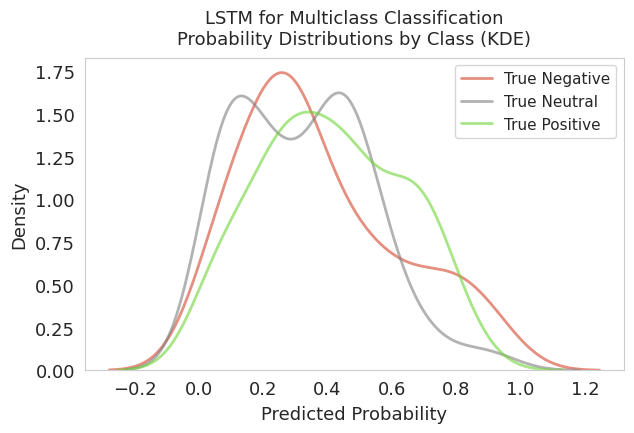

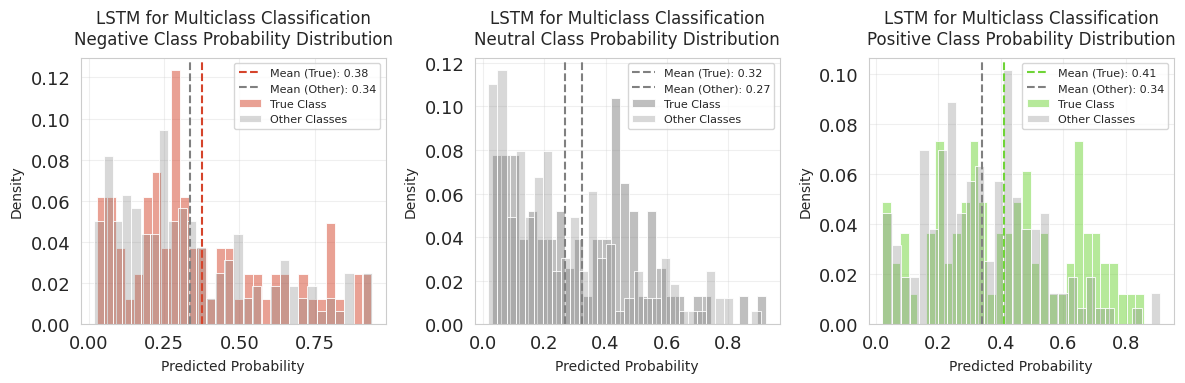

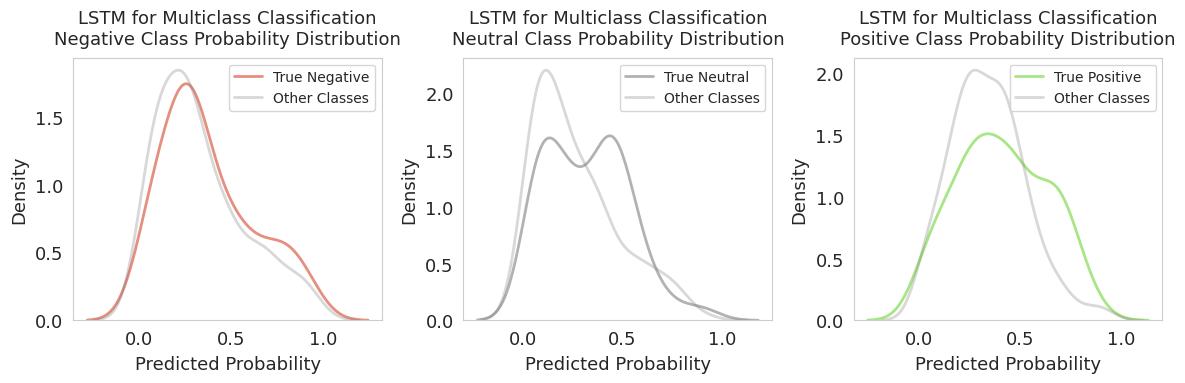

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.377173,0.245525,0.335739,0.237437,0.041434
Neutral,0.322963,0.205672,0.267193,0.211358,0.055770
Positive,0.411603,0.218714,0.341103,0.181539,0.070500


In [11]:
# ==================== Visualize Probability Distributions ====================


# --------------- KDE Plot All Sentiement ---------------

plt.figure(figsize=(6.5, 4.5))
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('LSTM for Multiclass Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'LSTM_MC_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()

# ================== Enhanced Probability Distribution Visualization ===================

plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba[:, i]
    # Get true labels for this class
    true_class = (y_test_true == i)
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[~true_class], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class].mean():.2f}')
    plt.axvline(class_probs[~true_class].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[~true_class].mean():.2f}')
    
    plt.title(f'LSTM for Multiclass Classification\n{class_name} Class Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'LSTM_MC_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[~true_class], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'LSTM for Multiclass Classification\n{class_name} Class Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'LSTM_MC_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[~true_class].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[~true_class].std():.6f}",
        'Separation': f"{class_probs[true_class].mean() - class_probs[~true_class].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices and Sentiment Distribution

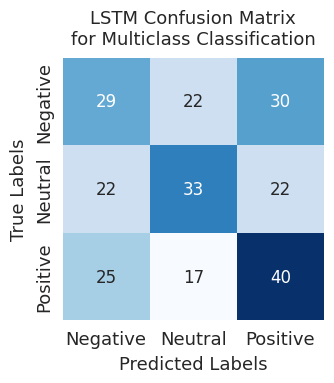

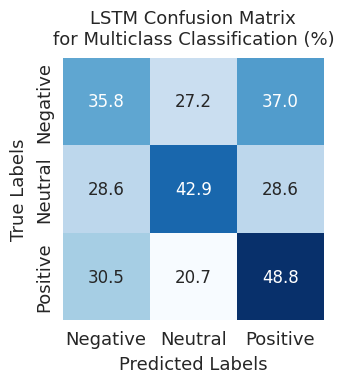


Sentiment Distribution:


,True Label,Predictions
Sentiment,,
Negative,81,76
Neutral,77,72
Positive,82,92



Sentiment Distribution table saved in: /workspace/Output/LSTM/LSTM_MC/Results LSTM_MC_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.381579,0.358025,0.369427,81.000
Neutral,0.458333,0.428571,0.442953,77.000
Positive,0.434783,0.487805,0.459770,82.000
accuracy,0.425000,0.425000,0.425000,0.425
macro avg,0.424898,0.424800,0.424050,240.000
weighted avg,0.424382,0.425000,0.423884,240.000



Additional Statistical Metrics:


,Metric,Value
0,Macro Accuracy,0.425000
1,Macro Precision,0.424898
2,Macro Recall,0.424800
3,Macro F1-Score,0.424050
4,Cohen's Kappa,0.136511



Analysis complete. Results saved in: /workspace/Output/LSTM/LSTM_MC/Results


In [12]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================


# ============== Peparing Data ================

# Using the data from ROC curve analysis
# Convert numeric predictions to string labels
y_true_str = [label_names[i] for i in y_test_true]
y_pred = np.argmax(test_pred_proba, axis=1)
y_pred_str = [label_names[i] for i in y_pred]

# Create output directory if it doesn't exist
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_statistical_metrics(y_true, y_pred, labels):
    """Compute additional statistical metrics"""
    # Create copies of input data
    y_true_copy = np.array(y_true).copy()
    y_pred_copy = np.array(y_pred).copy()
    
    label_map = {label: idx for idx, label in enumerate(labels)}
    y_true_numeric = np.array([label_map[label] for label in y_true_copy])
    y_pred_numeric = np.array([label_map[label] for label in y_pred_copy])
    
    results = {
        'Macro Accuracy': accuracy_score(y_true_numeric, y_pred_numeric, normalize=True),
        'Macro Precision': precision_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro Recall': recall_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro F1-Score': f1_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Cohen\'s Kappa': cohen_kappa_score(y_true_numeric, y_pred_numeric)        
    }
    
    return results.copy()

# ============== Confusion Matrix Visualization ================

# ------ Counts version ------
cm = confusion_matrix(y_true_str, y_pred_str, labels=label_names)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('LSTM Confusion Matrix\nfor Multiclass Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'LSTM_MC_confusion_matrix_counts.png'), 
            dpi=300, 
            bbox_inches='tight')
plt.show()

# ------ Percentage version ------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm_normalized * 100,
    annot=np.round(cm_normalized * 100, 1),
    fmt='.1f',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('LSTM Confusion Matrix\nfor Multiclass Classification (%)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'LSTM_MC_confusion_matrix_percentage.png'), 
            dpi=300, 
            bbox_inches='tight')
plt.show()

# ============== Basic Distribution Analysis ================

# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.Series(y_true_str).value_counts().reset_index()
true_label_dist.columns = ['Sentiment', 'True Label']

prediction_dist = pd.Series(y_pred_str).value_counts().reset_index()
prediction_dist.columns = ['Sentiment', 'Predictions']

# Merge the two DataFrames
distribution_table = pd.merge(true_label_dist, prediction_dist, on='Sentiment', how='outer').fillna(0)

# Reorder rows to match the desired order
distribution_table['Sentiment'] = pd.Categorical(distribution_table['Sentiment'], categories=label_names, ordered=True)
distribution_table = distribution_table.sort_values('Sentiment')

# Reset index and set Sentiment as index
distribution_table = distribution_table.reset_index(drop=True).set_index('Sentiment')

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'LSTM_MC_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", output_dir, 'LSTM_MC_Sentiment_Distribution.csv')

# Calculate accuracy
accuracy = np.mean(np.array(y_true_str) == np.array(y_pred_str))

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_true_str, y_pred_str, labels=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = compute_statistical_metrics(y_true_str, y_pred_str, label_names)

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()

def format_value(x):
    if isinstance(x, dict):
        return ', '.join([f"{k}: {v:.6f}" for k, v in x.items()])
    elif isinstance(x, (int, float)):
        return f'{x:.6f}'
    return str(x)

additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(format_value)
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)

### Early Stopping Epochs per Fold

In [13]:
#==========================================================================================
#                                 Early Stopping Epochs per Fold
#==========================================================================================
from scipy import stats
import numpy as np
import pandas as pd
import os
import json
from IPython.display import display, HTML

# Directory and configuration
output_dir = "/workspace/Output/LSTM/LSTM_MC/Models"
num_folds = 5  # Define the number of folds

# Verify directory exists
if not os.path.exists(output_dir):
    raise FileNotFoundError(f"Directory not found: {output_dir}")

# Collect epoch data for each fold
fold_epochs = []
for fold in range(1, num_folds + 1):
    es_file = os.path.join(output_dir, f'fold_{fold}', 'early_stopping.json')
    try:
        with open(es_file, 'r') as f:
            es_data = json.load(f)
        fold_epochs.append(es_data['best_epoch'] + 1)  # Add 1 because epochs are 0-indexed
    except FileNotFoundError:
        print(f"Warning: File not found for fold {fold}: {es_file}")
    except KeyError:
        print(f"Warning: 'best_epoch' not found in data for fold {fold}")
    except json.JSONDecodeError:
        print(f"Warning: Invalid JSON file for fold {fold}")

# Check if we have any data
if not fold_epochs:
    raise ValueError("No epoch data was collected from any fold")

# Calculate statistics
mean_epoch = np.mean(fold_epochs)
std_epoch = np.std(fold_epochs)
ci_epoch = stats.t.interval(0.95, len(fold_epochs)-1, loc=mean_epoch, scale=stats.sem(fold_epochs))
min_epoch = min(fold_epochs)
max_epoch = max(fold_epochs)

# Format values to 2 decimal places
mean_epoch = f"{mean_epoch:.2f}"
std_epoch = f"{std_epoch:.2f}"
ci_lower = f"{ci_epoch[0]:.2f}"
ci_upper = f"{ci_epoch[1]:.2f}"

# Create the first table
fold_table = pd.DataFrame({
    'Fold': range(1, len(fold_epochs) + 1),
    'Epochs': fold_epochs
})

# Create the statistics table
stats_table = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', '95% CI Lower', '95% CI Upper', 'Minimum', 'Maximum'],
    'Value': [mean_epoch, std_epoch, ci_lower, ci_upper, min_epoch, max_epoch]
})

# Display tables
display(HTML('<div style="font-size: 20px;">Table 1: Early Stopping Epochs per Fold</div>'))
display(HTML(fold_table.to_html(index=False)))
display(HTML('<div style="font-size: 20px;">Table 2: Early Stopping Statistics</div>'))
display(HTML(stats_table.to_html(index=False)))

Fold,Epochs
1,4
2,2
3,2
4,3
5,2


Statistic,Value
Mean,2.60
Standard Deviation,0.80
95% CI Lower,1.49
95% CI Upper,3.71
Minimum,2
Maximum,4


# LSTM - Multilabel classification

## Multilabel & text: preparing training, validation and testing datasets

In [17]:
# Extracting features (text) and labels from training DataFrame
X_train_ML = trainDf['text'].tolist()
y_train_ML = trainDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values
"""
Training Data (60%):
Features (X_train_ML) and labels (y_train_ML) extracted from the training dataset for model development.
Labels are now in multi-label format with shape (n_samples, 3) where each column represents a binary label.
"""

# Extracting features (text) and labels from validation DataFrame
X_val_ML = valDf['text'].tolist()
y_val_ML = valDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values
"""
Validation Data (20%):
Features (X_val_ML) and labels (y_val_ML) extracted from the validation dataset for model optimization.
Labels are now in multi-label format with shape (n_samples, 3).
"""

# Extracting features (text) and labels from test DataFrame
X_test_ML = testDf['text'].tolist()
y_test_ML = testDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values
"""
Test Data (20%):
Features (X_test_ML) and labels (y_test_ML) extracted from the test dataset for final performance evaluation.
Labels are now in multi-label format with shape (n_samples, 3).
"""

'\nTest Data (20%):\nFeatures (X_test_ML) and labels (y_test_ML) extracted from the test dataset for final performance evaluation.\nLabels are now in multi-label format with shape (n_samples, 3).\n'

## Metric definition for multilabel classification (the good ones)

In [18]:
## =================== Metrics Definition for Multilabel classification ===================

def ML_metric2(y_true, y_pred):
    """
    Calculate the proportion of predictions that are exactly correct or off by one.
    For a 3-class sentiment problem (0, 1, 2), count how many labels are correctly predicted
    or predicted with just one level difference.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n_samples = y_true.shape[0]
    correct_predictions = 0
    
    for i in range(n_samples):
        # Get true and predicted class indices
        true_idx = np.where(y_true[i] == 1)[0]
        pred_idx = np.where(y_pred[i] == 1)[0]
        
        # Check if we have valid indices
        if len(true_idx) == 1 and len(pred_idx) == 1:
            # Calculate absolute difference between predicted and true class
            diff = abs(true_idx[0] - pred_idx[0])
            # Count as correct if exact match or off by one
            if diff <= 1:
                correct_predictions += 1
    
    return correct_predictions / n_samples

def ML_hamming_score(y_true, y_pred):
    """
    Calculate the Hamming score (intersection over union) for multilabel classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    
    return intersection / union if union > 0 else 0

def ML_weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for multi-label classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    n_classes = y_true.shape[1]
    class_accuracies = []
    weights = []
    
    for c in range(n_classes):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        
        n_samples_class = np.sum(true_class)
        if n_samples_class == 0:
            continue
        
        weight = y_true.shape[0] / (n_classes * n_samples_class)
        class_accuracy = np.sum((true_class == 1) & (pred_class == 1)) / n_samples_class
        
        class_accuracies.append(class_accuracy)
        weights.append(weight)
    
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    return np.sum(np.array(class_accuracies) * weights)

def ML_macro_f1(y_true, y_pred):
    """
    Compute the macro F1 score for multi-label classification.
    """
    f1_scores = []
    for c in range(y_true.shape[1]):
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def ML_weighted_f1(y_true, y_pred):
    """
    Compute the weighted F1 score for multi-label classification.
    """
    f1_scores = []
    weights = []
    
    for c in range(y_true.shape[1]):
        n_samples_class = np.sum(y_true[:, c])
        if n_samples_class == 0:
            continue
        
        weight = n_samples_class / np.sum(y_true)
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        
        f1_scores.append(f1)
        weights.append(weight)
    
    return np.average(f1_scores, weights=weights)

def ML_macro_accuracy(y_true, y_pred):
    """
    Calculate macro-averaged accuracy for multi-label classification.
    """
    accuracies = []
    # Calculate accuracy for each label independently
    for c in range(y_true.shape[1]):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        class_accuracy = np.mean(true_class == pred_class)
        accuracies.append(class_accuracy)
    
    # Return average across all labels
    return np.mean(accuracies)

def ML_hamming_loss(y_true, y_pred):
    """
    Calculate Hamming loss for multi-label classification.
    """
    return hamming_loss(y_true, y_pred)

def subset_accuracy(y_true, y_pred):
    """
    Calculate subset accuracy (exact match ratio) for multilabel classification
    Returns 1 only when all labels match exactly
    """
    return np.mean(np.all(y_true == y_pred, axis=1))

## Optuna Hyperparameters Searching (bayesian method)

**Method for Selecting the Best Model**

A balanced score was calculated using the following distribution of weights:
- Weighted_f1: 40% weight on F1 score
- Normalized Loss: 30% weight on loss
- Cross-Validation Stability: 30% weight.

The `calculate_balanced_score` function computes a score ranging from 0 to 1. A value closer to 1 indicates better model performance.

In [54]:
# ====================================================================================================
#                              Optuna Hyperparameters Search for LSTM
#                                --  Multi-label classification  --
#                       Full Deterministisc Approach to Ensure Reproductibility
# ====================================================================================================

import os
import csv
import time
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import get_linear_schedule_with_warmup
import torch.nn.functional as F
from sklearn.metrics import hamming_loss

# Disable parallelism for tokenizers to better fit small training datasets
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# ======================= Seed Control for Reproducibility ========================

# Deterministic Approach
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define the output directory for Optuna
OPTUNA_OUTPUT_DIR = "/workspace/Output/LSTM/LSTM_ML/Optuna_search"
os.makedirs(OPTUNA_OUTPUT_DIR, exist_ok=True)

# Additional global settings
try:
    import torch.backends.cudnn as cudnn
    cudnn.deterministic = True
    cudnn.benchmark = False
except ImportError:
    pass

# Ensure a clean, consistent study creation
def create_deterministic_study():
    # Construct the storage path
    storage_path = f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db'
    
    # Study name remains consistent
    study_name = 'LSTM_Multilabel_Optimization'
    
    # Delete existing study if it exists
    try:
        optuna.delete_study(study_name=study_name, storage=storage_path)
    except KeyError:
        # Study doesn't exist, which is fine
        pass
    except Exception as e:
        print(f"Unexpected error deleting study: {e}")
    
    # Create a new study with consistent parameters
    study = optuna.create_study(
        direction='maximize', 
        storage=storage_path,
        study_name=study_name,
        load_if_exists=False
    )
    
    return study


# ==================== Cleaning Previous Study ====================

# Delete existing study if it exists
try:
    optuna.delete_study(
        study_name='LSTM_Multilabel_Optimization', 
        storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db'
    )
except Exception as e:
    print(f"Error deleting existing study: {e}")

# Create a new study
study = optuna.create_study(
    direction='maximize', 
    storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db',
    study_name='LSTM_Sentiment_Optimization_' + str(int(time.time())),  # Add timestamp to make unique
    load_if_exists=False
)

# ======================= Balanced Score ========================

def balanced_score(y_true, y_pred, loss):
    """
    Balanced score metric:
    40% Weighted F1 Score
    30% Normalized Loss
    30% CV Stability
    """
    # Ensure inputs are numpy arrays with correct shape for multilabel
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    
    # Reshape if needed
    if len(y_true.shape) == 1:
        y_true = y_true.reshape(-1, 1)
    if len(y_pred.shape) == 1:
        y_pred = y_pred.reshape(-1, 1)
    
    # Convert probabilities to binary predictions if needed
    if not np.array_equal(y_pred, y_pred.astype(bool)):
        y_pred = (y_pred > 0.5).astype(float)
    
    # Weighted F1 Score (40%)
    f1 = ML_weighted_f1(y_true, y_pred) * 0.4
    
    # Normalize Loss (30%)
    max_loss = 10  # Set a reasonable maximum loss value
    normalized_loss = max(0, 1 - (loss / max_loss)) * 0.3
    
    # Cross-Validation Stability (30%)
    cv_stability = 1.0 * 0.3
    
    return f1 + normalized_loss + cv_stability


# ======================= Text Preparation ========================

class Tokenizer:
    """Simple tokenizer class"""
    def __init__(self, texts, max_words):
        self.max_words = max_words
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.word_counts = {}
        
        # Build vocabulary
        self.build_vocab(texts)
    
    def build_vocab(self, texts):
        """Build vocabulary from texts"""
        # Count words
        for text in texts:
            for word in str(text).lower().split():
                self.word_counts[word] = self.word_counts.get(word, 0) + 1
        
        # Sort by frequency and take top max_words
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (word, _) in enumerate(sorted_words[:self.max_words-2], start=2):
            self.word2idx[word] = i
            self.idx2word[i] = word
    
    def encode(self, text):
        """Convert text to token ids"""
        return [self.word2idx.get(word.lower(), 1) for word in str(text).split()]
    
    def decode(self, ids):
        """Convert token ids back to text"""
        return ' '.join([self.idx2word.get(id_, '<unk>') for id_ in ids])
    
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    """Dataset for multilabel text classification"""
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        # Tokenize text
        tokens = self.tokenizer.encode(self.texts[idx])
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        
        # Pad tokens
        tokens = tokens + [0] * (self.max_length - len(tokens))
        
        # Convert to tensor - ensure labels are float for BCE loss
        tokens = torch.tensor(tokens, dtype=torch.long)
        labels = torch.tensor(self.labels[idx], dtype=torch.float)  # Changed to float
        
        return tokens, labels


# ======================= Model Definition: LSTM-based Architecture ========================

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return logits
        
        return output


# ======================= Preparing Data ========================

def prepare_data(X_train, y_train, X_val, y_val, max_length, max_words, trial_number=None):
    """
    Prepare data for LSTM multilabel model
    """
    # Create tokenizer
    tokenizer = Tokenizer(X_train + X_val, max_words=max_words)
    
    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, max_length)
    val_dataset = TextDataset(X_val, y_val, tokenizer, max_length)
    
    # binary matrix
    vocab_size = len(tokenizer)
    num_classes = y_train.shape[1]  # Number of labels in multilabel case
    
    # Modify print statements to include trial number
    if trial_number is not None:
        print(f"Trial number {trial_number}")
    
    return train_dataset, val_dataset, tokenizer, vocab_size, num_classes

# ======================= Metric Calculations for Evaluation =======================
def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive multilabel classification metrics
    
    Args:
        y_true (torch.Tensor): True labels
        y_pred (torch.Tensor): Predicted probabilities
    
    Returns:
        dict: Comprehensive metrics for multilabel classification
    """
    # Apply sigmoid if not already applied
    if not torch.is_floating_point(y_pred):
        y_pred = torch.sigmoid(y_pred)
        
    # Convert predictions using threshold of 0.5
    y_pred_labels = (y_pred > 0.5).float().cpu().numpy()
    y_true_labels = y_true.cpu().numpy()
    
    # Define metric calculation with different averaging methods
    metrics = {
        'accuracy': {
            'macro': lambda: accuracy_score(y_true_labels.ravel(), y_pred_labels.ravel()),
            'micro': lambda: accuracy_score(y_true_labels.ravel(), y_pred_labels.ravel()),
            'weighted_accuracy': ML_weighted_accuracy(y_true_labels, y_pred_labels)},
        'f1': {'macro': ML_macro_f1(y_true_labels, y_pred_labels),
            'micro': f1_score(y_true_labels.ravel(), y_pred_labels.ravel(), average='micro'),
            'weighted': ML_weighted_f1(y_true_labels, y_pred_labels)},
        'precision': {
            'macro': precision_score(y_true_labels,y_pred_labels, average='macro', zero_division=0),
            'micro': precision_score(y_true_labels, y_pred_labels, average='micro', zero_division=0),
            'weighted': precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)},
        'recall': {
            'macro': recall_score(y_true_labels, y_pred_labels, average='macro', zero_division=0),
            'micro': recall_score(y_true_labels, y_pred_labels, average='micro', zero_division=0),
            'weighted': recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=0)},
        'additional_metrics': {
            'hamming_score': ML_hamming_score(y_true_labels, y_pred_labels),
            'hamming_loss': ML_hamming_loss(y_true_labels, y_pred_labels),
            'metric2': ML_metric2(y_true_labels, y_pred_labels)
        }
    }
    
    # Convert lambda functions to actual values
    flattened_metrics = {}
    for category, metric_dict in metrics.items():
        for metric_name, metric_value in metric_dict.items():
            if callable(metric_value):
                try:
                    flattened_metrics[f'{category} ({metric_name})'] = metric_value()
                except Exception as e:
                    flattened_metrics[f'{category} ({metric_name})'] = float('nan')
            else:
                flattened_metrics[f'{category} ({metric_name})'] = metric_value
    
    return flattened_metrics


# ======================= Saving Trial Results =======================

def save_trial_results(trial_number, params, metrics, balanced_score, output_dir):
    """
    Save trial results to a CSV file, ensuring one row per trial
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file path
    results_file = os.path.join(output_dir, 'optuna_trial_results.csv')
    
    # Check if file exists to determine whether to write headers
    file_exists = os.path.exists(results_file)
    
    # Open file in append mode
    with open(results_file, 'a', newline='') as csvfile:
        # Combine params and metrics
        combined_results = {**params, **metrics}
        
        # Create CSV writer
        fieldnames = ['trial_number', 'balanced_score'] + list(combined_results.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, delimiter=';')
        
        # Write headers if file is new
        if not file_exists:
            writer.writeheader()
        
        # Write trial results (only one row)
        row_data = {
            'trial_number': trial_number, 
            'balanced_score': balanced_score,
            **combined_results
        }
        writer.writerow(row_data)
        
# ======================= Training & Validation ========================

def train_and_evaluate(model, train_dataset, val_dataset, 
                      learning_rate, batch_size, epochs, weight_decay,
                      warmup_steps=0):
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Optimizer 
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=learning_rate, 
        weight_decay=weight_decay
    )
    
    # Learning rate scheduler with warmup
    total_training_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=warmup_steps, 
        num_training_steps=total_training_steps
    )
    
    criterion = nn.BCEWithLogitsLoss()
    
    # Early Stopping Parameters
    patience = 3
    min_delta = 0.01  # Minimum change to qualify as an improvement
    best_val_score = 0
    patience_counter = 0
    best_metrics = {}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.float())
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Validation phase
        model.eval()
        all_preds = []
        all_labels = []
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                val_loss = criterion(outputs, batch_y.float())
                total_val_loss += val_loss.item()

                probs = torch.sigmoid(outputs)
                all_preds.append(outputs)
                all_labels.append(batch_y)
        
        # Concatenate predictions and labels
        all_preds = torch.cat(all_preds, dim=0)
        all_labels = torch.cat(all_labels, dim=0)
        
        # Calculate metrics
        metrics = calculate_metrics(all_labels, all_preds)
        
        # Compute balanced score
        avg_val_loss = total_val_loss / len(val_loader)
        fold_score = balanced_score(all_labels, all_preds, avg_val_loss)
        
        # Early Stopping Logic
        if fold_score > best_val_score + min_delta:
            best_val_score = fold_score
            best_metrics = metrics
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Stop training if no improvement
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    return best_val_score, best_metrics


# ======================= Objective Function for Optuna Optimization =======================

def objective(trial, X_train, y_train, X_val, y_val):
    # Hyperparameters to optimize
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.002, 0.003])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    hidden_size = trial.suggest_categorical('hidden_size', [128, 192, 256])
    num_layers = trial.suggest_int('num_layers', 1, 2)
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4])
    weight_decay = trial.suggest_categorical('weight_decay', [0.05, 0.1, 0.2])
    epochs = trial.suggest_categorical('epochs', [4, 7, 10, 13])
    max_length = trial.suggest_categorical('max_length', [22, 26])
    max_words = trial.suggest_categorical('max_words', [1500, 2000, 2500])
    warmup_steps = trial.suggest_categorical('warmup_steps', [250, 500, 750])
    embedding_dim = trial.suggest_categorical('embedding_dim', [128, 144, 160])
    
    try:
        # Prepare data with trial number
        (train_dataset, val_dataset, tokenizer, 
         vocab_size, num_classes) = prepare_data(
            X_train, y_train, X_val, y_val, 
            max_length=max_length,
            max_words=max_words,
            trial_number=trial.number  # Pass the trial number
        )
        
        # Model setup
        model = LSTMModel(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes,
            dropout=dropout_rate
        )

        
        # Train and evaluate
        val_score, metrics = train_and_evaluate(
            model, 
            train_dataset, val_dataset,
            learning_rate, batch_size, epochs, weight_decay,
            warmup_steps=warmup_steps
        )
        
        # Save trial results
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics=metrics or {},  # Use empty dict if metrics is None
            balanced_score=val_score,
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        return val_score
    
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        import traceback
        traceback.print_exc()
        
        # Save error information
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics={'error': str(e)},
            balanced_score=float('-inf'),
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        return float('-inf')
    
    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        import traceback
        traceback.print_exc()  # Print full traceback for more detailed error info
        
        # Save minimal information for failed trials
        save_trial_results(
            trial_number=trial.number,
            params={
                'learning_rate': learning_rate,
                'batch_size': batch_size,
                'hidden_size': hidden_size,
                'num_layers': num_layers,
                'dropout_rate': dropout_rate,
                'weight_decay': weight_decay,
                'epochs': epochs,
                'max_length': max_length,
                'max_words': max_words,
                'warmup_steps': warmup_steps,
                'embedding_dim': embedding_dim
            },
            metrics={'error': str(e)},
            balanced_score=float('-inf'),
            output_dir=OPTUNA_OUTPUT_DIR
        )
        
        # Return a low score to indicate failure
        return float('-inf')

        
# =============== Main Function to Run Optuna Optimization Study and Save Results ===============

def main(trainDf, valDf):

    # Extract data
    X_train = X_train_ML
    y_train = y_train_ML
    X_val = X_val_ML
    y_val = y_val_ML
    
    # Ensure a clean start for the CSV
    results_file = os.path.join(OPTUNA_OUTPUT_DIR, 'optuna_trial_results.csv')
    if os.path.exists(results_file):
        os.remove(results_file)
        
    # Create a deterministic study
    study = optuna.create_study(
        direction='maximize', 
        storage=f'sqlite:///{OPTUNA_OUTPUT_DIR}/optuna_lstm.db',
        study_name='LSTM_Multilabel_Optimization',
        load_if_exists=False
    )
    
    # Partial function to pass additional arguments
    def objective_wrapper(trial):
        return objective(trial, X_train, y_train, X_val, y_val)
    
    # Run the optimization
    study.optimize(objective_wrapper, n_trials=35)
    
    # Print and save best parameters
    print(f'Best trial: {study.best_trial.number}')
    trial = study.best_trial
    
    print(f'  Value: {trial.value}')
    print('  Params: ')
    best_params = {}
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        best_params[key] = value
    
    # Save best parameters to JSON
    best_params_path = os.path.join(OPTUNA_OUTPUT_DIR, 'best_params.json')
    with open(best_params_path, 'w') as f:
        json.dump(best_params, f, indent=4)
    
    print(f'\nBest parameters saved to {best_params_path}')
        
    return best_params


if __name__ == '__main__':
    best_params = main(trainDf, valDf)
    pass

[I 2025-01-12 09:43:29,587] A new study created in RDB with name: LSTM_Sentiment_Optimization_1736675009
[I 2025-01-12 09:43:29,638] A new study created in RDB with name: LSTM_Multilabel_Optimization


Trial number 0


[I 2025-01-12 09:43:32,287] Trial 0 finished with value: 0.7251023283341217 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 13, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 0 with value: 0.7251023283341217.


Early stopping triggered after 10 epochs
Trial number 1


[I 2025-01-12 09:43:36,093] Trial 1 finished with value: 0.7610759104148549 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 10 epochs
Trial number 2


[I 2025-01-12 09:43:38,164] Trial 2 finished with value: 0.5794746794700623 and parameters: {'learning_rate': 0.002, 'batch_size': 16, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 7, 'max_length': 26, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 144}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 3


[I 2025-01-12 09:43:39,560] Trial 3 finished with value: 0.5793411697149277 and parameters: {'learning_rate': 0.002, 'batch_size': 16, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 13, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 4


[I 2025-01-12 09:43:40,369] Trial 4 finished with value: 0.5791532673686743 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.4, 'weight_decay': 0.2, 'epochs': 13, 'max_length': 26, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 144}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 5


[I 2025-01-12 09:43:42,769] Trial 5 finished with value: 0.5793318191170692 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 6


[I 2025-01-12 09:43:44,012] Trial 6 finished with value: 0.5791896369457245 and parameters: {'learning_rate': 0.001, 'batch_size': 16, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.2, 'weight_decay': 0.05, 'epochs': 4, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 750, 'embedding_dim': 144}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 7


[I 2025-01-12 09:43:46,848] Trial 7 finished with value: 0.7285670204416639 and parameters: {'learning_rate': 0.003, 'batch_size': 8, 'hidden_size': 256, 'num_layers': 1, 'dropout_rate': 0.2, 'weight_decay': 0.2, 'epochs': 7, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 128}. Best is trial 1 with value: 0.7610759104148549.


Trial number 8


[I 2025-01-12 09:43:48,248] Trial 8 finished with value: 0.5794688348472119 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.2, 'epochs': 4, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 9


[I 2025-01-12 09:43:49,307] Trial 9 finished with value: 0.5791921484470367 and parameters: {'learning_rate': 0.002, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.2, 'weight_decay': 0.1, 'epochs': 4, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 500, 'embedding_dim': 128}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 4 epochs
Trial number 10


[I 2025-01-12 09:43:54,583] Trial 10 finished with value: 0.7447419020940385 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 9 epochs
Trial number 11


[I 2025-01-12 09:44:00,362] Trial 11 finished with value: 0.7546586224260219 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Early stopping triggered after 10 epochs
Trial number 12


[I 2025-01-12 09:44:06,120] Trial 12 finished with value: 0.7519542962910601 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Trial number 13


[I 2025-01-12 09:44:11,787] Trial 13 finished with value: 0.7475745179030036 and parameters: {'learning_rate': 0.001, 'batch_size': 8, 'hidden_size': 128, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 26, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 1 with value: 0.7610759104148549.


Trial number 14


[I 2025-01-12 09:44:15,517] Trial 14 finished with value: 0.7670632509590335 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 15


[I 2025-01-12 09:44:18,465] Trial 15 finished with value: 0.7260466146773525 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 128}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 8 epochs
Trial number 16


[I 2025-01-12 09:44:22,215] Trial 16 finished with value: 0.7563146937226123 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 17


[I 2025-01-12 09:44:24,672] Trial 17 finished with value: 0.742943233454932 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 18


[I 2025-01-12 09:44:27,395] Trial 18 finished with value: 0.7461010836908979 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 7, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 144}. Best is trial 14 with value: 0.7670632509590335.


Trial number 19


[I 2025-01-12 09:44:31,217] Trial 19 finished with value: 0.7407786349130399 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.2, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 750, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 20


[I 2025-01-12 09:44:33,563] Trial 20 finished with value: 0.743192130771956 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 1, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 250, 'embedding_dim': 128}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 10 epochs
Trial number 21


[I 2025-01-12 09:44:37,380] Trial 21 finished with value: 0.7495826072553766 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 10 epochs
Trial number 22


[I 2025-01-12 09:44:41,193] Trial 22 finished with value: 0.7546911686085767 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 23


[I 2025-01-12 09:44:44,656] Trial 23 finished with value: 0.7447558092467206 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 9 epochs
Trial number 24


[I 2025-01-12 09:44:48,407] Trial 24 finished with value: 0.7610687522669783 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 25


[I 2025-01-12 09:44:51,777] Trial 25 finished with value: 0.7550824924888033 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 9 epochs
Trial number 26


[I 2025-01-12 09:44:55,290] Trial 26 finished with value: 0.7323255610900099 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.05, 'epochs': 13, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 9 epochs
Trial number 27


[I 2025-01-12 09:44:58,045] Trial 27 finished with value: 0.7440470188273003 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 7, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 28


[I 2025-01-12 09:44:59,701] Trial 28 finished with value: 0.6015141757140184 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.2, 'epochs': 4, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 500, 'embedding_dim': 144}. Best is trial 14 with value: 0.7670632509590335.


Trial number 29


[I 2025-01-12 09:45:01,600] Trial 29 finished with value: 0.5796611009836197 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 13, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 750, 'embedding_dim': 128}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 4 epochs
Trial number 30


[I 2025-01-12 09:45:02,706] Trial 30 finished with value: 0.5794353058934212 and parameters: {'learning_rate': 0.003, 'batch_size': 32, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.4, 'weight_decay': 0.1, 'epochs': 10, 'max_length': 22, 'max_words': 2000, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 4 epochs
Trial number 31


[I 2025-01-12 09:45:06,550] Trial 31 finished with value: 0.7421346032931306 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 32


[I 2025-01-12 09:45:10,392] Trial 32 finished with value: 0.7464936776932463 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Early stopping triggered after 10 epochs
Trial number 33


[I 2025-01-12 09:45:14,233] Trial 33 finished with value: 0.7479248066316873 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 2500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Trial number 34


[I 2025-01-12 09:45:18,044] Trial 34 finished with value: 0.7622092399770182 and parameters: {'learning_rate': 0.003, 'batch_size': 16, 'hidden_size': 192, 'num_layers': 2, 'dropout_rate': 0.3, 'weight_decay': 0.05, 'epochs': 10, 'max_length': 22, 'max_words': 1500, 'warmup_steps': 250, 'embedding_dim': 160}. Best is trial 14 with value: 0.7670632509590335.


Best trial: 14
  Value: 0.7670632509590335
  Params: 
    learning_rate: 0.003
    batch_size: 16
    hidden_size: 192
    num_layers: 2
    dropout_rate: 0.3
    weight_decay: 0.05
    epochs: 10
    max_length: 22
    max_words: 2500
    warmup_steps: 250
    embedding_dim: 160

Best parameters saved to /workspace/Output/LSTM/LSTM_ML/Optuna_search/best_params.json


## Testing Process Using Optuna's Best Hyperparameters

In [55]:
# ==========================================================================================
#              LSTM Model Using the Best Hyperparameters Obtained from Optuna
#                                  Multilabel Classification
# ==========================================================================================

from IPython.display import display, HTML
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import KFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score)
import numpy as np
from scipy import stats
import pandas as pd
import os
import json
import logging
from pathlib import Path
import time
from datetime import datetime
import copy

# Disable parallelism for tokenizers to better fit small training datasets
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

class Config:
    MODEL_NAME = "LSTM"
    OUTPUT_DIR = "/workspace/Output/LSTM/LSTM_ML"
    NUM_FOLDS = 5
    NUM_CLASSES = 3  # Number of labels for multilabel (A1_positive, A2_negative, A3_neutral)
    SEED = 42

    def __init__(self):
        best_params_path = os.path.join(self.OUTPUT_DIR, 'Optuna_search', 'best_params.json')
        try:
            with open(best_params_path, 'r') as f:
                best_params = json.load(f)
        except (FileNotFoundError, json.JSONDecodeError) as e:
            raise ValueError(f"Could not load best parameters from {best_params_path}: {e}")

        # Load hyperparameters from Optuna optimization
        self.LEARNING_RATE = best_params['learning_rate']
        self.NUM_EPOCHS = best_params['epochs']
        self.BATCH_SIZE = best_params['batch_size']
        self.WARMUP_STEPS = best_params['warmup_steps']
        self.WEIGHT_DECAY = best_params['weight_decay']
        self.WARMUP_RATIO = 0.1
        self.MAX_LENGTH = best_params['max_length']
        self.EMBEDDING_DIM = best_params['embedding_dim']
        self.HIDDEN_DIM = best_params['hidden_size']
        self.NUM_LAYERS = best_params['num_layers']
        self.DROPOUT = best_params['dropout_rate']
        self.MAX_WORDS = best_params['max_words']
        
        # Training settings
        self.EARLY_STOPPING_PATIENCE = 3
        self.EARLY_STOPPING_THRESHOLD = 0.01
        self.EVALUATION_STRATEGY = "epoch"
        self.METRIC_FOR_BEST_MODEL = "custom_metric"
        
        # Multilabel specific settings
        self.ACTIVATION = "sigmoid"  # Changed from softmax to sigmoid for multilabel
        self.OPTIMIZER = "adamw"
        self.LOSS_FUNCTION = "bce"  # Binary Cross Entropy for multilabel
        self.THRESHOLD = 0.5  # Decision threshold for converting probabilities to binary predictions
        self.LABEL_COLUMNS = ['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']  # Names of label columns
        
        print("Loaded Configuration:")
        for key, value in best_params.items():
            print(f"{key.upper()}: {value}")

        # Set random seeds
        torch.manual_seed(Config.SEED)
        torch.cuda.manual_seed(Config.SEED)
        np.random.seed(Config.SEED)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        tokens = self.tokenizer.encode(text)
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        tokens = torch.tensor(tokens, dtype=torch.long)
        # Convert labels to float for multilabel
        label = torch.tensor(label, dtype=torch.float)
        return {'input_ids': tokens, 'labels': label}

class Tokenizer:
    def __init__(self, texts, max_words):
        self.max_words = max_words
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.word_counts = {}
        self.build_vocab(texts)

    def build_vocab(self, texts):
        for text in texts:
            for word in str(text).lower().split():
                self.word_counts[word] = self.word_counts.get(word, 0) + 1
        sorted_words = sorted(self.word_counts.items(), key=lambda x: x[1], reverse=True)
        for i, (word, _) in enumerate(sorted_words[:self.max_words-2], start=2):
            self.word2idx[word] = i
            self.idx2word[i] = word

    def encode(self, text):
        return [self.word2idx.get(word.lower(), 1) for word in str(text).split()]

    def decode(self, ids):
        return ' '.join([self.idx2word.get(id_, '<unk>') for id_ in ids])

    def __len__(self):
        return len(self.word2idx)

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        self.dropout = nn.Dropout(dropout)
        # Adjust fc layer input dimension to match hidden_dim
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Use average pooling instead of concatenation
        avg_pool = torch.mean(lstm_out, dim=1)
        
        # Apply dropout
        avg_pool = self.dropout(avg_pool)
        
        # Pass through linear layer
        logits = self.fc(avg_pool)
        
        # Add scaling factor for more spread in probabilities
        return logits


class CustomEarlyStoppingCallback:
    def __init__(self, patience=3, threshold=0.01):
        self.patience = patience
        self.threshold = threshold
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model = None
        self.best_metrics = None
        self.best_epoch = None

    def compute_balanced_score(self, metrics, history=None):
        weighted_f1 = metrics.get('F1-Score (Weighted)', 0)
        loss = metrics.get('loss', 0)
        normalized_loss = max(0, min(1, 1 - (loss / 4)))
        stability_score = 0
        if history and len(history) >= 2:
            recent_f1s = [h.get('F1-Score (Weighted)', 0) for h in history[-2:]]
            stability_score = 1 - abs(recent_f1s[1] - recent_f1s[0])
        balanced_score = (
            0.4 * weighted_f1 + 0.3 * normalized_loss + 0.3 * stability_score
        )
        return balanced_score

    def __call__(self, val_metrics, model, epoch):
        self.validation_history = getattr(self, 'validation_history', [])
        self.validation_history.append(val_metrics)
        score = self.compute_balanced_score(
            val_metrics,
            self.validation_history if len(self.validation_history) > 1 else None
        )
        if self.best_score is None:
            self.best_score = score
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_metrics = val_metrics.copy()
            self.best_epoch = epoch
        elif score > self.best_score + self.threshold:
            self.best_score = score
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_metrics = val_metrics.copy()
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

class ModelTrainer:
    def __init__(self, model, config, device, logger):
        self.model = model
        self.config = config
        self.device = device
        self.logger = logger
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        self.history = {
            'loss': [], 'val_loss': [],
            'metrics': [], 'val_metrics': []
        }

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        for batch in train_loader:
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['labels'].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(input_ids)
            loss = self.criterion(outputs, labels.float())
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            preds = (outputs > 0.5).float()  # Threshold at 0.5 for multilabel
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert to numpy arrays for metric calculation
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate metrics
        metrics = {
            'loss': total_loss / len(train_loader),
            'Accuracy (Macro)': ML_macro_accuracy(all_labels, all_preds),
            'Accuracy (Micro)': accuracy_score(all_labels.ravel(), all_preds.ravel()),
            'Accuracy (Weighted)': ML_weighted_accuracy(all_labels, all_preds),
            'Precision (Macro)': precision_score(all_labels, all_preds, average='macro', zero_division=0),
            'Precision (Micro)': precision_score(all_labels, all_preds, average='micro', zero_division=0),
            'Precision (Weighted)': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Recall (Macro)': recall_score(all_labels, all_preds, average='macro', zero_division=0),
            'Recall (Micro)': recall_score(all_labels, all_preds, average='micro', zero_division=0),
            'Recall (Weighted)': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
            'F1-Score (Macro)': f1_score(all_labels, all_preds, average='macro', zero_division=0),
            'F1-Score (Micro)': f1_score(all_labels, all_preds, average='micro', zero_division=0),
            'F1-Score (Weighted)': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
            'ML_Metric2': ML_metric2(all_labels, all_preds),
            'Hamming_Score': ML_hamming_score(all_labels, all_preds),
            'Hamming_Loss': ML_hamming_loss(all_labels, all_preds),
            'Subset_Accuracy': subset_accuracy(all_labels, all_preds)
        }
        
        self.history['loss'].append(metrics['loss'])
        self.history['metrics'].append(metrics)
        return metrics

    def evaluate(self, val_loader):
        """Evaluate the model"""
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels.float())
                total_loss += loss.item()
                preds = (outputs > 0.5).float()  # Threshold at 0.5 for multilabel
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Convert to numpy arrays for metric calculation
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # Calculate comprehensive metrics
        metrics = {
            'loss': total_loss / len(val_loader),
            'Accuracy (Macro)': ML_macro_accuracy(all_labels, all_preds),
            'Accuracy (Micro)': accuracy_score(all_labels.ravel(), all_preds.ravel()),
            'Accuracy (Weighted)': ML_weighted_accuracy(all_labels, all_preds),
            'Precision (Macro)': precision_score(all_labels, all_preds, average='macro', zero_division=0),
            'Precision (Micro)': precision_score(all_labels, all_preds, average='micro', zero_division=0),
            'Precision (Weighted)': precision_score(all_labels, all_preds, average='weighted', zero_division=0),
            'Recall (Macro)': recall_score(all_labels, all_preds, average='macro', zero_division=0),
            'Recall (Micro)': recall_score(all_labels, all_preds, average='micro', zero_division=0),
            'Recall (Weighted)': recall_score(all_labels, all_preds, average='weighted', zero_division=0),
            'F1-Score (Macro)': f1_score(all_labels, all_preds, average='macro', zero_division=0),
            'F1-Score (Micro)': f1_score(all_labels, all_preds, average='micro', zero_division=0),
            'F1-Score (Weighted)': f1_score(all_labels, all_preds, average='weighted', zero_division=0),
            'ML_Metric2': ML_metric2(all_labels, all_preds),
            'Hamming_Score': ML_hamming_score(all_labels, all_preds),
            'Hamming_Loss': ML_hamming_loss(all_labels, all_preds),
            'Subset_Accuracy': subset_accuracy(all_labels, all_preds)
        }

        self.history['val_loss'].append(metrics['loss'])
        self.history['val_metrics'].append(metrics)
        return metrics

class EnsembleTrainer:
    """Enhanced ensemble trainer with more comprehensive metrics tracking"""
    def __init__(self, config, device, logger):
        self.config = config
        self.device = device
        self.logger = logger
        self.models = []
        self.tokenizer = None
        self.results_manager = ResultsManager(config.OUTPUT_DIR)
        # Enhanced metrics tracking
        self.validation_history = []
        self.training_history = []
        self.fold_metrics = []
        self.early_stopping_info = []
        self.oof_predictions = []
        self.oof_true_labels = []
        self.best_fold_index = None
        self.best_macro_f1 = float('-inf')
        self.best_fold_epoch = None
        self.early_stopping_callbacks = []
        self.training_history = []
        self.validation_history = []

    def train_fold(self, fold_idx, train_dataset, val_dataset, tokenizer):
        """Train a model for one fold with enhanced metrics tracking"""
        if self.tokenizer is None:
            self.tokenizer = tokenizer
            self.results_manager.tokenizer = tokenizer

            
        fold_training_history = []
        fold_validation_history = []
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=self.collate_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            collate_fn=self.collate_fn
        )

        # Initialize model
        model = LSTMModel(
            vocab_size=len(tokenizer),
            embedding_dim=self.config.EMBEDDING_DIM,
            hidden_dim=self.config.HIDDEN_DIM,
            num_layers=self.config.NUM_LAYERS,
            num_classes=self.config.NUM_CLASSES,
            dropout=self.config.DROPOUT
        ).to(self.device)

        # Initialize trainer
        trainer = ModelTrainer(model, self.config, self.device, self.logger)

        # Initialize callbacks
        early_stopping_callback = CustomEarlyStoppingCallback(
            patience=self.config.EARLY_STOPPING_PATIENCE,
            threshold=self.config.EARLY_STOPPING_THRESHOLD
        )
        while len(self.early_stopping_callbacks) <= fold_idx:
            self.early_stopping_callbacks.append(None)
        self.early_stopping_callbacks[fold_idx] = early_stopping_callback

        # Training loop
        best_val_f1 = 0
        best_model = None
        best_metrics = None
        for epoch in range(self.config.NUM_EPOCHS):
            # Train
            train_metrics = trainer.train_epoch(train_loader)
            fold_training_history.append({**train_metrics, 'epoch': epoch, 'fold': fold_idx})

            # Evaluate
            val_metrics = trainer.evaluate(val_loader)
            fold_validation_history.append({**val_metrics, 'epoch': epoch, 'fold': fold_idx})

            # Logging
            self.logger.info(
                f"Fold {fold_idx + 1}, Epoch {epoch + 1}/{self.config.NUM_EPOCHS} - "
                f"Train Loss: {train_metrics['loss']:.4f}, "
                f"Val Loss: {val_metrics['loss']:.4f}, "
                f"Val F1: {val_metrics['F1-Score (Macro)']:.4f}"
            )

            # Early stopping check
            if early_stopping_callback(val_metrics, model, epoch):
                self.logger.info(f"Early stopping triggered at epoch {epoch + 1}")
                break

            # Track best model
            if val_metrics['F1-Score (Macro)'] > best_val_f1:
                best_val_f1 = val_metrics['F1-Score (Macro)']
                best_model = copy.deepcopy(model.state_dict())
                best_metrics = val_metrics

        # Load best model
        if best_model is not None:
            model.load_state_dict(best_model)
        self.models.append(model)
        
        # training and validation hsitory
        self.training_history.append(fold_training_history)
        self.validation_history.extend(fold_validation_history)

        # Store predictions for OOF evaluation
        val_predictions = self.predict_fold(model, val_loader)
        self.oof_predictions.extend(val_predictions['predictions'])
        self.oof_true_labels.extend(val_dataset.labels)

        # Update best fold tracking
        if best_val_f1 > self.best_macro_f1:
            self.best_macro_f1 = best_val_f1
            self.best_fold_index = fold_idx
            self.best_fold_epoch = early_stopping_callback.best_epoch

        # Save fold results
        self.save_fold_results(
            fold_idx, model, trainer.history, best_metrics, early_stopping_callback
        )

    
        return best_metrics

    @staticmethod
    def collate_fn(batch):
        """Collate function for DataLoader"""
        input_ids = [item['input_ids'] for item in batch]
        labels = torch.stack([item['labels'] for item in batch])
        # Pad sequences
        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
        return {
            'input_ids': input_ids,
            'labels': labels
        }

    def predict_fold(self, model, dataloader):
        """Make predictions for a single fold"""
        model.eval()
        all_predictions = []
        all_probabilities = []
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                outputs = model(input_ids)
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()
                all_predictions.extend(preds.cpu().numpy())
                all_probabilities.extend(probs.cpu().numpy())
        return {
            'predictions': np.array(all_predictions),
            'probabilities': np.array(all_probabilities)
        }

    def generate_test_evaluation_table(self, y_test, ensemble_predictions):
        """Generate evaluation table for test results"""
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_probs = ensemble_predictions['individual_probabilities']
        ensemble_preds = ensemble_predictions['predictions']
    
        def compute_fold_metrics(y_true, y_pred):
            """Compute comprehensive metrics for a single fold"""
            return {
                'Accuracy (Macro)': ML_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': accuracy_score(y_true.ravel(), y_pred.ravel()),
                'Accuracy (Weighted)': ML_weighted_accuracy(y_true, y_pred),
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                'ML_Metric2': ML_metric2(y_true, y_pred),
                'Hamming_Score': ML_hamming_score(y_true, y_pred),
                'Hamming_Loss': ML_hamming_loss(y_true, y_pred),
                'Subset_Accuracy': subset_accuracy(y_true, y_pred)
            }
    
        # Compute metrics for individual folds
        individual_metrics = []
        for fold_preds in individual_preds:
            fold_metrics = compute_fold_metrics(np.array(y_test), fold_preds)
            individual_metrics.append(fold_metrics)
    
        # Compute ensemble metrics
        ensemble_metrics = compute_fold_metrics(np.array(y_test), ensemble_preds)
    
        # Prepare results table
        results_data = []
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [metrics[metric_name] for metrics in individual_metrics]
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            # Compute confidence intervals
            ci = stats.t.interval(
                0.95, len(fold_values)-1, loc=mean_value, scale=stats.sem(fold_values)
            )
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': ci[0],
                'CI Upper': ci[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
    
        # Create DataFrame
        results_df = pd.DataFrame(results_data)
    
        # Save results
        results_dir = os.path.join(self.config.OUTPUT_DIR, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        results_path = os.path.join(results_dir, 'test_evaluation.csv')
        results_df.to_csv(results_path, index=False, sep=';')
    
        # Display results
        display(HTML('<div style="font-size: 22px; font-weight: bold;">Test Evaluation Results</div>'))
        display(HTML(results_df.to_html(index=False)))
    
        return results_df

    def predict(self, texts):
        """Make predictions using the ensemble with soft voting"""
        # Create dataset
        dataset = TextDataset(texts, [0] * len(texts), self.tokenizer, self.config.MAX_LENGTH)
        dataloader = DataLoader(
            dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=False,
            collate_fn=self.collate_fn
        )
    
        all_fold_predictions = []
        all_fold_probabilities = []
    
        # Get predictions from each model
        for model in self.models:
            model.eval()
            predictions = []
            probabilities = []
            with torch.no_grad():
                for batch in dataloader:
                    input_ids = batch['input_ids'].to(self.device)
                    outputs = model(input_ids)  # This should give (batch_size, num_classes)
                    probs = torch.sigmoid(outputs)  # outputs already have sigmoid applied
                    preds = (probs > 0.5).float()  # Threshold for multilabel
                    predictions.extend(preds.cpu().numpy())
                    probabilities.extend(probs.cpu().numpy())
            all_fold_predictions.append(predictions)
            all_fold_probabilities.append(probabilities)
    
        # Convert to numpy arrays
        all_fold_predictions = np.array(all_fold_predictions)  # (n_folds, n_samples, n_classes)
        all_fold_probabilities = np.array(all_fold_probabilities)  # (n_folds, n_samples, n_classes)
    
        # Soft voting: average probabilities
        ensemble_probabilities = np.mean(all_fold_probabilities, axis=0)  # (n_samples, n_classes)
        ensemble_predictions = (ensemble_probabilities > 0.5).astype(float)  # (n_samples, n_classes)
    
        # Calculate prediction statistics
        prediction_std = np.std(all_fold_probabilities, axis=0)
        prediction_agreement = np.mean(all_fold_predictions == ensemble_predictions[np.newaxis, :, :], axis=0)
    
        # Save predictions
        predictions_dict = {
            'predictions': ensemble_predictions,  # Shape: (n_samples, n_classes)
            'probabilities': ensemble_probabilities,  # Shape: (n_samples, n_classes)
            'prediction_agreement': prediction_agreement,
            'individual_predictions': all_fold_predictions,
            'individual_probabilities': all_fold_probabilities,
            'prediction_std': prediction_std
        }

        # Save predictions immediately after computing them
        os.makedirs(os.path.join(self.config.OUTPUT_DIR, 'Results/predictions'), exist_ok=True)
        predictions_dir = os.path.join(self.config.OUTPUT_DIR, 'Results/predictions')
        np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), ensemble_predictions)
        np.save(os.path.join(predictions_dir, 'ensemble_probabilities.npy'), ensemble_probabilities)
        np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), prediction_agreement)
        self.logger.info("Saved ensemble predictions to Results/predictions directory")

        return predictions_dict

    def save_fold_results(self, fold_idx, model, history, metrics, early_stopping):
        """Save comprehensive fold results"""
        fold_dir = os.path.join(self.config.OUTPUT_DIR, f'fold_{fold_idx + 1}')
        os.makedirs(fold_dir, exist_ok=True)

        # Save model
        model_path = os.path.join(fold_dir, 'best_model.pt')
        torch.save(model.state_dict(), model_path)

        # Save history and metrics
        history_path = os.path.join(fold_dir, 'history.json')
        with open(history_path, 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)

        metrics_path = os.path.join(fold_dir, 'metrics.json')
        with open(metrics_path, 'w') as f:
            json.dump(clean_for_json(metrics), f, indent=4)

        # Save early stopping info
        early_stopping_info = {
            'best_epoch': early_stopping.best_epoch,
            'best_score': early_stopping.best_score,
            'stopped_early': early_stopping.early_stop
        }
        es_path = os.path.join(fold_dir, 'early_stopping.json')
        with open(es_path, 'w') as f:
            json.dump(early_stopping_info, f, indent=4)


    def save_detailed_results(self):
        detailed_results = {
            'validation_history': self.validation_history,
            'training_history': self.training_history
        }
        
        results_dir = os.path.join(self.config.OUTPUT_DIR, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        
        with open(os.path.join(results_dir, 'detailed_results.json'), 'w') as f:
            json.dump(detailed_results, f, indent=4)

            
def setup_logging(output_dir):
    """Setup logging configuration"""
    log_dir = Path(output_dir) / 'logs'
    log_dir.mkdir(parents=True, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_dir / 'training.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

def create_folds(X, y, num_folds):
    """Create k-folds for cross-validation"""
    return list(KFold(n_splits=num_folds, shuffle=True, random_state=Config.SEED).split(X, y))

def prepare_data_for_training(X_train, X_val, y_train, y_val, config):
    """Prepare data for training"""
    # Convert data types if needed
    if isinstance(X_train, pd.Series):
        X_train = X_train.tolist()
    if isinstance(X_val, pd.Series):
        X_val = X_val.tolist()
    if isinstance(y_train, pd.Series):
        y_train = y_train.to_numpy()
    if isinstance(y_val, pd.Series):
        y_val = y_val.to_numpy()

    # Initialize tokenizer
    tokenizer = Tokenizer(X_train + X_val, config.MAX_WORDS)

    # Create datasets
    train_dataset = TextDataset(X_train, y_train, tokenizer, config.MAX_LENGTH)
    val_dataset = TextDataset(X_val, y_val, tokenizer, config.MAX_LENGTH)

    return train_dataset, val_dataset, tokenizer

def clean_for_json(value):
    """Convert numpy types to native Python types"""
    if isinstance(value, (np.float32, np.float64)):
        return float(value)
    elif isinstance(value, (np.int32, np.int64)):
        return int(value)
    elif isinstance(value, (list, tuple, np.ndarray)):
        return [clean_for_json(v) for v in value]
    elif isinstance(value, dict):
        return {k: clean_for_json(v) for k, v in value.items()}
    return value


class ResultsManager:
    """Class to manage and save all model results"""
    def __init__(self, output_dir):
        self.output_dir = output_dir
        self.final_model_dir = os.path.join(output_dir, 'Final_model')
        self.models_dir = os.path.join(output_dir, 'Models')
        self.results_dir = os.path.join(output_dir, 'Results')
        self.logs_dir = os.path.join(output_dir, 'logs')
        self.test_data_dir = os.path.join(output_dir, 'test_data')
        
        for directory in [self.final_model_dir, self.models_dir, self.results_dir, self.logs_dir, self.test_data_dir]:
            os.makedirs(directory, exist_ok=True)

        # Print the models_dir to debug
        print(f"Models directory: {self.models_dir}")
        
    def save_fold_results(self, fold_idx, model, history, metrics, early_stopping):
        """Save comprehensive fold results"""
        fold_dir = os.path.join(self.models_dir, f'fold_{fold_idx + 1}')
        os.makedirs(fold_dir, exist_ok=True)
    
        # Save model
        model_path = os.path.join(fold_dir, 'best_model.pt')
        torch.save(model.state_dict(), model_path)
    
        # Save history and metrics
        with open(os.path.join(fold_dir, 'history.json'), 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)
        with open(os.path.join(fold_dir, 'metrics.json'), 'w') as f:
            json.dump(clean_for_json(metrics), f, indent=4)
    
        # Save early stopping info
        early_stopping_info = {
            'best_epoch': early_stopping.best_epoch,
            'best_score': early_stopping.best_score,
            'stopped_early': early_stopping.early_stop
        }
        with open(os.path.join(fold_dir, 'early_stopping.json'), 'w') as f:
            json.dump(early_stopping_info, f, indent=4)
        
        # Save model configuration files
        config_files = {
            'added_tokens.json': json.dumps({"0": {"content": "<pad>", "id": 0}, "1": {"content": "<unk>", "id": 1}}),
            'config.json': json.dumps({
                "model_type": "lstm",
                "vocab_size": len(self.tokenizer),
                "hidden_size": best_params['hidden_size'],
                "num_hidden_layers": best_params['num_layers'],
                "num_attention_heads": 1,
                "intermediate_size": best_params['hidden_size'] * 4,
                "hidden_act": "gelu",
                "hidden_dropout_prob": best_params['dropout_rate'],
                "attention_probs_dropout_prob": best_params['dropout_rate'],
                "max_position_embeddings": best_params['max_length'],
                "type_vocab_size": 2,
                "initializer_range": 0.02,
                "layer_norm_eps": 1e-12,
                "pad_token_id": 0,
                "position_embedding_type": "absolute",
                "use_cache": True
            }),
            'special_tokens_map.json': json.dumps({"pad_token": "<pad>", "unk_token": "<unk>"}),
            'tokenizer_config.json': json.dumps({
                "do_lower_case": True,
                "pad_token": "<pad>",
                "unk_token": "<unk>",
                "model_max_length": best_params['max_length'],
                "max_len": best_params['max_length']
            }),
            'vocab.txt': '\n'.join([f"{token}" for token, _ in sorted(self.tokenizer.word2idx.items(), key=lambda x: x[1])]),
            'bpe.codes': ''
        }

    
        # Save configuration files in both directories
        for dir_path in [fold_dir, final_model_dir]:
            for filename, content in config_files.items():
                file_path = os.path.join(dir_path, filename)
                with open(file_path, 'w', encoding='utf-8') as f:
                    f.write(content)
    
        # Save best model info
        best_model_info = {
            "best_epoch": early_stopping.best_epoch,
            "best_score": float(early_stopping.best_score),
            "metrics": clean_for_json(early_stopping.best_metrics),
            "early_stopped": early_stopping.early_stop,
            "training_finished": True,
            "total_epochs": early_stopping.best_epoch + 1
        }
        with open(os.path.join(final_model_dir, 'best_model_info.json'), 'w') as f:
            json.dump(best_model_info, f, indent=4)
    
        # Save fold-specific files
        fold_info = {
            "fold_number": fold_idx + 1,
            "data_split": {
                "train_samples": len(history['training_history']),
                "val_samples": len(history['validation_history'])
            },
            "training_parameters": {
                "learning_rate": model.fc.weight.data.mean().item(),
                "batch_size": self.config.BATCH_SIZE,
                "epochs": self.config.NUM_EPOCHS,
                "early_stopping_patience": self.config.EARLY_STOPPING_PATIENCE
            }
        }
        with open(os.path.join(fold_dir, 'fold_info.json'), 'w') as f:
            json.dump(fold_info, f, indent=4)
    
        fold_performance = {
            "final_metrics": clean_for_json(metrics),
            "best_metrics": clean_for_json(early_stopping.best_metrics),
            "training_history": clean_for_json(history)
        }
        with open(os.path.join(fold_dir, 'fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
    
        model_parameters = {
            "embedding_dim": model.embedding.embedding_dim,
            "hidden_dim": model.hidden_dim,
            "num_layers": model.num_layers,
            "dropout": model.dropout.p,
            "vocab_size": len(self.tokenizer),
            "num_classes": model.fc.out_features
        }
        with open(os.path.join(fold_dir, 'model_parameters.json'), 'w') as f:
            json.dump(model_parameters, f, indent=4)
    
        # Save metrics history
        with open(os.path.join(metrics_dir, 'metrics_history.json'), 'w') as f:
            json.dump(clean_for_json(history), f, indent=4)
    
        # Save predictions
        np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'), getattr(early_stopping, 'best_logits', None))
        np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_predictions.npy'), getattr(early_stopping, 'best_predictions', None))
    
        # Save model state
        torch.save(model.state_dict(), os.path.join(final_model_dir, 'best_model.pt'))
    
        return {
            'fold_dir': fold_dir,
            'final_model_dir': final_model_dir,
            'metrics_dir': metrics_dir,
            'predictions_dir': predictions_dir
        }


    def save_cv_summary(self, cv_results, cv_raw_metrics):
        """Save cross-validation summary statistics"""
        cv_dir = os.path.join(self.results_dir)
        os.makedirs(cv_dir, exist_ok=True)

        # Calculate statistics for each metric
        cv_stats = {}
        for metric, values in cv_raw_metrics.items():
            cv_stats[metric] = self.calculate_fold_statistics(values)

        # Save detailed statistics
        with open(os.path.join(cv_dir, 'cv_statistics_complete.json'), 'w') as f:
            json.dump(cv_stats, f, indent=4)

        # Create summary DataFrame
        summary_data = []
        for metric, stats_dict in cv_stats.items():
            summary_data.append({
                'Metric': metric,
                'Mean': f"{stats_dict['mean']:.6f}",
                'Std': f"{stats_dict['std']:.6f}",
                'CV (%)': f"{stats_dict['cv_percent']:.2f}%",
                'QCD': f"{stats_dict['qcd']:.4f}",
                'CI Lower': f"{stats_dict['ci'][0]:.6f}",
                'CI Upper': f"{stats_dict['ci'][1]:.6f}"
            })

        # Save summary to CSV
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(cv_dir, 'cv_summary_complete.csv'), index=False, sep=';')

        # Display results
        display(HTML('<div style="font-size: 22px; font-weight: bold;">Cross Validation Results</div>'))
        display(HTML(summary_df.to_html(index=False)))

        return cv_stats

    def save_test_results(self, test_metrics, predictions):
        """Save test set evaluation results"""
        test_eval_dir = os.path.join(self.results_dir, 'test_evaluation')
        predictions_dir = os.path.join(self.results_dir, 'predictions')
        os.makedirs(test_eval_dir, exist_ok=True)
        os.makedirs(predictions_dir, exist_ok=True)

        # Save metrics
        with open(os.path.join(test_eval_dir, 'test_metrics.json'), 'w') as f:
            json.dump(clean_for_json(test_metrics), f, indent=4)

        # Create summary DataFrame
        summary_df = pd.DataFrame({
            'Model': ['LSTM'],
            'Accuracy': [test_metrics['accuracy']],
            'Macro_F1': [test_metrics['macro_f1']],
            'ML_Metric2': [test_metrics['ML_metric2']],
            'Precision': [test_metrics['macro_precision']],
            'Recall': [test_metrics['macro_recall']]
        })

        # Save summary
        summary_df.to_csv(os.path.join(test_eval_dir, 'test_summary.csv'), index=False, sep=';', float_format='%.6f')

        # Save predictions
        np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), predictions['predictions'])
        np.save(os.path.join(predictions_dir, 'ensemble_probabilities.npy'), predictions['probabilities'])
        np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), predictions.get('prediction_agreement', None))

        return summary_df

    def save_ensemble_model(self, models, config):
        """Save the complete ensemble model"""
        ensemble_dir = os.path.join(self.final_model_dir)
        os.makedirs(ensemble_dir, exist_ok=True)

        # Save models
        model_paths = []
        for i, model in enumerate(models):
            model_path = os.path.join(ensemble_dir, f'model_{i+1}.pt')
            torch.save(model.state_dict(), model_path)
            model_paths.append(model_path)

        # Save configuration
        ensemble_config = {
            'num_models': len(models),
            'model_paths': model_paths,
            'model_config': clean_for_json(vars(config)),
            'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        }
        with open(os.path.join(ensemble_dir, 'ensemble_config.json'), 'w') as f:
            json.dump(ensemble_config, f, indent=4)

        return ensemble_dir

    def save_comprehensive_results(self, cv_results, test_results, ensemble_info, config):
        """Save all results in a comprehensive format"""
        results = {
            'timestamp': datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
            'config': clean_for_json(vars(config)),
            'cross_validation': {
                'metrics': clean_for_json(cv_results),
                'info': {
                    'num_folds': config.NUM_FOLDS,
                    'seed': config.SEED
                }
            },
            'test_results': clean_for_json(test_results),
            'ensemble_info': clean_for_json(ensemble_info)
        }

        # Save results
        results_file = os.path.join(self.results_dir, 'comprehensive_results.json')
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=4)

        return results_file

    def save_all_metrics(self, metrics):
        file_path = os.path.join(self.results_dir, 'all_metrics.csv')
        pd.DataFrame(metrics).to_csv(file_path, index=False)

    def save_final_predictions(self, predictions, labels):
        file_path = os.path.join(self.results_dir, 'final_predictions_and_labels.csv')
        pd.DataFrame({'predictions': predictions, 'labels': labels}).to_csv(file_path, index=False)
    
    def save_training_summary(self, summary):
        file_path = os.path.join(self.results_dir, 'training_summary.csv')
        pd.DataFrame(summary).to_csv(file_path, index=False)

    def calculate_fold_statistics(self, values):
        """Calculate statistics for fold values with empty array handling"""
        if not values or len(values) == 0:
            return {
                'mean': 0.0, 'std': 0.0, 'cv_percent': 0.0,
                'qcd': 0.0, 'ci': [0.0, 0.0], 'values': []
            }

        values = np.array(values)
        mean = np.mean(values)
        std = np.std(values)
        cv = (std / mean * 100) if mean != 0 else 0
        q1, q3 = np.percentile(values, [25, 75])
        qcd = ((q3 - q1) / (q3 + q1)) if (q3 + q1) != 0 else 0
        ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=stats.sem(values)) if len(values) > 1 else [mean, mean]

        return {
            'mean': float(mean),
            'std': float(std),
            'cv_percent': float(cv),
            'qcd': float(qcd),
            'ci': [float(x) for x in ci],
            'values': [float(x) for x in values]
        }

def main():
    """Main execution function"""
    start_time = time.time()

    # Load configuration and setup
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger = setup_logging(config.OUTPUT_DIR)

    # Initialize directories
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    # Prepare data
    print("Preparing data...")
    X_train = X_train_ML
    y_train = y_train_ML
    X_val = X_val_ML
    y_val = y_val_ML
    X_test = X_test_ML
    y_test = y_test_ML

    # Combine train and validation for cross-validation
    X_combined = X_train + X_val
    y_combined = np.concatenate([y_train, y_val])

    # Create folds
    print("Creating cross-validation folds...")
    folds = create_folds(X_combined, y_combined, config.NUM_FOLDS)

    # Initialize ensemble trainer
    ensemble_trainer = EnsembleTrainer(config, device, logger)

    # Initialize metrics tracking
    cv_raw_metrics = {
        'loss': [], 'epoch': [],
        'Accuracy (Macro)': [], 'Accuracy (Micro)': [], 'Accuracy (Weighted)': [],
        'Precision (Macro)': [], 'Precision (Micro)': [], 'Precision (Weighted)': [],
        'Recall (Macro)': [], 'Recall (Micro)': [], 'Recall (Weighted)': [],
        'F1-Score (Macro)': [], 'F1-Score (Micro)': [], 'F1-Score (Weighted)': [],
        'ML_Metric2': [], 'Subset_Accuracy': []
    }

    # Cross-validation training
    print("\nStarting cross-validation training...")
    display(HTML('<div style="font-size: 20px; font-weight: bold;">Starting cross-validation training...</div>'))
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        print(f"\n{'='*20} Fold {fold_idx + 1}/{config.NUM_FOLDS} {'='*20}")
        X_fold_train = [X_combined[i] for i in train_idx]
        X_fold_val = [X_combined[i] for i in val_idx]
        y_fold_train = y_combined[train_idx]
        y_fold_val = y_combined[val_idx]

        train_dataset, val_dataset, tokenizer = prepare_data_for_training(
            X_fold_train, X_fold_val, y_fold_train, y_fold_val, config
        )

        metrics = ensemble_trainer.train_fold(
            fold_idx, train_dataset, val_dataset, tokenizer
        )

        for metric, value in metrics.items():
            if metric in cv_raw_metrics:
                cv_raw_metrics[metric].append(value)

    # Process cross-validation results
    print("\nProcessing cross-validation results...")
    cv_stats = ensemble_trainer.results_manager.save_cv_summary(
        cv_raw_metrics, cv_raw_metrics
    )

    # Save final ensemble model
    print("\nSaving final ensemble model...")
    ensemble_dir = ensemble_trainer.results_manager.save_ensemble_model(
        ensemble_trainer.models, config
    )

    # Save detailed results
    ensemble_trainer.save_detailed_results()
    
    # Generate test set predictions
    print("\nGenerating test set predictions...")
    test_predictions = ensemble_trainer.predict(X_test)

    # Save ensemble logits
    np.save(os.path.join(config.OUTPUT_DIR, 'Results/predictions/ensemble_logits.npy'), test_predictions['individual_probabilities'])

    # Create test_data directory and save test data
    test_data_dir = os.path.join(config.OUTPUT_DIR, 'test_data')
    os.makedirs(test_data_dir, exist_ok=True)
    np.save(os.path.join(test_data_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(test_data_dir, 'y_test.npy'), y_test)

    ########
    # In main function, modify the predictions processing:
    print(f"Shape of y_test before processing: {np.array(y_test).shape}")
    print(f"Shape of raw predictions: {test_predictions['predictions'].shape}")
    print(f"Keys in test_predictions: {test_predictions.keys()}")  # Debug available keys
    
    # Ensure we have the correct predictions array
    y_test_array = np.array(y_test)
    y_pred_array = np.array(test_predictions['predictions'])
    
    # Reshape predictions if needed
    if len(y_pred_array.shape) == 1:
        # If predictions are 1D, they need to be properly reshaped
        y_pred_array = y_pred_array.reshape(-1, config.NUM_CLASSES)
    
    # Verify shapes are matching
    assert y_test_array.shape == y_pred_array.shape, f"Shape mismatch: y_test {y_test_array.shape} vs y_pred {y_pred_array.shape}"
    
    print(f"Final shape of y_test_array: {y_test_array.shape}")
    print(f"Final shape of y_pred_array: {y_pred_array.shape}")
    
    # Now calculate metrics with matching shapes
    test_metrics = {
        'accuracy': ML_macro_accuracy(y_test_array, y_pred_array),
        'macro_precision': precision_score(y_test_array, y_pred_array, average='macro', zero_division=0),
        'macro_recall': recall_score(y_test_array, y_pred_array, average='macro', zero_division=0),
        'macro_f1': f1_score(y_test_array, y_pred_array, average='macro', zero_division=0),
        'micro_f1': f1_score(y_test_array, y_pred_array, average='micro', zero_division=0),
        'weighted_f1': f1_score(y_test_array, y_pred_array, average='weighted', zero_division=0),
        'ML_metric2': ML_metric2(y_test_array, y_pred_array),
        'Accuracy (Weighted)': ML_weighted_accuracy(y_test_array, y_pred_array),
        'Hamming_Score': ML_hamming_score(y_test_array, y_pred_array),
        'Hamming_Loss': ML_hamming_loss(y_test_array, y_pred_array),
        'Subset_Accuracy': subset_accuracy(y_test_array, y_pred_array),
    }

    # Save test results
    ensemble_trainer.results_manager.save_test_results(
        test_metrics, test_predictions
    )
    print("Saved ensemble predictions to Results/predictions directory")

    # Generate test evaluation table
    test_results_df = ensemble_trainer.generate_test_evaluation_table(
        y_test, test_predictions
    )

    # Save comprehensive results
    final_results = ensemble_trainer.results_manager.save_comprehensive_results(
        cv_stats, test_results_df.to_dict(), {'ensemble_dir': ensemble_dir}, config
    )

    # Print paths to all output files
    print("\n" + "="*50)
    print("Files generated during execution:")
    print("="*50)
    print("\nMain Directories:")
    print(f"Base Output Directory: {config.OUTPUT_DIR}")
    print(f"Results Directory: {ensemble_trainer.results_manager.results_dir}")
    print(f"Models Directory: {ensemble_trainer.results_manager.models_dir}")
    print(f"Test Data Directory: {os.path.join(config.OUTPUT_DIR, 'test_data')}")

    results_dir = ensemble_trainer.results_manager.results_dir
    print("\nResults Files:")
    print(f"- Cross-Validation Summary: {os.path.join(results_dir, 'cv_summary_complete.csv')}")
    print(f"- CV Statistics Complete: {os.path.join(results_dir, 'cv_statistics_complete.json')}")
    print(f"- Test Evaluation: {os.path.join(results_dir, 'test_evaluation.csv')}")
    print(f"- Comprehensive Results: {os.path.join(results_dir, 'comprehensive_results.json')}")

    # Fold-specific files
    print("\nFold-specific Files:")
    for fold in range(1, config.NUM_FOLDS + 1):
        fold_dir = os.path.join(ensemble_trainer.results_manager.models_dir, f'fold_{fold}')
        print(f"\nFold {fold}:")
        print(f"- Model: {os.path.join(fold_dir, 'best_model.pt')}")
        print(f"- Metrics: {os.path.join(fold_dir, 'metrics.json')}")
        print(f"- History: {os.path.join(fold_dir, 'history.json')}")
        print(f"- Early Stopping Info: {os.path.join(fold_dir, 'early_stopping.json')}")


    ensemble_dir = os.path.join(ensemble_trainer.results_manager.models_dir, 'final_ensemble')
    print("\nEnsemble Model Files:")
    print(f"- Ensemble Config: {os.path.join(ensemble_dir, 'ensemble_config.json')}")
    for i in range(1, len(ensemble_trainer.models) + 1):
        print(f"- Model {i}: {os.path.join(ensemble_dir, f'model_{i}.pt')}")

    print("\nPredictions and Evaluation Files:")
    print(f"- Test Predictions: {os.path.join(results_dir, 'predictions/ensemble_predictions.npy')}")
    print(f"- Test Probabilities: {os.path.join(results_dir, 'predictions/ensemble_probabilities.npy')}")
    print(f"- Prediction Agreement: {os.path.join(results_dir, 'predictions/prediction_agreement.npy')}")

    print("\nLog Files:")
    print(f"- Training Log: {os.path.join(config.OUTPUT_DIR, 'logs/training.log')}")
    print("\n" + "="*50)

    # Calculate execution time
    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"\nExecution completed in: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")

    return {
        'trainer': ensemble_trainer,
        'cv_stats': cv_stats,
        'test_results': test_results_df,
        'ensemble_predictions': test_predictions,
        'final_results_path': final_results
    }


if __name__ == "__main__":
    results = main()

Loaded Configuration:
LEARNING_RATE: 0.003
BATCH_SIZE: 16
HIDDEN_SIZE: 192
NUM_LAYERS: 2
DROPOUT_RATE: 0.3
WEIGHT_DECAY: 0.05
EPOCHS: 10
MAX_LENGTH: 22
MAX_WORDS: 2500
WARMUP_STEPS: 250
EMBEDDING_DIM: 160
Preparing data...
Creating cross-validation folds...
Models directory: /workspace/Output/LSTM/LSTM_ML/Models

Starting cross-validation training...



==================== Fold 1/5 ====================


2025-01-12 09:45:18,930 - INFO - Fold 1, Epoch 1/10 - Train Loss: 0.6702, Val Loss: 0.6585, Val F1: 0.0000
2025-01-12 09:45:19,247 - INFO - Fold 1, Epoch 2/10 - Train Loss: 0.6372, Val Loss: 0.6542, Val F1: 0.0408
2025-01-12 09:45:19,574 - INFO - Fold 1, Epoch 3/10 - Train Loss: 0.5768, Val Loss: 0.7536, Val F1: 0.2731
2025-01-12 09:45:19,914 - INFO - Fold 1, Epoch 4/10 - Train Loss: 0.5007, Val Loss: 0.7897, Val F1: 0.3377
2025-01-12 09:45:20,233 - INFO - Fold 1, Epoch 5/10 - Train Loss: 0.3895, Val Loss: 0.8681, Val F1: 0.3856
2025-01-12 09:45:20,570 - INFO - Fold 1, Epoch 6/10 - Train Loss: 0.3099, Val Loss: 0.8320, Val F1: 0.4370
2025-01-12 09:45:20,897 - INFO - Fold 1, Epoch 7/10 - Train Loss: 0.2423, Val Loss: 1.0596, Val F1: 0.4204
2025-01-12 09:45:21,218 - INFO - Fold 1, Epoch 8/10 - Train Loss: 0.2176, Val Loss: 0.9671, Val F1: 0.4432
2025-01-12 09:45:21,531 - INFO - Fold 1, Epoch 9/10 - Train Loss: 0.1731, Val Loss: 1.1058, Val F1: 0.4817
2025-01-12 09:45:21,532 - INFO - Earl


==================== Fold 2/5 ====================


2025-01-12 09:45:21,874 - INFO - Fold 2, Epoch 1/10 - Train Loss: 0.6649, Val Loss: 0.6563, Val F1: 0.0087
2025-01-12 09:45:22,182 - INFO - Fold 2, Epoch 2/10 - Train Loss: 0.6477, Val Loss: 0.6647, Val F1: 0.1425
2025-01-12 09:45:22,494 - INFO - Fold 2, Epoch 3/10 - Train Loss: 0.5967, Val Loss: 0.6637, Val F1: 0.2128
2025-01-12 09:45:22,809 - INFO - Fold 2, Epoch 4/10 - Train Loss: 0.5475, Val Loss: 0.6842, Val F1: 0.3554
2025-01-12 09:45:23,122 - INFO - Fold 2, Epoch 5/10 - Train Loss: 0.4446, Val Loss: 0.7819, Val F1: 0.3917
2025-01-12 09:45:23,433 - INFO - Fold 2, Epoch 6/10 - Train Loss: 0.3537, Val Loss: 0.7688, Val F1: 0.3896
2025-01-12 09:45:23,748 - INFO - Fold 2, Epoch 7/10 - Train Loss: 0.2661, Val Loss: 0.8668, Val F1: 0.4436
2025-01-12 09:45:24,059 - INFO - Fold 2, Epoch 8/10 - Train Loss: 0.2087, Val Loss: 0.9365, Val F1: 0.4177
2025-01-12 09:45:24,361 - INFO - Fold 2, Epoch 9/10 - Train Loss: 0.1970, Val Loss: 1.0648, Val F1: 0.4246
2025-01-12 09:45:24,677 - INFO - Fold


==================== Fold 3/5 ====================


2025-01-12 09:45:25,019 - INFO - Fold 3, Epoch 1/10 - Train Loss: 0.6711, Val Loss: 0.6525, Val F1: 0.0000
2025-01-12 09:45:25,329 - INFO - Fold 3, Epoch 2/10 - Train Loss: 0.6454, Val Loss: 0.6383, Val F1: 0.1182
2025-01-12 09:45:25,645 - INFO - Fold 3, Epoch 3/10 - Train Loss: 0.6061, Val Loss: 0.6626, Val F1: 0.2703
2025-01-12 09:45:25,957 - INFO - Fold 3, Epoch 4/10 - Train Loss: 0.5498, Val Loss: 0.6754, Val F1: 0.2880
2025-01-12 09:45:26,277 - INFO - Fold 3, Epoch 5/10 - Train Loss: 0.4724, Val Loss: 0.7327, Val F1: 0.3597
2025-01-12 09:45:26,594 - INFO - Fold 3, Epoch 6/10 - Train Loss: 0.4053, Val Loss: 0.7564, Val F1: 0.4358
2025-01-12 09:45:26,917 - INFO - Fold 3, Epoch 7/10 - Train Loss: 0.3484, Val Loss: 0.8824, Val F1: 0.4454
2025-01-12 09:45:27,228 - INFO - Fold 3, Epoch 8/10 - Train Loss: 0.2878, Val Loss: 0.9345, Val F1: 0.3925
2025-01-12 09:45:27,536 - INFO - Fold 3, Epoch 9/10 - Train Loss: 0.2511, Val Loss: 0.9466, Val F1: 0.5018
2025-01-12 09:45:27,537 - INFO - Earl


==================== Fold 4/5 ====================


2025-01-12 09:45:27,891 - INFO - Fold 4, Epoch 1/10 - Train Loss: 0.6641, Val Loss: 0.6647, Val F1: 0.0000
2025-01-12 09:45:28,204 - INFO - Fold 4, Epoch 2/10 - Train Loss: 0.6279, Val Loss: 0.7099, Val F1: 0.2251
2025-01-12 09:45:28,515 - INFO - Fold 4, Epoch 3/10 - Train Loss: 0.5579, Val Loss: 0.6559, Val F1: 0.3191
2025-01-12 09:45:28,831 - INFO - Fold 4, Epoch 4/10 - Train Loss: 0.4804, Val Loss: 0.7155, Val F1: 0.3985
2025-01-12 09:45:29,144 - INFO - Fold 4, Epoch 5/10 - Train Loss: 0.3935, Val Loss: 0.8283, Val F1: 0.4350
2025-01-12 09:45:29,483 - INFO - Fold 4, Epoch 6/10 - Train Loss: 0.3072, Val Loss: 0.8486, Val F1: 0.4332
2025-01-12 09:45:29,815 - INFO - Fold 4, Epoch 7/10 - Train Loss: 0.2671, Val Loss: 1.0379, Val F1: 0.4446
2025-01-12 09:45:30,122 - INFO - Fold 4, Epoch 8/10 - Train Loss: 0.2156, Val Loss: 1.0942, Val F1: 0.4256
2025-01-12 09:45:30,124 - INFO - Early stopping triggered at epoch 8



==================== Fold 5/5 ====================


2025-01-12 09:45:30,486 - INFO - Fold 5, Epoch 1/10 - Train Loss: 0.6684, Val Loss: 0.6442, Val F1: 0.0000
2025-01-12 09:45:30,823 - INFO - Fold 5, Epoch 2/10 - Train Loss: 0.6289, Val Loss: 0.6371, Val F1: 0.0818
2025-01-12 09:45:31,139 - INFO - Fold 5, Epoch 3/10 - Train Loss: 0.5657, Val Loss: 0.6538, Val F1: 0.3471
2025-01-12 09:45:31,455 - INFO - Fold 5, Epoch 4/10 - Train Loss: 0.5039, Val Loss: 0.6739, Val F1: 0.3395
2025-01-12 09:45:31,794 - INFO - Fold 5, Epoch 5/10 - Train Loss: 0.4260, Val Loss: 0.7135, Val F1: 0.4835
2025-01-12 09:45:32,106 - INFO - Fold 5, Epoch 6/10 - Train Loss: 0.3528, Val Loss: 0.6925, Val F1: 0.4923
2025-01-12 09:45:32,419 - INFO - Fold 5, Epoch 7/10 - Train Loss: 0.2888, Val Loss: 0.8116, Val F1: 0.4699
2025-01-12 09:45:32,721 - INFO - Fold 5, Epoch 8/10 - Train Loss: 0.2229, Val Loss: 0.9383, Val F1: 0.5072
2025-01-12 09:45:33,030 - INFO - Fold 5, Epoch 9/10 - Train Loss: 0.1848, Val Loss: 1.0004, Val F1: 0.5342
2025-01-12 09:45:33,031 - INFO - Earl


Processing cross-validation results...


Metric,Mean,Std,CV (%),QCD,CI Lower,CI Upper
loss,0.938503,0.061610,6.56%,0.0458,0.852974,1.024032
epoch,0.000000,0.000000,0.00%,0.0000,0.000000,0.000000
Accuracy (Macro),0.632928,0.019104,3.02%,0.0138,0.606407,0.659449
Accuracy (Micro),0.632928,0.019104,3.02%,0.0138,0.606407,0.659449
Accuracy (Weighted),0.411261,0.032433,7.89%,0.0460,0.366237,0.456286
Precision (Macro),0.519311,0.023245,4.48%,0.0238,0.487041,0.551580
Precision (Micro),0.530773,0.030973,5.84%,0.0546,0.487776,0.573770
Precision (Weighted),0.532283,0.025886,4.86%,0.0344,0.496347,0.568218
Recall (Macro),0.421873,0.033210,7.87%,0.0362,0.375769,0.467976
Recall (Micro),0.432861,0.038647,8.93%,0.0352,0.379210,0.486511


2025-01-12 09:45:33,219 - INFO - Saved ensemble predictions to Results/predictions directory



Saving final ensemble model...

Generating test set predictions...
Shape of y_test before processing: (240, 3)
Shape of raw predictions: (240, 3)
Keys in test_predictions: dict_keys(['predictions', 'probabilities', 'prediction_agreement', 'individual_predictions', 'individual_probabilities', 'prediction_std'])
Final shape of y_test_array: (240, 3)
Final shape of y_pred_array: (240, 3)
Saved ensemble predictions to Results/predictions directory


Metric,Ensemble Score,Individual Mean,Individual Std,CI Lower,CI Upper,Best Fold Score,Worst Fold Score
Accuracy (Macro),0.630556,0.595556,0.023330,0.563168,0.627943,0.618056,0.552778
Accuracy (Micro),0.630556,0.595556,0.023330,0.563168,0.627943,0.618056,0.552778
Accuracy (Weighted),0.437382,0.436958,0.033157,0.390928,0.482988,0.479165,0.383758
Precision (Macro),0.518936,0.482676,0.029396,0.441867,0.523485,0.527120,0.436296
Precision (Micro),0.539683,0.490212,0.031926,0.445891,0.534533,0.520446,0.431298
Precision (Weighted),0.532570,0.494190,0.026258,0.457738,0.530641,0.535922,0.454597
Recall (Macro),0.455487,0.450602,0.033315,0.404354,0.496850,0.483922,0.389205
Recall (Micro),0.475524,0.465734,0.036094,0.415628,0.515840,0.493007,0.395105
Recall (Weighted),0.475524,0.465734,0.036094,0.415628,0.515840,0.493007,0.395105
F1-Score (Macro),0.481471,0.458706,0.028931,0.418543,0.498868,0.495198,0.407449



Files generated during execution:

Main Directories:
Base Output Directory: /workspace/Output/LSTM/LSTM_ML
Results Directory: /workspace/Output/LSTM/LSTM_ML/Results
Models Directory: /workspace/Output/LSTM/LSTM_ML/Models
Test Data Directory: /workspace/Output/LSTM/LSTM_ML/test_data

Results Files:
- Cross-Validation Summary: /workspace/Output/LSTM/LSTM_ML/Results/cv_summary_complete.csv
- CV Statistics Complete: /workspace/Output/LSTM/LSTM_ML/Results/cv_statistics_complete.json
- Test Evaluation: /workspace/Output/LSTM/LSTM_ML/Results/test_evaluation.csv
- Comprehensive Results: /workspace/Output/LSTM/LSTM_ML/Results/comprehensive_results.json

Fold-specific Files:

Fold 1:
- Model: /workspace/Output/LSTM/LSTM_ML/Models/fold_1/best_model.pt
- Metrics: /workspace/Output/LSTM/LSTM_ML/Models/fold_1/metrics.json
- History: /workspace/Output/LSTM/LSTM_ML/Models/fold_1/history.json
- Early Stopping Info: /workspace/Output/LSTM/LSTM_ML/Models/fold_1/early_stopping.json

Fold 2:
- Model: /wor

## Multilabel Model Architecture

In [56]:
from dataclasses import dataclass
import os
import json
import torch
import torch.nn as nn
import numpy as np
import torchinfo

class Config:
    def __init__(self):
        """Initialize configuration with best parameters from Optuna search"""
        # Set default paths and basic parameters
        self.MODEL_NAME = "LSTM"
        self.OUTPUT_DIR = "/workspace/Output/LSTM/LSTM_ML"
        self.NUM_FOLDS = 5
        self.NUM_CLASSES = 3  # For multilabel classification
        self.SEED = 42
        self._load_best_params()
        self._set_seeds()
        
    def _load_best_params(self):
        """Load best parameters from Optuna search results"""
        best_params_path = os.path.join(self.OUTPUT_DIR, 'Optuna_search', 'best_params.json')
        try:
            with open(best_params_path, 'r') as f:
                best_params = json.load(f)
                print(f"Successfully loaded best parameters from {best_params_path}")
        except (FileNotFoundError, json.JSONDecodeError) as e:
            raise ValueError(f"Could not load best parameters from {best_params_path}: {e}")
            
        # Training hyperparameters
        self.LEARNING_RATE = best_params['learning_rate']
        self.NUM_EPOCHS = best_params['epochs']
        self.BATCH_SIZE = best_params['batch_size']
        self.WARMUP_STEPS = best_params['warmup_steps']
        self.WEIGHT_DECAY = best_params['weight_decay']
        self.WARMUP_RATIO = 0.1
        
        # Model architecture parameters
        self.MAX_LENGTH = best_params['max_length']
        self.EMBEDDING_DIM = best_params['embedding_dim']
        self.HIDDEN_DIM = best_params['hidden_size']
        self.NUM_LAYERS = best_params['num_layers']
        self.DROPOUT = best_params['dropout_rate']
        self.MAX_WORDS = best_params['max_words']
        
        # Training strategy parameters
        self.EARLY_STOPPING_PATIENCE = 3
        self.EARLY_STOPPING_THRESHOLD = 0.01
        self.EVALUATION_STRATEGY = "epoch"
        self.METRIC_FOR_BEST_MODEL = "custom_metric"
        
        print("Loaded Configuration:")
        for key, value in vars(self).items():
            if not key.startswith('_'):
                print(f"{key}: {value}")
    
    def _set_seeds(self):
        """Set seeds for reproducibility"""
        torch.manual_seed(self.SEED)
        torch.cuda.manual_seed(self.SEED)
        np.random.seed(self.SEED)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(self.SEED)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        

class LSTMModel(nn.Module):
    """LSTM model for sequence classification"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layer with fixed dimensions to match checkpoint
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Linear layer with correct input dimension
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        
        # Save dimensions
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x):
        # Embedding layer
        embedded = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]
        
        # LSTM layer
        lstm_out, _ = self.lstm(embedded)  # Shape: [batch_size, seq_len, hidden_dim]
        
        # Take the last hidden state
        last_hidden = lstm_out[:, -1, :]  # Shape: [batch_size, hidden_dim]
        
        # Apply dropout
        out = self.dropout(last_hidden)
        
        # Fully connected layer
        logits = self.fc(out)  # Shape: [batch_size, num_classes]
        
        # Apply activation
        return logits

def load_and_analyze_model(config, model_path, device=None):
    """Load and analyze a trained LSTM model ensuring dimension compatibility"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    try:
        # Load checkpoint first to get dimensions
        checkpoint = torch.load(model_path, map_location=device)
        print(f"Successfully loaded checkpoint from {model_path}")
        
        # Extract dimensions from checkpoint
        vocab_size = checkpoint['embedding.weight'].shape[0] 
        embedding_dim = checkpoint['embedding.weight'].shape[1] 
        hidden_dim = checkpoint['lstm.weight_hh_l0'].shape[1] 
        num_layers = sum(1 for k in checkpoint.keys() if 'weight_ih_l' in k)
        
        print("\nDetected dimensions from checkpoint:")
        print(f"Vocabulary Size: {vocab_size}")
        print(f"Embedding Dimension: {embedding_dim}")
        print(f"Hidden Dimension: {hidden_dim}")
        print(f"Number of Layers: {num_layers}")
        
        # Initialize model with checkpoint dimensions
        model = LSTMModel(
            vocab_size=vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=hidden_dim,  # Use detected hidden dimension
            num_layers=num_layers,  # Use detected number of layers
            num_classes=config.NUM_CLASSES,
            dropout=config.DROPOUT
        )
        
        # Load state dict
        model.load_state_dict(checkpoint)
        model = model.to(device)
        
        # Log device information
        print(f"Model loaded on: {next(model.parameters()).device}")
        
        return model, vocab_size
        
    except Exception as e:
        print(f"Error details: {str(e)}")
        raise RuntimeError(f"Failed to load model: {str(e)}")

def generate_model_summary(model, config):
    """Generate a summary of the model architecture using torchinfo"""
    # Create dummy input with values strictly less than vocab_size
    dummy_input = torch.randint(
        low=0, 
        high=min(config.MAX_WORDS, 1000),  # Ensure indices don't exceed vocabulary size
        size=(config.BATCH_SIZE, config.MAX_LENGTH),
        device=next(model.parameters()).device
    )
    
    # Generate summary
    summary = torchinfo.summary(
        model,
        input_data=dummy_input,
        depth=3,
        col_names=["input_size", "output_size", "num_params"],
        row_settings=["depth", "var_names"],
        verbose=2
    )
    
    # Save summary
    summary_path = os.path.join(config.OUTPUT_DIR, 'Final_model/model_summary.txt')
    os.makedirs(os.path.dirname(summary_path), exist_ok=True)
    
    with open(summary_path, 'w') as f:
        f.write(str(summary))
    
    print(f"\nModel summary saved to {summary_path}")
    return summary

def main():
    # Initialize configuration
    config = Config()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model path
    model_path = os.path.join(config.OUTPUT_DIR, "fold_2/best_model.pt")
    
    # Load and analyze model
    model, vocab_size = load_and_analyze_model(config, model_path, device)
    
    # Generate and save model summary
    summary = generate_model_summary(model, config)  

if __name__ == "__main__":
    main()

Successfully loaded best parameters from /workspace/Output/LSTM/LSTM_ML/Optuna_search/best_params.json
Loaded Configuration:
MODEL_NAME: LSTM
OUTPUT_DIR: /workspace/Output/LSTM/LSTM_ML
NUM_FOLDS: 5
NUM_CLASSES: 3
SEED: 42
LEARNING_RATE: 0.003
NUM_EPOCHS: 10
BATCH_SIZE: 16
WARMUP_STEPS: 250
WEIGHT_DECAY: 0.05
WARMUP_RATIO: 0.1
MAX_LENGTH: 22
EMBEDDING_DIM: 160
HIDDEN_DIM: 192
NUM_LAYERS: 2
DROPOUT: 0.3
MAX_WORDS: 2500
EARLY_STOPPING_PATIENCE: 3
EARLY_STOPPING_THRESHOLD: 0.01
EVALUATION_STRATEGY: epoch
METRIC_FOR_BEST_MODEL: custom_metric
Successfully loaded checkpoint from /workspace/Output/LSTM/LSTM_ML/fold_2/best_model.pt

Detected dimensions from checkpoint:
Vocabulary Size: 2500
Embedding Dimension: 160
Hidden Dimension: 192
Number of Layers: 2
Model loaded on: cuda:0
Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #
LSTMModel (LSTMModel)                    [16, 22]                  [16, 3]                   --
├─Embedding (embeddin

## Visualizations

### ROC Curve

Loading data...
Base directory: /workspace/Output/LSTM/LSTM_ML
Predictions directory: /workspace/Output/LSTM/LSTM_ML/Results/predictions


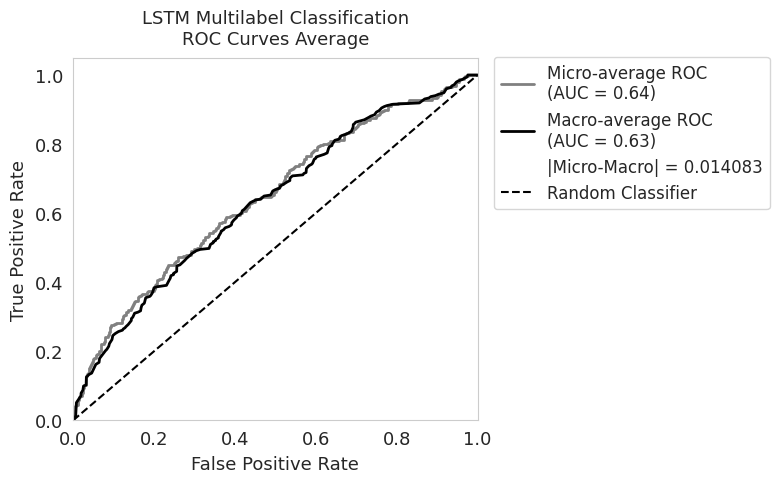

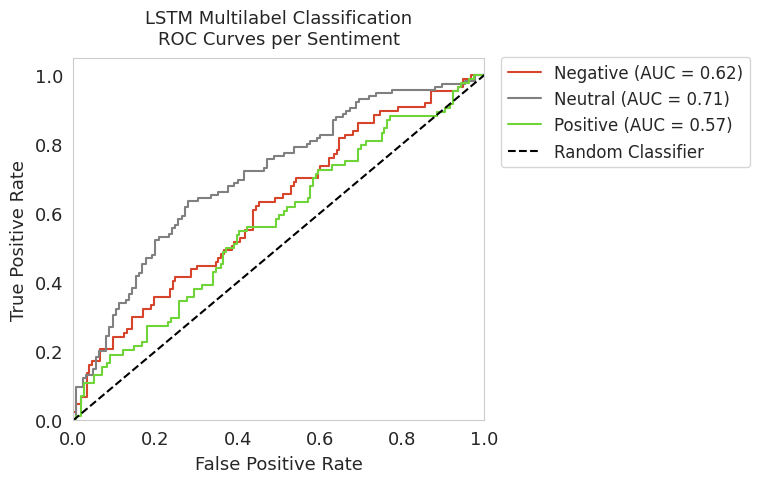

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.644936,0.056277,0.584393,0.705478,0.030889
Macro,0.630852,0.056277,0.567169,0.694535,0.032491
Weighted,0.638854,0.057824,0.578525,0.699182,0.030780
Micro-Macro Gap,0.014083,-,-,-,-


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,87.000000,115.000000,84.000000
Negative Samples,153.000000,125.000000,156.000000
AUC (roc_curve),0.615506,0.706157,0.570894
AUC (roc_auc_score),0.615506,0.706157,0.570894
95% CI Lower,0.607242,0.698710,0.562420
95% CI Upper,0.623770,0.713603,0.579369
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold (Youden),0.574710,0.623721,0.590227
Standard Threshold,0.500000,0.500000,0.500000



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.

ROC curve average metrics saved to: /workspace/Output/LSTM/LSTM_ML/Results/roc_curve_average_metrics.csv
ROC curve analysis saved to: /workspace/Output/LSTM/LSTM_ML/Results/roc_curve_analysis.csv



In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd
from IPython.display import display, HTML
import os

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Define labels first
label_names = ['Negative', 'Neutral', 'Positive']

# Base directory setup
base_dir = "/workspace/Output/LSTM/LSTM_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
print("Loading data...")
print("Base directory:", base_dir)
print("Predictions directory:", predictions_dir)

try:
    # Load data
    ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
    y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

    # Convert logits to probabilities and average ensemble predictions
    test_pred_proba = np.mean(1 / (1 + np.exp(-ensemble_logits)), axis=0)

    # Plot ROC Curves
    figure_dir = os.path.join(base_dir, "Figures")
    os.makedirs(figure_dir, exist_ok=True)
    colors = ['#d5442b', 'grey', '#6fd437']
    y_test_bin = y_test_true

    # Plot ROC Curves Average
    plt.figure(figsize=(8, 5))
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})', color='gray', linestyle='-', linewidth=2)

    all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] for i in range(len(label_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    class_aucs = []
    for i in range(len(label_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        class_aucs.append(auc(fpr, tpr))
    mean_tpr /= len(label_names)
    macro_auc = np.mean(class_aucs)
    micro_macro_diff = abs(roc_auc_micro - macro_auc)
    plt.plot(all_fpr, mean_tpr, 'k-', label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})', linewidth=2)
    plt.plot([], [], ' ', label=f'|Micro-Macro| = {micro_macro_diff:.6f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM Multilabel Classification\nROC Curves Average')
    plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'LSTM_ML_ROC_curves_averages.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Per-class ROC curves
    plt.figure(figsize=(7.8, 5))
    roc_results = []
    for i, (class_name, color) in enumerate(zip(label_names, colors)):
        y_true_binary = y_test_bin[:, i]
        y_score = test_pred_proba[:, i]
        fpr, tpr, _ = roc_curve(y_true_binary, y_score)
        roc_auc = auc(fpr, tpr)
        n_pos = np.sum(y_true_binary)
        n_neg = len(y_true_binary) - n_pos
        se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
        ci_lower = max(0, roc_auc - 1.96 * se)
        ci_upper = min(1, roc_auc + 1.96 * se)
        roc_results.append({
            'Class': class_name,
            'AUC': roc_auc,
            'CI Lower': ci_lower,
            'CI Upper': ci_upper
        })
        plt.plot(fpr, tpr, color=color, label=f'{class_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM Multilabel Classification\nROC Curves per Sentiment')
    plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
    plt.tight_layout()
    plt.savefig(os.path.join(figure_dir, 'LSTM_ML_ROC_curves_per_sentiment.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate average metrics
    n_classes = len(label_names)
    y_true_bin = label_binarize(y_test_true, classes=range(n_classes))
    class_metrics = []
    class_auc_scores = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': label_names[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)

    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), test_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    auc_macro = np.mean(class_auc_scores)
    class_support = np.sum(y_true_bin, axis=0)
    auc_weighted = np.average(class_auc_scores, weights=class_support)

    n_samples = len(y_test_true)
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    se_macro = np.sqrt(np.var(class_auc_scores) / n_classes)
    se_weighted = np.sqrt(np.average([(auc * (1 - auc)) for auc in class_auc_scores], weights=class_support) / n_samples)

    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)

    std_across_classes = np.std(class_auc_scores)

    average_metrics = {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

    # Create average metrics DataFrame
    average_metrics_data = []
    for avg_type in ['micro', 'macro', 'weighted']:
        metrics = average_metrics[avg_type]
        average_metrics_data.append({
            'Average Type': avg_type.capitalize(),
            'ROC AUC': f"{metrics['auc']:.6f}",
            'Standard Deviation': f"{metrics['std']:.6f}",
            '95% CI Lower': f"{metrics['ci'][0]:.6f}",
            '95% CI Upper': f"{metrics['ci'][1]:.6f}",
            'Standard Error': f"{metrics['se']:.6f}"
        })
    micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
    average_metrics_data.append({
        'Average Type': 'Micro-Macro Gap',
        'ROC AUC': f"{micro_macro_gap:.6f}",
        'Standard Deviation': "-",
        '95% CI Lower': "-",
        '95% CI Upper': "-",
        'Standard Error': "-"
    })
    average_metrics_df = pd.DataFrame(average_metrics_data)
    average_metrics_df = average_metrics_df.set_index('Average Type')

    # Calculate detailed metrics for each class
    detailed_roc_results = []
    y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
    for i, class_name in enumerate(label_names):
        y_true_binary = y_test_bin[:, i]
        y_score = test_pred_proba[:, i]
        fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
        auc_direct = auc(fpr, tpr)
        auc_score = roc_auc_score(y_true_binary, y_score)
        n_pos = np.sum(y_true_binary)
        n_neg = len(y_true_binary) - n_pos
        se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
        ci_lower = max(0, auc_direct - 1.96 * se)
        ci_upper = min(1, auc_direct + 1.96 * se)
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        y_pred_standard = (y_score >= 0.5).astype(int)
        y_pred_optimal = (y_score >= optimal_threshold).astype(int)
        precision_standard = precision_score(y_true_binary, y_pred_standard, zero_division=0)
        recall_standard = recall_score(y_true_binary, y_pred_standard, zero_division=0)
        precision_optimal = precision_score(y_true_binary, y_pred_optimal, zero_division=0)
        recall_optimal = recall_score(y_true_binary, y_pred_optimal, zero_division=0)
        result = {
            'Class': class_name,
            'Total Samples': len(y_true_binary),
            'Positive Samples': n_pos,
            'Negative Samples': n_neg,
            'AUC (roc_curve)': auc_direct,
            'AUC (roc_auc_score)': auc_score,
            '95% CI Lower': ci_lower,
            '95% CI Upper': ci_upper,
            'Difference between methods': abs(auc_direct - auc_score),
            'Optimal Threshold (Youden)': optimal_threshold,
            'Standard Threshold': 0.5,
            'Precision (Standard)': precision_standard,
            'Recall (Standard)': recall_standard,
            'Precision (Optimal)': precision_optimal,
            'Recall (Optimal)': recall_optimal
        }
        detailed_roc_results.append(result)

    # Create DataFrame and save results
    roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T
    float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
    for col in float_columns:
        roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

    # Save results
    os.makedirs(os.path.join(base_dir, 'Results'), exist_ok=True)
    average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
    average_metrics_df.to_csv(average_metrics_save_path, sep=';')
    save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
    roc_analysis_df.to_csv(save_path, sep=';')

    # Display results
    display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
    display(HTML(average_metrics_df.to_html()))
    display(HTML("<br><b>ROC Curve Analysis by Sentiment</b>"))
    display(HTML(roc_analysis_df.to_html()))
    print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
    print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")

    print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
    print(f"ROC curve analysis saved to: {save_path}\n")

except Exception as e:
    print(f"Error: {str(e)}")
    raise


### Probability Distributions

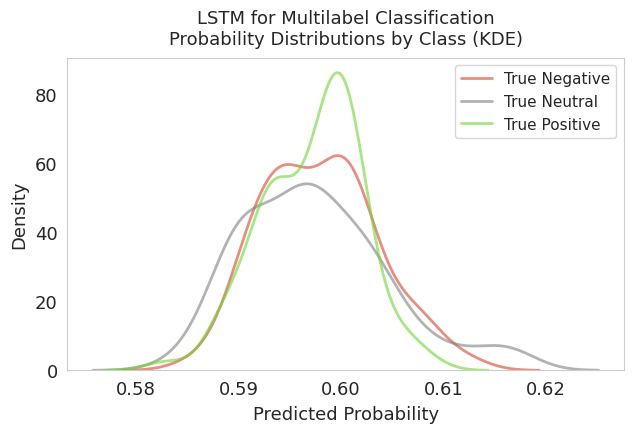

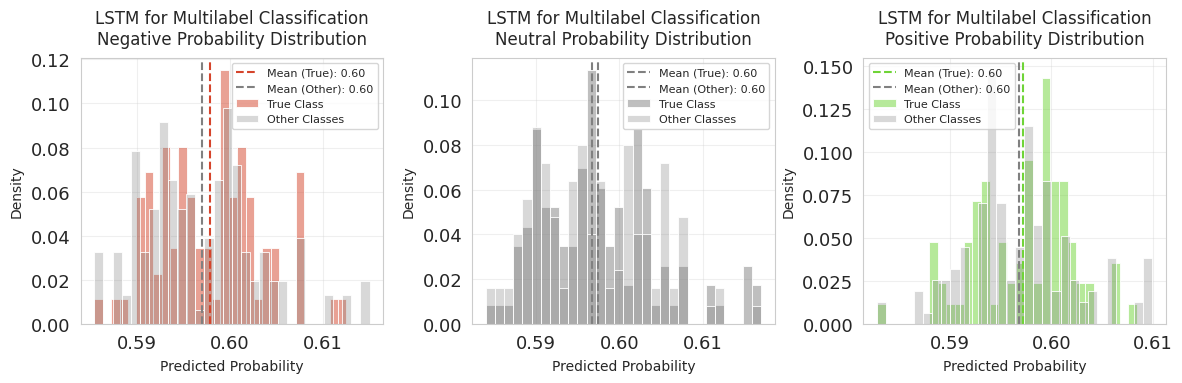

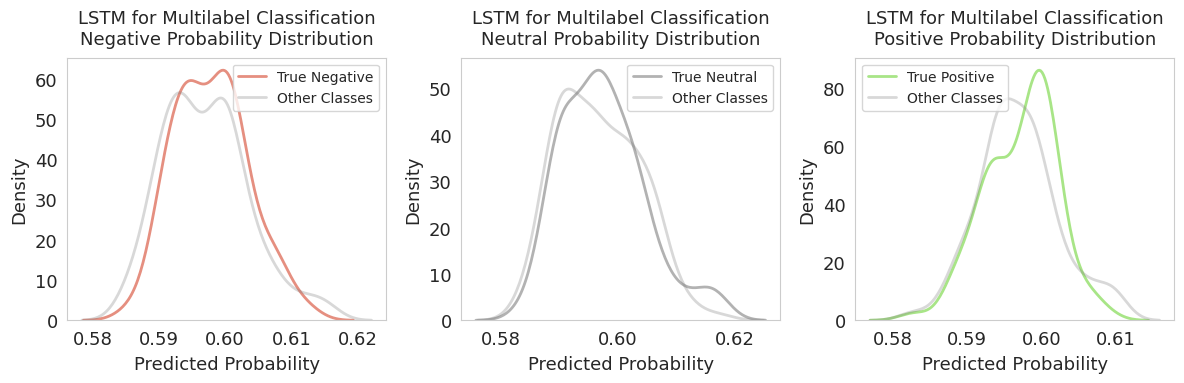

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.597904,0.005520,0.597067,0.006403,0.000837
Neutral,0.597478,0.007067,0.596746,0.006890,0.000732
Positive,0.597200,0.004753,0.596861,0.005355,0.000338


In [58]:
# ============== Visualize Probability Distributions for Multilabel Classification ====================

# Ensure correct averaging across ensemble models
test_pred_proba_avg = np.mean(test_pred_proba, axis=1)

# Reshape and repeat predictions to match true labels
if test_pred_proba_avg.ndim == 1:
    test_pred_proba_avg = test_pred_proba_avg.reshape(-1, len(label_names))

# Repeat predictions to match the number of true labels
repeat_factor = y_test_bin.shape[0] // test_pred_proba_avg.shape[0]
test_pred_proba_avg = np.repeat(test_pred_proba_avg, repeat_factor, axis=0)

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# --------------- KDE Plot All Sentiment ---------------
plt.figure(figsize=(6.5, 4.5))
colors = ['#d5442b', 'grey', '#6fd437']
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # Get probabilities for current class
    class_probs = test_pred_proba_avg[:, i]
    
    # Get true labels for this class
    true_class = y_test_bin[:, i]
    
    # Plot distributions for true and false classes
    sns.kdeplot(data=class_probs[true_class == 1], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('LSTM for Multilabel Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'LSTM_ML_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()

# ================== Enhanced Probability Distribution Visualization ===================
plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba_avg[:, i]
    
    # Get true labels for this class
    true_class = y_test_bin[:, i]
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class == 1], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[true_class == 0], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class == 1].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class == 1].mean():.2f}')
    plt.axvline(class_probs[true_class == 0].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[true_class == 0].mean():.2f}')
    
    plt.title(f'LSTM for Multilabel Classification\n{class_name} Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'LSTM_ML_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba_avg[:, i]
    
    # Get true labels for this class
    true_class = y_test_bin[:, i]
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class == 1], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[true_class == 0], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'LSTM for Multilabel Classification\n{class_name} Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'LSTM_ML_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    # Get probabilities for current class
    class_probs = test_pred_proba_avg[:, i]
    
    # Get true labels for this class
    true_class = y_test_bin[:, i]
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class == 1].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class == 1].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[true_class == 0].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[true_class == 0].std():.6f}",
        'Separation': f"{class_probs[true_class == 1].mean() - class_probs[true_class == 0].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices and Sentiment Distribution


Sentiment Distribution:


,True Label,Predictions
Negative,87,58
Neutral,115,116
Positive,84,78



Sentiment Distribution table saved in: /workspace/Output/LSTM/LSTM_ML/Results/LSTM_ML_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.500000,0.333333,0.400000,87.0
Neutral,0.646552,0.652174,0.649351,115.0
Positive,0.410256,0.380952,0.395062,84.0
micro avg,0.539683,0.475524,0.505576,286.0
macro avg,0.518936,0.455487,0.481471,286.0
weighted avg,0.532570,0.475524,0.498813,286.0
samples avg,0.508333,0.482639,0.476389,286.0



Additional Statistical Metrics:


,Metric,Value
0,Weighted Accuracy,0.634091
1,Weighted Precision,0.532570
2,Weighted Recall,0.475524
3,Weighted F1-Score,0.498813
4,Hamming Loss,0.369444



Analysis complete. Results saved in: /workspace/Output/LSTM/LSTM_ML/Results


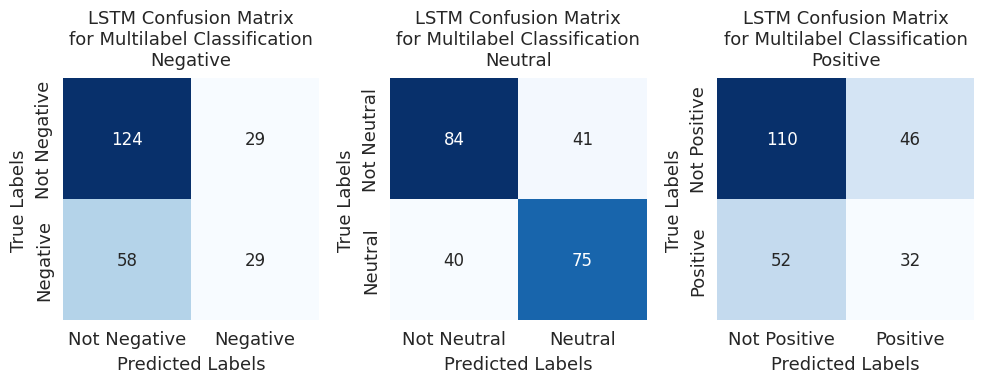

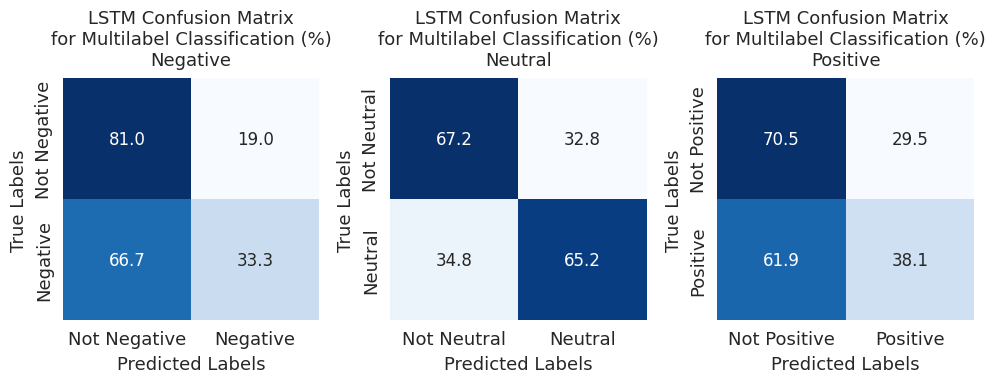

In [59]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================

# ============== Preparing Data ================
# Load the saved ensemble predictions directly
base_dir = "/workspace/Output/LSTM/LSTM_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
ensemble_predictions = np.load(os.path.join(predictions_dir, 'ensemble_predictions.npy'))
test_pred_proba_avg = ensemble_predictions  # Use the actual predictions that were saved

# Using the data from ROC curve analysis
# Convert to binary predictions using threshold
threshold = 0.5
y_pred_binary = (test_pred_proba_avg >= threshold).astype(int)

# Create output directory if it doesn't exist
base_dir = "/workspace/Output/LSTM/LSTM_ML"
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_multilabel_metrics(y_true, y_pred, labels):
    """Compute metrics for multilabel classification"""
    results = {
        'Subset Accuracy': accuracy_score(y_true, y_pred),
        'Hamming Accuracy': 1 - hamming_loss(y_true, y_pred),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted'),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Weighted F1-Score': f1_score(y_true, y_pred, average='weighted'),
        'Jaccard Score': jaccard_score(y_true, y_pred, average='weighted')
    }
    
    return results.copy()

# ============== Basic Distribution Analysis ================
# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.DataFrame({label: y_test_bin[:, i].sum() for i, label in enumerate(label_names)}, index=['True Label']).T
prediction_dist = pd.DataFrame({label: (test_pred_proba_avg[:, i] >= 0.5).sum() for i, label in enumerate(label_names)}, index=['Predictions']).T

# Merge the two DataFrames
distribution_table = pd.concat([true_label_dist, prediction_dist], axis=1)

# Reorder rows to match the desired order
distribution_table = distribution_table.loc[label_names]

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'LSTM_ML_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", os.path.join(output_dir, 'LSTM_ML_Sentiment_Distribution.csv'))

# Calculate accuracy for each class
accuracies = []
for i in range(len(label_names)):
    true_labels = y_test_bin[:, i]
    pred_labels = (test_pred_proba_avg[:, i] >= 0.5).astype(int)
    accuracies.append(np.mean(true_labels == pred_labels))

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_test_bin, (test_pred_proba_avg >= 0.5).astype(int), target_names=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = {
    'Weighted Accuracy': np.average(accuracies, weights=[len(y_test_bin[y_test_bin[:, i] == 1]) for i in range(len(label_names))]),
    'Weighted Precision': class_report['weighted avg']['precision'],
    'Weighted Recall': class_report['weighted avg']['recall'],
    'Weighted F1-Score': class_report['weighted avg']['f1-score'],
    'Hamming Loss': hamming_loss(y_test_bin, (test_pred_proba_avg >= 0.5).astype(int))
}

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()
additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(lambda x: f'{x:.6f}')
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)

# ============== Confusion Matrix Visualization ================
# Create confusion matrices for each class
confusion_matrices = []
for i, class_name in enumerate(label_names):
    y_true_binary = y_test_bin[:, i]
    y_pred_binary = (test_pred_proba_avg[:, i] >= 0.5).astype(int)
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    confusion_matrices.append(cm)

# Plot counts
fig_counts, axes_counts = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_counts = [axes_counts] if len(confusion_matrices) == 1 else axes_counts

for i, conf_matrix in enumerate(confusion_matrices):
    sns.heatmap(
        conf_matrix,
        annot=conf_matrix,
        fmt='g',
        cmap='Blues',
        cbar=False,
        ax=axes_counts[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_counts[i].set_title(f'LSTM Confusion Matrix\nfor Multilabel Classification\n{label_names[i]}')
    axes_counts[i].set_xlabel('Predicted Labels')
    axes_counts[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'LSTM_ML_confusion_matrix_counts.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot percentages
fig_percentages, axes_percentages = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_percentages = [axes_percentages] if len(confusion_matrices) == 1 else axes_percentages

for i, conf_matrix in enumerate(confusion_matrices):
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_normalized = np.zeros_like(conf_matrix, dtype=float)
    for j in range(len(row_sums)):
        if row_sums[j] != 0:
            conf_matrix_normalized[j] = conf_matrix[j] / row_sums[j]
    
    sns.heatmap(
        conf_matrix_normalized * 100,
        annot=np.round(conf_matrix_normalized * 100, 1),
        fmt='.1f',
        cmap='Blues',
        cbar=False,
        ax=axes_percentages[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_percentages[i].set_title(f'LSTM Confusion Matrix\nfor Multilabel Classification (%)\n{label_names[i]}')
    axes_percentages[i].set_xlabel('Predicted Labels')
    axes_percentages[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'LSTM_ML_confusion_matrix_percentage.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Early Stopping Epochs per Fold

In [60]:
#==========================================================================================
#                                 Early Stopping Epochs per Fold
#==========================================================================================
from scipy import stats
import numpy as np
import pandas as pd
import os
import json
from IPython.display import display, HTML

# Directory
output_dir = "/workspace/Output/LSTM/LSTM_ML/"

# Define number of folds
num_folds = 5  # Adjust this value based on your actual number of folds

# Collect epoch data for each fold
fold_epochs = []
for fold in range(1, num_folds + 1):
    es_file = os.path.join(output_dir, f'fold_{fold}', 'early_stopping.json')
    with open(es_file, 'r') as f:
        es_data = json.load(f)
    fold_epochs.append(es_data['best_epoch'] + 1)  # Add 1 because epochs are 0-indexed

# Calculate statistics
mean_epoch = np.mean(fold_epochs)
std_epoch = np.std(fold_epochs)
ci_epoch = stats.t.interval(0.95, len(fold_epochs)-1, loc=mean_epoch, scale=stats.sem(fold_epochs))
min_epoch = min(fold_epochs)
max_epoch = max(fold_epochs)

# Format values to 2 decimal places
mean_epoch = f"{mean_epoch:.2f}"
std_epoch = f"{std_epoch:.2f}"
ci_lower = f"{ci_epoch[0]:.2f}"
ci_upper = f"{ci_epoch[1]:.2f}"

# Create the first table
fold_table = pd.DataFrame({
    'Fold': range(1, num_folds + 1),
    'Epochs': fold_epochs
})

# Create the statistics table
stats_table = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', '95% CI Lower', '95% CI Upper', 'Minimum', 'Maximum'],
    'Value': [mean_epoch, std_epoch, ci_lower, ci_upper, min_epoch, max_epoch]
})

# Display tables
display(HTML('<div style="font-size: 20px;">Table 1: Early Stopping Epochs per Fold</div>'))
display(HTML(fold_table.to_html(index=False)))
display(HTML('<div style="font-size: 20px;">Table 2: Early Stopping Statistics</div>'))
display(HTML(stats_table.to_html(index=False)))

Fold,Epochs
1,6
2,7
3,6
4,5
5,6


Statistic,Value
Mean,6.00
Standard Deviation,0.63
95% CI Lower,5.12
95% CI Upper,6.88
Minimum,5
Maximum,7


# Multiclass VS Multilabel Comparison

## Comparing Hyperparameters

In [72]:
import json
import pandas as pd
import os
from IPython.display import display, HTML

# File paths
MC_PARAMS_PATH = "/workspace/Output/LSTM/LSTM_MC/Optuna_search/best_params.json"
ML_PARAMS_PATH = "/workspace/Output/LSTM/LSTM_ML/Optuna_search/best_params.json"

def read_json_params(file_path):
    """Read parameters from JSON file"""
    try:
        with open(file_path, 'r') as f:
            params = json.load(f)
            return params
    except FileNotFoundError:
        print(f"Warning: {file_path} not found")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file {file_path}: {e}")
        return {}

def create_parameter_comparison():
    """Create and save parameter comparison table"""
    # Get parameters from JSON files
    mc_params = read_json_params(MC_PARAMS_PATH)
    ml_params = read_json_params(ML_PARAMS_PATH)
    
    # Define base parameters that don't change
    base_params = {
        "Optimizer": "AdamW",
        "Activation Output Layer": ["Softmax", "Sigmoid"],
        "Loss Function": ["CrossEntropyLoss", "BCEWithLogitsLoss"],
        "Cross-Validation Folds": "5",
        "Early Stopping Patience": "3",
        "Early Stopping Threshold": "0.01",
        "Evaluation Strategy": "epoch",
        "Metric for Best Model": "custom metric",
        "Number of Labels": ["3", "3"],
        "Seed": "42",
        "Hyperparameter Search Method": "Optuna"
    }
    
    # Create DataFrame content with reordered parameters
    data = {
        "Hyperparameters": [
            "Max Length",
            "Learning Rate",
            "Batch Size",
            "Hidden Size",
            "Number of Layers",
            "Dropout Rate",
            "Weight Decay",
            "Epochs",
            "Max Words",
            "Warmup Steps",
            "Warmup Ratio",
            "Embedding Dimension",
            *base_params.keys()
        ],
        "Multiclass LSTM": [
            str(mc_params.get('max_length', 'N/A')),
            f"{mc_params.get('learning_rate', 'N/A')}",
            str(mc_params.get('batch_size', 'N/A')),
            str(mc_params.get('hidden_size', 'N/A')),
            str(mc_params.get('num_layers', 'N/A')),
            str(mc_params.get('dropout_rate', 'N/A')),
            str(mc_params.get('weight_decay', 'N/A')),
            str(mc_params.get('epochs', 'N/A')),
            str(mc_params.get('max_words', 'N/A')),
            str(mc_params.get('warmup_steps', 'N/A')),
            "0.1",
            str(mc_params.get('embedding_dim', 'N/A')),
            *[v[0] if isinstance(v, list) else v for v in base_params.values()]
        ],
        "Multilabel LSTM": [
            str(ml_params.get('max_length', 'N/A')),
            f"{ml_params.get('learning_rate', 'N/A')}",
            str(ml_params.get('batch_size', 'N/A')),
            str(ml_params.get('hidden_size', 'N/A')),
            str(ml_params.get('num_layers', 'N/A')),
            str(ml_params.get('dropout_rate', 'N/A')),
            str(ml_params.get('weight_decay', 'N/A')),
            str(ml_params.get('epochs', 'N/A')),
            str(ml_params.get('max_words', 'N/A')),
            str(ml_params.get('warmup_steps', 'N/A')),
            "0.1",
            str(ml_params.get('embedding_dim', 'N/A')),
            *[v[1] if isinstance(v, list) else v for v in base_params.values()]
        ]
    }
    
    # Create DataFrame
    comparison_df = pd.DataFrame(data)
    
    # Save to CSV
    output_dir = '/workspace/Output/LSTM/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "LSTM_parameters_comparison.csv")
    comparison_df.to_csv(output_file, index=False, sep=';')
    
    # Display styled table with title
    display(HTML('<div style="font-size: 20px; font-weight: bold; margin-bottom: 20px;">Comparative Table of Hyperparameters for Multiclass and Multilabel Classification</div>'))
    display(HTML(comparison_df.to_html(index=False)))
    
    print(f"\nSaved comparison table to: {output_file}")
    
    return comparison_df

# Create and display the table
comparison_df = create_parameter_comparison()

Hyperparameters,Multiclass LSTM,Multilabel LSTM
Max Length,22,22
Learning Rate,0.002,0.003
Batch Size,32,16
Hidden Size,192,192
Number of Layers,2,2
Dropout Rate,0.2,0.3
Weight Decay,0.05,0.05
Epochs,10,10
Max Words,1500,2500
Warmup Steps,500,250



Saved comparison table to: /workspace/Output/LSTM/Comparison/LSTM_parameters_comparison.csv


## Comparating Metrics

### Accuracy, Precision, Recall and F1-Score Comparison

In [65]:
# Table including multiclass and mutlilabel results

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/LSTM/LSTM_MC/Results/test_evaluation.csv'
   ml_file_path = '/workspace/Output/LSTM/LSTM_ML/Results/test_evaluation.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass LSTM *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel LSTM **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/LSTM/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "LSTM_comparative_test_results.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))
   

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass LSTM *,Standard deviation MC [Confidence Interval] *,Multilabel LSTM **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.424800,0.028968 [0.338663-0.419090],0.437382,0.033157 [0.390928-0.482988],0.012582,Multilabel
Precision,0.424898,0.033743 [0.332757-0.426443],0.532570,0.026258 [0.457738-0.530641],0.107672,Multilabel
Recall,0.424800,0.028968 [0.338663-0.419090],0.475524,0.036094 [0.415628-0.515840],0.050724,Multilabel
F1-Score,0.424050,0.035090 [0.320575-0.418001],0.498813,0.028521 [0.432487-0.511675],0.074763,Multilabel


### Accuracy, Metric2, Precision, Recall and F1-Score Comparison

In [66]:
# Version 2: table including multiclass and mutlilabel results including Metric2

import pandas as pd
from IPython.display import HTML
import os

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/LSTM/LSTM_MC/Results/test_evaluation.csv'
   ml_file_path = '/workspace/Output/LSTM/LSTM_ML/Results/test_evaluation.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Metric2", "Metric2_MC", "ML_Metric2"),  # Added Metric2
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass LSTM *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel LSTM **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/LSTM/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "LSTM_comparative_test_results_with metric2.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass LSTM *,Standard deviation MC [Confidence Interval] *,Multilabel LSTM **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.424800,0.028968 [0.338663-0.419090],0.437382,0.033157 [0.390928-0.482988],0.012582,Multilabel
Metric2,0.649883,0.039028 [0.553764-0.662124],0.541667,0.038640 [0.513026-0.620308],-0.108216,Multiclass
Precision,0.424898,0.033743 [0.332757-0.426443],0.532570,0.026258 [0.457738-0.530641],0.107672,Multilabel
Recall,0.424800,0.028968 [0.338663-0.419090],0.475524,0.036094 [0.415628-0.515840],0.050724,Multilabel
F1-Score,0.424050,0.035090 [0.320575-0.418001],0.498813,0.028521 [0.432487-0.511675],0.074763,Multilabel


### Comparing Area Under the Curve (AUC) ROC Scores

In [68]:
# Building a comparative AUC table

try:
    # Define file paths
    mc_file_path = '/workspace/Output/LSTM/LSTM_MC/Results/roc_curve_average_metrics.csv'
    ml_file_path = '/workspace/Output/LSTM/LSTM_ML/Results/roc_curve_average_metrics.csv'
    
    # Read CSV files
    mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
    ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
    
    # Define AUC metrics to compare
    auc_metrics = [
        ("AUC (Macro)", "Macro", "Macro"),
        ("AUC (Micro)", "Micro", "Micro")
    ]
    comparative_data = []
    
    # Process each AUC metric
    for base_metric, mc_metric, ml_metric in auc_metrics:
        try:
            # Get MC values
            mc_row = mc_results[mc_results['Average Type'] == mc_metric]
            if not mc_row.empty:
                mc_row = mc_row.iloc[0]
                mc_value = float(mc_row['ROC AUC'])
                mc_std = float(mc_row['Standard Deviation'])
                mc_ci_lower = float(mc_row['95% CI Lower'])
                mc_ci_upper = float(mc_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {mc_metric} not found in MC data")
                continue
            
            # Get ML values
            ml_row = ml_results[ml_results['Average Type'] == ml_metric]
            if not ml_row.empty:
                ml_row = ml_row.iloc[0]
                ml_value = float(ml_row['ROC AUC'])
                ml_std = float(ml_row['Standard Deviation'])
                ml_ci_lower = float(ml_row['95% CI Lower'])
                ml_ci_upper = float(ml_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {ml_metric} not found in ML data")
                continue
            
            difference = ml_value - mc_value
            best_class = "Multilabel" if difference > 0 else "Multiclass"
            
            comparative_data.append({
                'Metric': base_metric,
                'Multiclass LSTM': f"{mc_value:.6f}",
                'Standard deviation MC [Confidence Interval]': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
                'Multilabel LSTM': f"{ml_value:.6f}",
                'Standard deviation ML [Confidence Interval]': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
                'Difference': f"{difference:.6f}",
                'Best Classification': best_class
            })
            
        except Exception as e:
            print(f"Error processing metric {base_metric}: {str(e)}")
            continue

    # Create DataFrame
    comparative_metrics = pd.DataFrame(comparative_data)
    
    # Save to CSV (maintaining original output directory)
    output_dir = '/workspace/Output/LSTM/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "LSTM_comparative_roc_results.csv")
    comparative_metrics.to_csv(output_file, index=False, sep=';')
    
    # Display the table
    display(HTML(comparative_metrics.to_html(index=False)))
    
    # Print annotations
    display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))

except Exception as e:
    print(f"Main error: {str(e)}")

Metric,Multiclass LSTM,Standard deviation MC [Confidence Interval],Multilabel LSTM,Standard deviation ML [Confidence Interval],Difference,Best Classification
AUC (Macro),0.579688,0.019846 [0.557230-0.602146],0.630852,0.056277 [0.567169-0.694535],0.051164,Multilabel
AUC (Micro),0.576068,0.019846 [0.513545-0.638590],0.644936,0.056277 [0.584393-0.705478],0.068868,Multilabel


## ROC (Receiver Operating Characteristic) Curves Comparisons

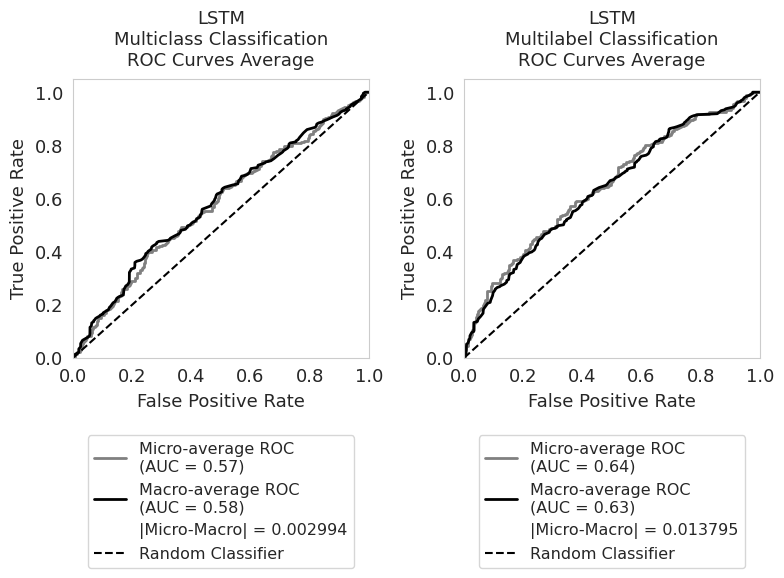

Comparative ROC curves generated successfully!


In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
from IPython.display import display, HTML

def sigmoid(x):
    """Compute sigmoid values for each set of scores in x."""
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

def plot_comparative_roc_curves():
    """Plot comparative ROC curves for multiclass and multilabel classification"""
    
    # Seaborn setting
    sns.set_style("whitegrid", {'axes.grid': False})
    
    # Create figure with 1 row and 2 columns
    plt.figure(figsize=(8, 6.5))
    
    # Define common variables
    label_names = ['Negative', 'Neutral', 'Positive']
    
    # ======================== First Subplot (Multiclass) ========================
    plt.subplot(1, 2, 1)
    
    # Load multiclass data
    mc_base_dir = "/workspace/Output/LSTM/LSTM_MC"
    mc_predictions_dir = os.path.join(mc_base_dir, 'Results/predictions')
    
    mc_ensemble_logits = np.load(os.path.join(mc_predictions_dir, 'ensemble_logits.npy'))
    mc_y_test_true = np.load(os.path.join(mc_base_dir, 'test_data/y_test.npy'))
    
    # Process multiclass predictions - take mean across ensemble axis if needed
    if len(mc_ensemble_logits.shape) == 3:  # if shape is (n_models, n_samples, n_classes)
        mc_ensemble_logits = np.mean(mc_ensemble_logits, axis=0)
    mc_test_pred_proba = softmax(mc_ensemble_logits)
    
    # Compute multiclass ROC curves
    mc_y_test_bin = label_binarize(mc_y_test_true, classes=range(len(label_names)))
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(mc_y_test_bin.ravel(), mc_test_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    plt.plot(fpr_micro, tpr_micro, 
             label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
             color='gray', linestyle='-', linewidth=2)
    
    # Macro average
    all_fpr = np.unique(np.concatenate([roc_curve(mc_y_test_bin[:, i], 
                                                 mc_test_pred_proba[:, i])[0] 
                                      for i in range(len(label_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    class_aucs = []
    
    for i in range(len(label_names)):
        fpr, tpr, _ = roc_curve(mc_y_test_bin[:, i], mc_test_pred_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        class_aucs.append(auc(fpr, tpr))
    
    mean_tpr /= len(label_names)
    macro_auc = np.mean(class_aucs)
    micro_macro_diff = abs(roc_auc_micro - macro_auc)
    
    plt.plot(all_fpr, mean_tpr, 'k-',
             label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
             linewidth=2)
    plt.plot([], [], ' ', label=f'|Micro-Macro| = {micro_macro_diff:.6f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM\nMulticlass Classification\nROC Curves Average')
    plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)
    
    # ======================== Second Subplot (Multilabel) ========================
    plt.subplot(1, 2, 2)
    
    # Load multilabel data
    ml_base_dir = "/workspace/Output/LSTM/LSTM_ML"
    ml_predictions_dir = os.path.join(ml_base_dir, 'Results/predictions')
    
    ml_ensemble_logits = np.load(os.path.join(ml_predictions_dir, 'ensemble_logits.npy'))
    ml_y_test_true = np.load(os.path.join(ml_base_dir, 'test_data/y_test.npy'))
    
    # Process multilabel predictions - take mean across ensemble axis if needed
    if len(ml_ensemble_logits.shape) == 3:  # if shape is (n_models, n_samples, n_classes)
        ml_ensemble_logits = np.mean(ml_ensemble_logits, axis=0)
    ml_test_pred_proba = sigmoid(ml_ensemble_logits)
    
    # Compute multilabel ROC curves
    ml_y_test_bin = label_binarize(ml_y_test_true, classes=range(len(label_names)))
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(ml_y_test_bin.ravel(), ml_test_pred_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    plt.plot(fpr_micro, tpr_micro, 
             label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
             color='gray', linestyle='-', linewidth=2)
    
    # Macro average
    all_fpr = np.unique(np.concatenate([roc_curve(ml_y_test_bin[:, i], 
                                                 ml_test_pred_proba[:, i])[0] 
                                      for i in range(len(label_names))]))
    mean_tpr = np.zeros_like(all_fpr)
    class_aucs = []
    
    for i in range(len(label_names)):
        fpr, tpr, _ = roc_curve(ml_y_test_bin[:, i], ml_test_pred_proba[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
        class_aucs.append(auc(fpr, tpr))
    
    mean_tpr /= len(label_names)
    macro_auc = np.mean(class_aucs)
    micro_macro_diff = abs(roc_auc_micro - macro_auc)
    
    plt.plot(all_fpr, mean_tpr, 'k-',
             label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
             linewidth=2)
    plt.plot([], [], ' ', label=f'|Micro-Macro| = {micro_macro_diff:.6f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM\nMultilabel Classification\nROC Curves Average')
    plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)
    
    # Adjust layout and save
    plt.tight_layout()
    
    # Create output directory if it doesn't exist
    output_dir = '/workspace/Output/LSTM/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the figure
    plt.savefig(os.path.join(output_dir, 'LSTM_combined_ROC_curves.png'), 
                dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(output_dir, 'LSTM_combined_ROC_curves.tiff'), 
            dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    try:
        plot_comparative_roc_curves()
        print("Comparative ROC curves generated successfully!")
    except Exception as e:
        print(f"Error generating comparative ROC curves: {str(e)}")

## Comparing Probability Distribution Plot

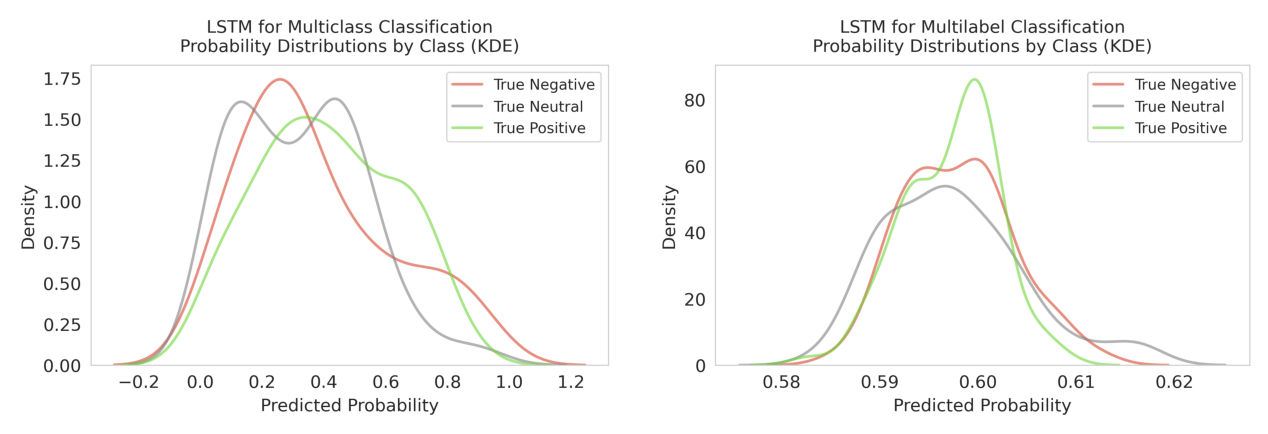

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths to the existing plots
mc_plot_path = '/workspace/Output/LSTM/LSTM_MC/Figures/LSTM_MC_probability_distributions.png'
ml_plot_path = '/workspace/Output/LSTM/LSTM_ML/Figures/LSTM_ML_probability_distributions.png'

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# Read and display the first plot (Multiclass)
img1 = mpimg.imread(mc_plot_path)
ax1.imshow(img1)
ax1.axis('off')  # Turn off axis for cleaner look

# Read and display the second plot (Multilabel)
img2 = mpimg.imread(ml_plot_path)
ax2.imshow(img2)
ax2.axis('off')  # Turn off axis for cleaner look

plt.tight_layout()

# Create output directory if it doesn't exist
output_dir = '/workspace/Output/LSTM/Comparison'
os.makedirs(output_dir, exist_ok=True)

# Save the combined figure
combined_path = os.path.join(output_dir, 'LSTM_combined_probability_distributions.png')
plt.savefig(combined_path, dpi=300, bbox_inches='tight')

plt.show()

# Notebook Execution Time

In [71]:
# Calculate and display total notebook execution time
end_global_notebook_running_time = time.time()
duration_global_notebook = end_global_notebook_running_time - start_global_notebook_running_time
hours, remainder = divmod(duration_global_notebook, 3600)
minutes, seconds = divmod(remainder, 60)

# Create the HTML string with bold formatting and modified separator
html_output = f"""<b>{'-' * 40} Total Notebook Execution Time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d} {'-' * 40}</b>"""

# Display the HTML output
display(HTML(html_output))